In [1]:
import tensorflow as tf 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
# Model improvement and Evaluation 
from sklearn import metrics 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score

print('tensorflow version', tf.__version__)
bank_data = pd.read_csv('data/1_american_dataset.csv')

training = pd.read_csv('data/train_american_bankruptcy.csv')
testing = pd.read_csv('data/test_american_bankruptcy.csv')
validation = pd.read_csv('data/validate_american_bankruptcy.csv')

# training (70%), validation (15%), testing (15%) 

X_train = training.drop(['status'], axis=1)
y_train = training['status']

X_test = testing.drop(['status'], axis=1)
y_test = testing['status']

X_validate = validation.drop(['status'], axis=1)
y_validate = validation['status']

class_names = ['Bankrupt', "Healthy"]

tensorflow version 2.11.0


In [2]:
print("y_train data distribution:\n", y_train.value_counts())
print("y_validate data distribution:\n", y_validate.value_counts())
print("y_test data distribution:\n", y_test.value_counts())

input_shape = (18,)
print(input_shape)

y_train data distribution:
 1    3444
0    3404
Name: status, dtype: int64
y_validate data distribution:
 0    785
1    719
Name: status, dtype: int64
y_test data distribution:
 0    783
1    783
Name: status, dtype: int64
(18,)


In [3]:
import os

def create_callbacks(checkpoint_dir, checkpoint_freq, checkpoint_period):
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, 'ckpt_{epoch}'),
        save_freq=checkpoint_freq,
        period=checkpoint_period,
        # save_best_only=True
    )
    return [checkpoint_callback]

In [4]:
def plot_history(history):
    fig, axs = plt.subplots(2, 1, figsize=(24, 16))

    # Plot training & validation accuracy values
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Training Set', 'Validation Set'], loc='upper left')

    # Plot training & validation loss values
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Training Set', 'Validation Set'], loc='upper left')
    
    fig.tight_layout(pad=0.5)

    plt.show()

In [5]:
# display confusion matrix

def plot_cm(cm):
    # Define class labels
    class_labels = ["Not Bankrupt", "Bankrupt"]

    # Create heatmap
    sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

    # Add labels and title
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix")

    # Show plot
    plt.show()

## Model 1
Gives decent preformance with learnign rate of 00008. Needs more epochs

In [7]:
def bankruptcy_model():
    model = tf.keras.Sequential([
        # tf.keras.layers.Dense(32, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dense(22, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(10, activation='relu'),
        # tf.keras.layers.Dense(4, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00008)
    
    model.compile(optimizer, 
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model

# callbacks = [
#     tf.keras.callbacks.EarlyStopping(patience=6, monitor='val_loss'),
#     tf.keras.callbacks.ModelCheckpoint(filepath='model_checkpoints/model1_model.h5', monitor='val_loss', save_best_only=True)
# ]

In [8]:
model = bankruptcy_model()
# save checkpoint every 5 epochs
callbacks = create_callbacks('model_checkpoints/model1/', 'epoch', 5)

history = model.fit(X_train, y_train,
                    validation_data=(X_validate, y_validate),
                    epochs=300,
                    batch_size=25,
                    callbacks=callbacks,
                    # validation_steps=1,
                    # validation_batch_size=1504
                    # class_weight=class_weight
                    )

Epoch 1/300
274/274 [==============================] - 3s 4ms/step - loss: 0.6868 - accuracy: 0.5428 - precision: 0.5398 - recall: 0.6170 - val_loss: 0.6823 - val_accuracy: 0.5312 - val_precision: 0.5068 - val_recall: 0.7204
Epoch 2/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6845 - accuracy: 0.5378 - precision: 0.5374 - recall: 0.5822 - val_loss: 0.6789 - val_accuracy: 0.5379 - val_precision: 0.5116 - val_recall: 0.7357
Epoch 3/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6822 - accuracy: 0.5476 - precision: 0.5462 - recall: 0.5935 - val_loss: 0.6794 - val_accuracy: 0.5452 - val_precision: 0.5172 - val_recall: 0.7316
Epoch 4/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6786 - accuracy: 0.5568 - precision: 0.5548 - recall: 0.6013 - val_loss: 0.6768 - val_accuracy: 0.5479 - val_precision: 0.5286 - val_recall: 0.5021
Epoch 5/300
265/274 [============================>.] - ETA: 0s - loss: 0.6775 - accuracy: 0.5602 - p

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_5/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_5/assets


274/274 [==============================] - 2s 7ms/step - loss: 0.6778 - accuracy: 0.5596 - precision: 0.5565 - recall: 0.6121 - val_loss: 0.6759 - val_accuracy: 0.5638 - val_precision: 0.5345 - val_recall: 0.6787
Epoch 6/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6754 - accuracy: 0.5697 - precision: 0.5653 - recall: 0.6243 - val_loss: 0.6754 - val_accuracy: 0.5592 - val_precision: 0.5293 - val_recall: 0.7038
Epoch 7/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6758 - accuracy: 0.5605 - precision: 0.5552 - recall: 0.6339 - val_loss: 0.6732 - val_accuracy: 0.5512 - val_precision: 0.5334 - val_recall: 0.4882
Epoch 8/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6755 - accuracy: 0.5588 - precision: 0.5561 - recall: 0.6089 - val_loss: 0.6727 - val_accuracy: 0.5632 - val_precision: 0.5309 - val_recall: 0.7399
Epoch 9/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6749 - accuracy: 0.5720 - precision

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_10/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_10/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6733 - accuracy: 0.5685 - precision: 0.5594 - recall: 0.6681 - val_loss: 0.6720 - val_accuracy: 0.5625 - val_precision: 0.5417 - val_recall: 0.5508
Epoch 11/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6716 - accuracy: 0.5688 - precision: 0.5614 - recall: 0.6519 - val_loss: 0.6711 - val_accuracy: 0.5685 - val_precision: 0.5419 - val_recall: 0.6300
Epoch 12/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6714 - accuracy: 0.5682 - precision: 0.5583 - recall: 0.6768 - val_loss: 0.6705 - val_accuracy: 0.5711 - val_precision: 0.5354 - val_recall: 0.7789
Epoch 13/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6709 - accuracy: 0.5756 - precision: 0.5638 - recall: 0.6899 - val_loss: 0.6704 - val_accuracy: 0.5711 - val_precision: 0.5329 - val_recall: 0.8331
Epoch 14/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6730 - accuracy: 0.5680 - preci

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_15/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_15/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6697 - accuracy: 0.5768 - precision: 0.5637 - recall: 0.7012 - val_loss: 0.6696 - val_accuracy: 0.5778 - val_precision: 0.5494 - val_recall: 0.6495
Epoch 16/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6707 - accuracy: 0.5675 - precision: 0.5564 - recall: 0.6902 - val_loss: 0.6696 - val_accuracy: 0.5711 - val_precision: 0.5401 - val_recall: 0.6926
Epoch 17/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6700 - accuracy: 0.5708 - precision: 0.5582 - recall: 0.7030 - val_loss: 0.6690 - val_accuracy: 0.5685 - val_precision: 0.5437 - val_recall: 0.6050
Epoch 18/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6713 - accuracy: 0.5654 - precision: 0.5547 - recall: 0.6890 - val_loss: 0.6682 - val_accuracy: 0.5725 - val_precision: 0.5325 - val_recall: 0.8651
Epoch 19/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6713 - accuracy: 0.5688 - preci

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_20/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_20/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6684 - accuracy: 0.5762 - precision: 0.5598 - recall: 0.7364 - val_loss: 0.6681 - val_accuracy: 0.5658 - val_precision: 0.5270 - val_recall: 0.8957
Epoch 21/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6701 - accuracy: 0.5754 - precision: 0.5587 - recall: 0.7407 - val_loss: 0.6688 - val_accuracy: 0.5672 - val_precision: 0.5373 - val_recall: 0.6815
Epoch 22/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6664 - accuracy: 0.5762 - precision: 0.5592 - recall: 0.7427 - val_loss: 0.6693 - val_accuracy: 0.5585 - val_precision: 0.5339 - val_recall: 0.6022
Epoch 23/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6676 - accuracy: 0.5794 - precision: 0.5627 - recall: 0.7352 - val_loss: 0.6683 - val_accuracy: 0.5658 - val_precision: 0.5395 - val_recall: 0.6273
Epoch 24/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6681 - accuracy: 0.5748 - preci

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_25/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_25/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6670 - accuracy: 0.5742 - precision: 0.5572 - recall: 0.7471 - val_loss: 0.6677 - val_accuracy: 0.5698 - val_precision: 0.5438 - val_recall: 0.6217
Epoch 26/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6669 - accuracy: 0.5783 - precision: 0.5630 - recall: 0.7210 - val_loss: 0.6660 - val_accuracy: 0.5791 - val_precision: 0.5432 - val_recall: 0.7524
Epoch 27/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6677 - accuracy: 0.5710 - precision: 0.5568 - recall: 0.7198 - val_loss: 0.6668 - val_accuracy: 0.5678 - val_precision: 0.5389 - val_recall: 0.6648
Epoch 28/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6662 - accuracy: 0.5791 - precision: 0.5626 - recall: 0.7337 - val_loss: 0.6680 - val_accuracy: 0.5632 - val_precision: 0.5373 - val_recall: 0.6203
Epoch 29/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6649 - accuracy: 0.5787 - preci

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_30/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_30/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6690 - accuracy: 0.5770 - precision: 0.5612 - recall: 0.7285 - val_loss: 0.6659 - val_accuracy: 0.5811 - val_precision: 0.5385 - val_recall: 0.8665
Epoch 31/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6665 - accuracy: 0.5809 - precision: 0.5623 - recall: 0.7517 - val_loss: 0.6675 - val_accuracy: 0.5625 - val_precision: 0.5369 - val_recall: 0.6175
Epoch 32/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6668 - accuracy: 0.5699 - precision: 0.5545 - recall: 0.7369 - val_loss: 0.6661 - val_accuracy: 0.5691 - val_precision: 0.5430 - val_recall: 0.6231
Epoch 33/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6656 - accuracy: 0.5799 - precision: 0.5621 - recall: 0.7451 - val_loss: 0.6660 - val_accuracy: 0.5638 - val_precision: 0.5359 - val_recall: 0.6537
Epoch 34/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6662 - accuracy: 0.5783 - preci

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_35/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_35/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6659 - accuracy: 0.5721 - precision: 0.5568 - recall: 0.7311 - val_loss: 0.6665 - val_accuracy: 0.5585 - val_precision: 0.5317 - val_recall: 0.6412
Epoch 36/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6625 - accuracy: 0.5857 - precision: 0.5672 - recall: 0.7436 - val_loss: 0.6667 - val_accuracy: 0.5578 - val_precision: 0.5315 - val_recall: 0.6328
Epoch 37/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6663 - accuracy: 0.5680 - precision: 0.5537 - recall: 0.7276 - val_loss: 0.6662 - val_accuracy: 0.5512 - val_precision: 0.5251 - val_recall: 0.6398
Epoch 38/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6648 - accuracy: 0.5799 - precision: 0.5632 - recall: 0.7334 - val_loss: 0.6647 - val_accuracy: 0.5685 - val_precision: 0.5385 - val_recall: 0.6801
Epoch 39/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6643 - accuracy: 0.5772 - preci

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_40/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_40/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6634 - accuracy: 0.5827 - precision: 0.5663 - recall: 0.7262 - val_loss: 0.6667 - val_accuracy: 0.5612 - val_precision: 0.5348 - val_recall: 0.6300
Epoch 41/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6626 - accuracy: 0.5815 - precision: 0.5640 - recall: 0.7398 - val_loss: 0.6644 - val_accuracy: 0.5751 - val_precision: 0.5448 - val_recall: 0.6759
Epoch 42/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6640 - accuracy: 0.5717 - precision: 0.5565 - recall: 0.7303 - val_loss: 0.6651 - val_accuracy: 0.5705 - val_precision: 0.5408 - val_recall: 0.6732
Epoch 43/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6636 - accuracy: 0.5737 - precision: 0.5580 - recall: 0.7332 - val_loss: 0.6650 - val_accuracy: 0.5678 - val_precision: 0.5400 - val_recall: 0.6481
Epoch 44/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6638 - accuracy: 0.5749 - preci

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_45/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_45/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6626 - accuracy: 0.5794 - precision: 0.5642 - recall: 0.7195 - val_loss: 0.6638 - val_accuracy: 0.5791 - val_precision: 0.5497 - val_recall: 0.6620
Epoch 46/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6626 - accuracy: 0.5799 - precision: 0.5625 - recall: 0.7410 - val_loss: 0.6657 - val_accuracy: 0.5585 - val_precision: 0.5325 - val_recall: 0.6273
Epoch 47/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6623 - accuracy: 0.5789 - precision: 0.5640 - recall: 0.7169 - val_loss: 0.6634 - val_accuracy: 0.5691 - val_precision: 0.5406 - val_recall: 0.6579
Epoch 48/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6620 - accuracy: 0.5831 - precision: 0.5657 - recall: 0.7364 - val_loss: 0.6634 - val_accuracy: 0.5632 - val_precision: 0.5348 - val_recall: 0.6634
Epoch 49/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6623 - accuracy: 0.5818 - preci

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_50/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_50/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6604 - accuracy: 0.5846 - precision: 0.5663 - recall: 0.7425 - val_loss: 0.6641 - val_accuracy: 0.5552 - val_precision: 0.5296 - val_recall: 0.6217
Epoch 51/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6630 - accuracy: 0.5772 - precision: 0.5619 - recall: 0.7233 - val_loss: 0.6644 - val_accuracy: 0.5578 - val_precision: 0.5315 - val_recall: 0.6342
Epoch 52/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6594 - accuracy: 0.5897 - precision: 0.5725 - recall: 0.7265 - val_loss: 0.6627 - val_accuracy: 0.5785 - val_precision: 0.5507 - val_recall: 0.6426
Epoch 53/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6581 - accuracy: 0.5910 - precision: 0.5725 - recall: 0.7372 - val_loss: 0.6627 - val_accuracy: 0.5698 - val_precision: 0.5410 - val_recall: 0.6606
Epoch 54/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6605 - accuracy: 0.5892 - preci

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_55/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_55/assets


274/274 [==============================] - 2s 7ms/step - loss: 0.6617 - accuracy: 0.5816 - precision: 0.5650 - recall: 0.7305 - val_loss: 0.6663 - val_accuracy: 0.5632 - val_precision: 0.5383 - val_recall: 0.6064
Epoch 56/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6592 - accuracy: 0.5818 - precision: 0.5658 - recall: 0.7244 - val_loss: 0.6636 - val_accuracy: 0.5612 - val_precision: 0.5355 - val_recall: 0.6189
Epoch 57/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6587 - accuracy: 0.5831 - precision: 0.5677 - recall: 0.7175 - val_loss: 0.6607 - val_accuracy: 0.5818 - val_precision: 0.5606 - val_recall: 0.5786
Epoch 58/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6585 - accuracy: 0.5840 - precision: 0.5700 - recall: 0.7033 - val_loss: 0.6640 - val_accuracy: 0.5658 - val_precision: 0.5401 - val_recall: 0.6175
Epoch 59/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6571 - accuracy: 0.5850 - preci

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_60/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_60/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6569 - accuracy: 0.5961 - precision: 0.5793 - recall: 0.7189 - val_loss: 0.6597 - val_accuracy: 0.5785 - val_precision: 0.5486 - val_recall: 0.6676
Epoch 61/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6570 - accuracy: 0.5936 - precision: 0.5762 - recall: 0.7256 - val_loss: 0.6601 - val_accuracy: 0.5731 - val_precision: 0.5477 - val_recall: 0.6147
Epoch 62/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6573 - accuracy: 0.5847 - precision: 0.5719 - recall: 0.6928 - val_loss: 0.6607 - val_accuracy: 0.5691 - val_precision: 0.5425 - val_recall: 0.6300
Epoch 63/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6554 - accuracy: 0.5926 - precision: 0.5791 - recall: 0.6951 - val_loss: 0.6604 - val_accuracy: 0.5698 - val_precision: 0.5431 - val_recall: 0.6314
Epoch 64/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6561 - accuracy: 0.5924 - preci

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_65/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_65/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6560 - accuracy: 0.5889 - precision: 0.5750 - recall: 0.6998 - val_loss: 0.6612 - val_accuracy: 0.5672 - val_precision: 0.5426 - val_recall: 0.6022
Epoch 66/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6564 - accuracy: 0.5920 - precision: 0.5810 - recall: 0.6765 - val_loss: 0.6630 - val_accuracy: 0.5625 - val_precision: 0.5367 - val_recall: 0.6203
Epoch 67/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6570 - accuracy: 0.5856 - precision: 0.5737 - recall: 0.6847 - val_loss: 0.6635 - val_accuracy: 0.5678 - val_precision: 0.5425 - val_recall: 0.6120
Epoch 68/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6544 - accuracy: 0.5992 - precision: 0.5842 - recall: 0.7041 - val_loss: 0.6635 - val_accuracy: 0.5665 - val_precision: 0.5406 - val_recall: 0.6203
Epoch 69/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6533 - accuracy: 0.5967 - preci

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_70/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_70/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6522 - accuracy: 0.5993 - precision: 0.5855 - recall: 0.6957 - val_loss: 0.6616 - val_accuracy: 0.5665 - val_precision: 0.5425 - val_recall: 0.5953
Epoch 71/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6530 - accuracy: 0.6047 - precision: 0.5900 - recall: 0.7012 - val_loss: 0.6611 - val_accuracy: 0.5718 - val_precision: 0.5459 - val_recall: 0.6203
Epoch 72/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6521 - accuracy: 0.6016 - precision: 0.5874 - recall: 0.6986 - val_loss: 0.6605 - val_accuracy: 0.5678 - val_precision: 0.5422 - val_recall: 0.6161
Epoch 73/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6499 - accuracy: 0.5949 - precision: 0.5806 - recall: 0.7009 - val_loss: 0.6603 - val_accuracy: 0.5711 - val_precision: 0.5488 - val_recall: 0.5786
Epoch 74/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6509 - accuracy: 0.6043 - preci

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_75/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_75/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6518 - accuracy: 0.5965 - precision: 0.5837 - recall: 0.6893 - val_loss: 0.6627 - val_accuracy: 0.5672 - val_precision: 0.5419 - val_recall: 0.6120
Epoch 76/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6515 - accuracy: 0.5984 - precision: 0.5855 - recall: 0.6902 - val_loss: 0.6593 - val_accuracy: 0.5771 - val_precision: 0.5519 - val_recall: 0.6134
Epoch 77/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6537 - accuracy: 0.5959 - precision: 0.5834 - recall: 0.6876 - val_loss: 0.6617 - val_accuracy: 0.5725 - val_precision: 0.5481 - val_recall: 0.6022
Epoch 78/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6531 - accuracy: 0.5943 - precision: 0.5826 - recall: 0.6821 - val_loss: 0.6610 - val_accuracy: 0.5711 - val_precision: 0.5459 - val_recall: 0.6120
Epoch 79/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6488 - accuracy: 0.6070 - preci

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_80/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_80/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6527 - accuracy: 0.5949 - precision: 0.5844 - recall: 0.6736 - val_loss: 0.6591 - val_accuracy: 0.5738 - val_precision: 0.5477 - val_recall: 0.6231
Epoch 81/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6530 - accuracy: 0.5901 - precision: 0.5802 - recall: 0.6693 - val_loss: 0.6604 - val_accuracy: 0.5758 - val_precision: 0.5502 - val_recall: 0.6175
Epoch 82/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6491 - accuracy: 0.6028 - precision: 0.5931 - recall: 0.6699 - val_loss: 0.6588 - val_accuracy: 0.5725 - val_precision: 0.5459 - val_recall: 0.6287
Epoch 83/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6503 - accuracy: 0.5945 - precision: 0.5850 - recall: 0.6667 - val_loss: 0.6617 - val_accuracy: 0.5711 - val_precision: 0.5473 - val_recall: 0.5953
Epoch 84/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6498 - accuracy: 0.5954 - preci

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_85/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_85/assets


274/274 [==============================] - 2s 7ms/step - loss: 0.6486 - accuracy: 0.5994 - precision: 0.5897 - recall: 0.6693 - val_loss: 0.6607 - val_accuracy: 0.5705 - val_precision: 0.5464 - val_recall: 0.5981
Epoch 86/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6507 - accuracy: 0.6019 - precision: 0.5922 - recall: 0.6696 - val_loss: 0.6593 - val_accuracy: 0.5765 - val_precision: 0.5515 - val_recall: 0.6106
Epoch 87/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6473 - accuracy: 0.6029 - precision: 0.5925 - recall: 0.6742 - val_loss: 0.6589 - val_accuracy: 0.5691 - val_precision: 0.5432 - val_recall: 0.6203
Epoch 88/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6481 - accuracy: 0.6013 - precision: 0.5885 - recall: 0.6893 - val_loss: 0.6595 - val_accuracy: 0.5765 - val_precision: 0.5526 - val_recall: 0.5994
Epoch 89/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6486 - accuracy: 0.5977 - preci

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_90/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_90/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6501 - accuracy: 0.5958 - precision: 0.5880 - recall: 0.6559 - val_loss: 0.6590 - val_accuracy: 0.5745 - val_precision: 0.5496 - val_recall: 0.6092
Epoch 91/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6479 - accuracy: 0.6006 - precision: 0.5924 - recall: 0.6600 - val_loss: 0.6605 - val_accuracy: 0.5665 - val_precision: 0.5424 - val_recall: 0.5967
Epoch 92/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6457 - accuracy: 0.6025 - precision: 0.5923 - recall: 0.6725 - val_loss: 0.6596 - val_accuracy: 0.5718 - val_precision: 0.5491 - val_recall: 0.5828
Epoch 93/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6486 - accuracy: 0.5999 - precision: 0.5913 - recall: 0.6617 - val_loss: 0.6598 - val_accuracy: 0.5758 - val_precision: 0.5512 - val_recall: 0.6064
Epoch 94/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6443 - accuracy: 0.6103 - preci

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_95/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_95/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6482 - accuracy: 0.6012 - precision: 0.5931 - recall: 0.6594 - val_loss: 0.6613 - val_accuracy: 0.5718 - val_precision: 0.5499 - val_recall: 0.5744
Epoch 96/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6496 - accuracy: 0.5933 - precision: 0.5890 - recall: 0.6330 - val_loss: 0.6616 - val_accuracy: 0.5672 - val_precision: 0.5439 - val_recall: 0.5855
Epoch 97/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6490 - accuracy: 0.5951 - precision: 0.5866 - recall: 0.6597 - val_loss: 0.6668 - val_accuracy: 0.5731 - val_precision: 0.5501 - val_recall: 0.5883
Epoch 98/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6476 - accuracy: 0.5977 - precision: 0.5888 - recall: 0.6635 - val_loss: 0.6644 - val_accuracy: 0.5751 - val_precision: 0.5529 - val_recall: 0.5814
Epoch 99/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6460 - accuracy: 0.6059 - preci

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_100/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_100/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6443 - accuracy: 0.6037 - precision: 0.5954 - recall: 0.6617 - val_loss: 0.6665 - val_accuracy: 0.5738 - val_precision: 0.5510 - val_recall: 0.5855
Epoch 101/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6440 - accuracy: 0.6067 - precision: 0.5977 - recall: 0.6672 - val_loss: 0.6699 - val_accuracy: 0.5745 - val_precision: 0.5518 - val_recall: 0.5855
Epoch 102/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6466 - accuracy: 0.5955 - precision: 0.5876 - recall: 0.6565 - val_loss: 0.6610 - val_accuracy: 0.5725 - val_precision: 0.5482 - val_recall: 0.6008
Epoch 103/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6447 - accuracy: 0.5993 - precision: 0.5909 - recall: 0.6609 - val_loss: 0.6698 - val_accuracy: 0.5638 - val_precision: 0.5397 - val_recall: 0.5953
Epoch 104/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6485 - accuracy: 0.5984 - p

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_105/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_105/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6436 - accuracy: 0.6094 - precision: 0.5984 - recall: 0.6789 - val_loss: 0.6625 - val_accuracy: 0.5745 - val_precision: 0.5485 - val_recall: 0.6217
Epoch 106/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6450 - accuracy: 0.6047 - precision: 0.5975 - recall: 0.6556 - val_loss: 0.6648 - val_accuracy: 0.5791 - val_precision: 0.5567 - val_recall: 0.5869
Epoch 107/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6464 - accuracy: 0.5992 - precision: 0.5904 - recall: 0.6626 - val_loss: 0.6648 - val_accuracy: 0.5791 - val_precision: 0.5544 - val_recall: 0.6092
Epoch 108/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6435 - accuracy: 0.6025 - precision: 0.5935 - recall: 0.6652 - val_loss: 0.6624 - val_accuracy: 0.5751 - val_precision: 0.5503 - val_recall: 0.6092
Epoch 109/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6426 - accuracy: 0.6065 - p

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_110/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_110/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6421 - accuracy: 0.6119 - precision: 0.6013 - recall: 0.6771 - val_loss: 0.6672 - val_accuracy: 0.5898 - val_precision: 0.5606 - val_recall: 0.6565
Epoch 111/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6437 - accuracy: 0.6018 - precision: 0.5917 - recall: 0.6716 - val_loss: 0.6694 - val_accuracy: 0.5938 - val_precision: 0.5756 - val_recall: 0.5716
Epoch 112/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6426 - accuracy: 0.6051 - precision: 0.5987 - recall: 0.6516 - val_loss: 0.6628 - val_accuracy: 0.5904 - val_precision: 0.5670 - val_recall: 0.6064
Epoch 113/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6443 - accuracy: 0.6029 - precision: 0.5999 - recall: 0.6318 - val_loss: 0.6641 - val_accuracy: 0.5791 - val_precision: 0.5533 - val_recall: 0.6203
Epoch 114/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6429 - accuracy: 0.6031 - p

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_115/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_115/assets


274/274 [==============================] - 2s 7ms/step - loss: 0.6439 - accuracy: 0.6015 - precision: 0.5925 - recall: 0.6649 - val_loss: 0.6681 - val_accuracy: 0.5771 - val_precision: 0.5538 - val_recall: 0.5939
Epoch 116/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6434 - accuracy: 0.6029 - precision: 0.5950 - recall: 0.6591 - val_loss: 0.6657 - val_accuracy: 0.5771 - val_precision: 0.5566 - val_recall: 0.5675
Epoch 117/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6436 - accuracy: 0.6013 - precision: 0.5921 - recall: 0.6667 - val_loss: 0.6659 - val_accuracy: 0.5898 - val_precision: 0.5678 - val_recall: 0.5939
Epoch 118/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6429 - accuracy: 0.6008 - precision: 0.5923 - recall: 0.6614 - val_loss: 0.6763 - val_accuracy: 0.5765 - val_precision: 0.5507 - val_recall: 0.6189
Epoch 119/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6423 - accuracy: 0.6038 - p

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_120/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_120/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6434 - accuracy: 0.6019 - precision: 0.5971 - recall: 0.6411 - val_loss: 0.6626 - val_accuracy: 0.5898 - val_precision: 0.5741 - val_recall: 0.5494
Epoch 121/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6409 - accuracy: 0.6079 - precision: 0.6021 - recall: 0.6498 - val_loss: 0.6670 - val_accuracy: 0.5725 - val_precision: 0.5494 - val_recall: 0.5883
Epoch 122/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6411 - accuracy: 0.6048 - precision: 0.5950 - recall: 0.6713 - val_loss: 0.6728 - val_accuracy: 0.5751 - val_precision: 0.5515 - val_recall: 0.5953
Epoch 123/300
274/274 [==============================] - 1s 3ms/step - loss: 0.6422 - accuracy: 0.6067 - precision: 0.6009 - recall: 0.6495 - val_loss: 0.6762 - val_accuracy: 0.5778 - val_precision: 0.5517 - val_recall: 0.6231
Epoch 124/300
274/274 [==============================] - 1s 3ms/step - loss: 0.6433 - accuracy: 0.6105 - p

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_125/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_125/assets


274/274 [==============================] - 2s 7ms/step - loss: 0.6402 - accuracy: 0.6176 - precision: 0.6107 - recall: 0.6606 - val_loss: 0.6757 - val_accuracy: 0.5751 - val_precision: 0.5482 - val_recall: 0.6328
Epoch 126/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6435 - accuracy: 0.6013 - precision: 0.5955 - recall: 0.6463 - val_loss: 0.6883 - val_accuracy: 0.5951 - val_precision: 0.5917 - val_recall: 0.4937
Epoch 127/300
274/274 [==============================] - 1s 3ms/step - loss: 0.6405 - accuracy: 0.6107 - precision: 0.6021 - recall: 0.6661 - val_loss: 0.6726 - val_accuracy: 0.5725 - val_precision: 0.5485 - val_recall: 0.5981
Epoch 128/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6433 - accuracy: 0.6028 - precision: 0.5972 - recall: 0.6458 - val_loss: 0.6860 - val_accuracy: 0.5778 - val_precision: 0.5524 - val_recall: 0.6161
Epoch 129/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6410 - accuracy: 0.6101 - p

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_130/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_130/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6403 - accuracy: 0.6054 - precision: 0.5988 - recall: 0.6527 - val_loss: 0.6706 - val_accuracy: 0.6004 - val_precision: 0.5758 - val_recall: 0.6231
Epoch 131/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6404 - accuracy: 0.6048 - precision: 0.6015 - recall: 0.6350 - val_loss: 0.6893 - val_accuracy: 0.5745 - val_precision: 0.5507 - val_recall: 0.5967
Epoch 132/300
274/274 [==============================] - 1s 3ms/step - loss: 0.6420 - accuracy: 0.6119 - precision: 0.6051 - recall: 0.6571 - val_loss: 0.6804 - val_accuracy: 0.6011 - val_precision: 0.5780 - val_recall: 0.6134
Epoch 133/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6379 - accuracy: 0.6189 - precision: 0.6151 - recall: 0.6472 - val_loss: 0.6780 - val_accuracy: 0.5851 - val_precision: 0.5558 - val_recall: 0.6579
Epoch 134/300
274/274 [==============================] - 1s 3ms/step - loss: 0.6406 - accuracy: 0.6098 - p

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_135/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_135/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6392 - accuracy: 0.6114 - precision: 0.6058 - recall: 0.6507 - val_loss: 0.6884 - val_accuracy: 0.5805 - val_precision: 0.5533 - val_recall: 0.6356
Epoch 136/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6383 - accuracy: 0.6117 - precision: 0.6039 - recall: 0.6626 - val_loss: 0.6774 - val_accuracy: 0.5878 - val_precision: 0.5568 - val_recall: 0.6745
Epoch 137/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6386 - accuracy: 0.6082 - precision: 0.6009 - recall: 0.6580 - val_loss: 0.6921 - val_accuracy: 0.5785 - val_precision: 0.5588 - val_recall: 0.5619
Epoch 138/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6391 - accuracy: 0.6133 - precision: 0.6080 - recall: 0.6507 - val_loss: 0.6800 - val_accuracy: 0.5785 - val_precision: 0.5520 - val_recall: 0.6273
Epoch 139/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6410 - accuracy: 0.6078 - p

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_140/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_140/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6399 - accuracy: 0.6111 - precision: 0.6011 - recall: 0.6739 - val_loss: 0.6926 - val_accuracy: 0.5931 - val_precision: 0.5696 - val_recall: 0.6092
Epoch 141/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6385 - accuracy: 0.6065 - precision: 0.5982 - recall: 0.6623 - val_loss: 0.6854 - val_accuracy: 0.5798 - val_precision: 0.5551 - val_recall: 0.6092
Epoch 142/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6388 - accuracy: 0.6108 - precision: 0.6060 - recall: 0.6463 - val_loss: 0.6760 - val_accuracy: 0.5858 - val_precision: 0.5597 - val_recall: 0.6259
Epoch 143/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6392 - accuracy: 0.6094 - precision: 0.6037 - recall: 0.6498 - val_loss: 0.6795 - val_accuracy: 0.6004 - val_precision: 0.5754 - val_recall: 0.6259
Epoch 144/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6363 - accuracy: 0.6174 - p

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_145/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_145/assets


274/274 [==============================] - 2s 7ms/step - loss: 0.6405 - accuracy: 0.6086 - precision: 0.6015 - recall: 0.6574 - val_loss: 0.6881 - val_accuracy: 0.5818 - val_precision: 0.5537 - val_recall: 0.6453
Epoch 146/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6405 - accuracy: 0.6051 - precision: 0.6021 - recall: 0.6336 - val_loss: 0.6752 - val_accuracy: 0.6031 - val_precision: 0.5824 - val_recall: 0.5994
Epoch 147/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6381 - accuracy: 0.6116 - precision: 0.6045 - recall: 0.6582 - val_loss: 0.6892 - val_accuracy: 0.5758 - val_precision: 0.5519 - val_recall: 0.5994
Epoch 148/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6364 - accuracy: 0.6152 - precision: 0.6088 - recall: 0.6571 - val_loss: 0.6884 - val_accuracy: 0.5818 - val_precision: 0.5536 - val_recall: 0.6467
Epoch 149/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6373 - accuracy: 0.6085 - p

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_150/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_150/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6375 - accuracy: 0.6116 - precision: 0.6067 - recall: 0.6472 - val_loss: 0.6905 - val_accuracy: 0.5938 - val_precision: 0.5685 - val_recall: 0.6231
Epoch 151/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6401 - accuracy: 0.6140 - precision: 0.6084 - recall: 0.6524 - val_loss: 0.6737 - val_accuracy: 0.6024 - val_precision: 0.6075 - val_recall: 0.4757
Epoch 152/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6360 - accuracy: 0.6119 - precision: 0.6090 - recall: 0.6373 - val_loss: 0.6778 - val_accuracy: 0.6044 - val_precision: 0.5723 - val_recall: 0.6829
Epoch 153/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6365 - accuracy: 0.6098 - precision: 0.6048 - recall: 0.6469 - val_loss: 0.6773 - val_accuracy: 0.5838 - val_precision: 0.5538 - val_recall: 0.6662
Epoch 154/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6385 - accuracy: 0.6089 - p

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_155/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_155/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6371 - accuracy: 0.6151 - precision: 0.6101 - recall: 0.6501 - val_loss: 0.6727 - val_accuracy: 0.5997 - val_precision: 0.5730 - val_recall: 0.6384
Epoch 156/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6402 - accuracy: 0.6091 - precision: 0.6051 - recall: 0.6411 - val_loss: 0.6746 - val_accuracy: 0.6070 - val_precision: 0.5907 - val_recall: 0.5800
Epoch 157/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6362 - accuracy: 0.6168 - precision: 0.6127 - recall: 0.6472 - val_loss: 0.6938 - val_accuracy: 0.6124 - val_precision: 0.5819 - val_recall: 0.6718
Epoch 158/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6374 - accuracy: 0.6063 - precision: 0.6039 - recall: 0.6310 - val_loss: 0.6826 - val_accuracy: 0.6090 - val_precision: 0.5810 - val_recall: 0.6537
Epoch 159/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6361 - accuracy: 0.6092 - p

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_160/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_160/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6365 - accuracy: 0.6157 - precision: 0.6092 - recall: 0.6577 - val_loss: 0.6730 - val_accuracy: 0.6077 - val_precision: 0.5942 - val_recall: 0.5661
Epoch 161/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6369 - accuracy: 0.6138 - precision: 0.6063 - recall: 0.6617 - val_loss: 0.6782 - val_accuracy: 0.6104 - val_precision: 0.5991 - val_recall: 0.5591
Epoch 162/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6359 - accuracy: 0.6136 - precision: 0.6113 - recall: 0.6365 - val_loss: 0.6903 - val_accuracy: 0.6004 - val_precision: 0.5778 - val_recall: 0.6092
Epoch 163/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6352 - accuracy: 0.6192 - precision: 0.6137 - recall: 0.6551 - val_loss: 0.6928 - val_accuracy: 0.5984 - val_precision: 0.5806 - val_recall: 0.5758
Epoch 164/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6357 - accuracy: 0.6073 - p

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_165/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_165/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6389 - accuracy: 0.6040 - precision: 0.6025 - recall: 0.6249 - val_loss: 0.6950 - val_accuracy: 0.5951 - val_precision: 0.5684 - val_recall: 0.6356
Epoch 166/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6387 - accuracy: 0.6065 - precision: 0.6011 - recall: 0.6463 - val_loss: 0.6844 - val_accuracy: 0.6110 - val_precision: 0.6124 - val_recall: 0.5076
Epoch 167/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6362 - accuracy: 0.6062 - precision: 0.6047 - recall: 0.6266 - val_loss: 0.6825 - val_accuracy: 0.5851 - val_precision: 0.5566 - val_recall: 0.6495
Epoch 168/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6355 - accuracy: 0.6152 - precision: 0.6114 - recall: 0.6446 - val_loss: 0.6788 - val_accuracy: 0.5957 - val_precision: 0.5648 - val_recall: 0.6732
Epoch 169/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6381 - accuracy: 0.6057 - p

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_170/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_170/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6352 - accuracy: 0.6183 - precision: 0.6131 - recall: 0.6533 - val_loss: 0.6785 - val_accuracy: 0.6044 - val_precision: 0.6152 - val_recall: 0.4604
Epoch 171/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6359 - accuracy: 0.6183 - precision: 0.6165 - recall: 0.6376 - val_loss: 0.6932 - val_accuracy: 0.5904 - val_precision: 0.5587 - val_recall: 0.6815
Epoch 172/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6404 - accuracy: 0.6129 - precision: 0.6072 - recall: 0.6521 - val_loss: 0.7069 - val_accuracy: 0.6157 - val_precision: 0.6497 - val_recall: 0.4256
Epoch 173/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6373 - accuracy: 0.6145 - precision: 0.6103 - recall: 0.6461 - val_loss: 0.7086 - val_accuracy: 0.5878 - val_precision: 0.5645 - val_recall: 0.6022
Epoch 174/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6383 - accuracy: 0.6025 - p

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_175/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_175/assets


274/274 [==============================] - 2s 7ms/step - loss: 0.6348 - accuracy: 0.6129 - precision: 0.6108 - recall: 0.6344 - val_loss: 0.7033 - val_accuracy: 0.5851 - val_precision: 0.5550 - val_recall: 0.6662
Epoch 176/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6352 - accuracy: 0.6104 - precision: 0.6061 - recall: 0.6434 - val_loss: 0.6840 - val_accuracy: 0.5798 - val_precision: 0.5505 - val_recall: 0.6592
Epoch 177/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6326 - accuracy: 0.6230 - precision: 0.6142 - recall: 0.6731 - val_loss: 0.6872 - val_accuracy: 0.5997 - val_precision: 0.5679 - val_recall: 0.6801
Epoch 178/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6386 - accuracy: 0.6111 - precision: 0.6079 - recall: 0.6388 - val_loss: 0.6875 - val_accuracy: 0.6031 - val_precision: 0.5696 - val_recall: 0.6940
Epoch 179/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6350 - accuracy: 0.6113 - p

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_180/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_180/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6363 - accuracy: 0.6129 - precision: 0.6108 - recall: 0.6344 - val_loss: 0.6716 - val_accuracy: 0.6097 - val_precision: 0.6100 - val_recall: 0.5090
Epoch 181/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6363 - accuracy: 0.6120 - precision: 0.6055 - recall: 0.6556 - val_loss: 0.7071 - val_accuracy: 0.5977 - val_precision: 0.5658 - val_recall: 0.6815
Epoch 182/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6351 - accuracy: 0.6098 - precision: 0.6039 - recall: 0.6516 - val_loss: 0.6818 - val_accuracy: 0.6130 - val_precision: 0.5826 - val_recall: 0.6718
Epoch 183/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6368 - accuracy: 0.6178 - precision: 0.6126 - recall: 0.6533 - val_loss: 0.7092 - val_accuracy: 0.5964 - val_precision: 0.5613 - val_recall: 0.7135
Epoch 184/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6334 - accuracy: 0.6092 - p

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_185/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_185/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6337 - accuracy: 0.6174 - precision: 0.6115 - recall: 0.6562 - val_loss: 0.6976 - val_accuracy: 0.5798 - val_precision: 0.5424 - val_recall: 0.7747
Epoch 186/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6360 - accuracy: 0.6165 - precision: 0.6132 - recall: 0.6434 - val_loss: 0.7062 - val_accuracy: 0.5911 - val_precision: 0.5596 - val_recall: 0.6787
Epoch 187/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6345 - accuracy: 0.6140 - precision: 0.6079 - recall: 0.6553 - val_loss: 0.6840 - val_accuracy: 0.5765 - val_precision: 0.5424 - val_recall: 0.7288
Epoch 188/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6339 - accuracy: 0.6218 - precision: 0.6159 - recall: 0.6588 - val_loss: 0.7081 - val_accuracy: 0.6144 - val_precision: 0.6000 - val_recall: 0.5800
Epoch 189/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6337 - accuracy: 0.6176 - p

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_190/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_190/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6369 - accuracy: 0.6113 - precision: 0.6064 - recall: 0.6469 - val_loss: 0.6939 - val_accuracy: 0.6090 - val_precision: 0.6123 - val_recall: 0.4965
Epoch 191/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6347 - accuracy: 0.6146 - precision: 0.6145 - recall: 0.6272 - val_loss: 0.6989 - val_accuracy: 0.6117 - val_precision: 0.6281 - val_recall: 0.4604
Epoch 192/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6354 - accuracy: 0.6123 - precision: 0.6071 - recall: 0.6492 - val_loss: 0.6972 - val_accuracy: 0.6184 - val_precision: 0.5866 - val_recall: 0.6829
Epoch 193/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6328 - accuracy: 0.6170 - precision: 0.6131 - recall: 0.6463 - val_loss: 0.6839 - val_accuracy: 0.6250 - val_precision: 0.6099 - val_recall: 0.5981
Epoch 194/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6329 - accuracy: 0.6215 - p

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_195/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_195/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6333 - accuracy: 0.6110 - precision: 0.6064 - recall: 0.6455 - val_loss: 0.6965 - val_accuracy: 0.6144 - val_precision: 0.6149 - val_recall: 0.5174
Epoch 196/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6333 - accuracy: 0.6176 - precision: 0.6106 - recall: 0.6614 - val_loss: 0.6936 - val_accuracy: 0.5858 - val_precision: 0.5544 - val_recall: 0.6801
Epoch 197/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6338 - accuracy: 0.6158 - precision: 0.6101 - recall: 0.6542 - val_loss: 0.7230 - val_accuracy: 0.6184 - val_precision: 0.6011 - val_recall: 0.5994
Epoch 198/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6331 - accuracy: 0.6183 - precision: 0.6168 - recall: 0.6365 - val_loss: 0.7324 - val_accuracy: 0.5811 - val_precision: 0.5568 - val_recall: 0.6064
Epoch 199/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6302 - accuracy: 0.6089 - p

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_200/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_200/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6318 - accuracy: 0.6177 - precision: 0.6173 - recall: 0.6312 - val_loss: 0.6959 - val_accuracy: 0.6184 - val_precision: 0.6065 - val_recall: 0.5744
Epoch 201/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6331 - accuracy: 0.6181 - precision: 0.6142 - recall: 0.6475 - val_loss: 0.7181 - val_accuracy: 0.6210 - val_precision: 0.6075 - val_recall: 0.5855
Epoch 202/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6336 - accuracy: 0.6183 - precision: 0.6148 - recall: 0.6452 - val_loss: 0.7040 - val_accuracy: 0.6144 - val_precision: 0.6094 - val_recall: 0.5382
Epoch 203/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6329 - accuracy: 0.6176 - precision: 0.6147 - recall: 0.6417 - val_loss: 0.6898 - val_accuracy: 0.6077 - val_precision: 0.5684 - val_recall: 0.7455
Epoch 204/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6335 - accuracy: 0.6161 - p

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_205/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_205/assets


274/274 [==============================] - 2s 7ms/step - loss: 0.6316 - accuracy: 0.6158 - precision: 0.6129 - recall: 0.6408 - val_loss: 0.7083 - val_accuracy: 0.6263 - val_precision: 0.6034 - val_recall: 0.6370
Epoch 206/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6306 - accuracy: 0.6263 - precision: 0.6254 - recall: 0.6408 - val_loss: 0.7030 - val_accuracy: 0.6104 - val_precision: 0.5714 - val_recall: 0.7399
Epoch 207/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6335 - accuracy: 0.6120 - precision: 0.6115 - recall: 0.6266 - val_loss: 0.7101 - val_accuracy: 0.6223 - val_precision: 0.6163 - val_recall: 0.5563
Epoch 208/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6321 - accuracy: 0.6187 - precision: 0.6170 - recall: 0.6379 - val_loss: 0.6925 - val_accuracy: 0.6283 - val_precision: 0.6270 - val_recall: 0.5494
Epoch 209/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6326 - accuracy: 0.6213 - p

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_210/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_210/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6317 - accuracy: 0.6209 - precision: 0.6198 - recall: 0.6370 - val_loss: 0.6864 - val_accuracy: 0.6303 - val_precision: 0.6186 - val_recall: 0.5911
Epoch 211/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6316 - accuracy: 0.6202 - precision: 0.6198 - recall: 0.6330 - val_loss: 0.7069 - val_accuracy: 0.6217 - val_precision: 0.5982 - val_recall: 0.6356
Epoch 212/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6313 - accuracy: 0.6135 - precision: 0.6115 - recall: 0.6347 - val_loss: 0.6936 - val_accuracy: 0.6184 - val_precision: 0.5854 - val_recall: 0.6912
Epoch 213/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6340 - accuracy: 0.6086 - precision: 0.6088 - recall: 0.6208 - val_loss: 0.7110 - val_accuracy: 0.6203 - val_precision: 0.5877 - val_recall: 0.6898
Epoch 214/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6312 - accuracy: 0.6209 - p

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_215/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_215/assets


274/274 [==============================] - 2s 7ms/step - loss: 0.6308 - accuracy: 0.6216 - precision: 0.6209 - recall: 0.6362 - val_loss: 0.7025 - val_accuracy: 0.6217 - val_precision: 0.5987 - val_recall: 0.6328
Epoch 216/300
274/274 [==============================] - 1s 3ms/step - loss: 0.6310 - accuracy: 0.6111 - precision: 0.6094 - recall: 0.6315 - val_loss: 0.7213 - val_accuracy: 0.6223 - val_precision: 0.5911 - val_recall: 0.6815
Epoch 217/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6326 - accuracy: 0.6189 - precision: 0.6209 - recall: 0.6220 - val_loss: 0.7039 - val_accuracy: 0.6004 - val_precision: 0.5580 - val_recall: 0.7900
Epoch 218/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6315 - accuracy: 0.6187 - precision: 0.6178 - recall: 0.6344 - val_loss: 0.7400 - val_accuracy: 0.6250 - val_precision: 0.6734 - val_recall: 0.4186
Epoch 219/300
274/274 [==============================] - 1s 3ms/step - loss: 0.6293 - accuracy: 0.6232 - p

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_220/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_220/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6300 - accuracy: 0.6149 - precision: 0.6156 - recall: 0.6240 - val_loss: 0.6976 - val_accuracy: 0.6250 - val_precision: 0.6252 - val_recall: 0.5382
Epoch 221/300
274/274 [==============================] - 1s 3ms/step - loss: 0.6311 - accuracy: 0.6213 - precision: 0.6190 - recall: 0.6426 - val_loss: 0.7008 - val_accuracy: 0.6197 - val_precision: 0.5814 - val_recall: 0.7302
Epoch 222/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6338 - accuracy: 0.6180 - precision: 0.6210 - recall: 0.6170 - val_loss: 0.7207 - val_accuracy: 0.6350 - val_precision: 0.6300 - val_recall: 0.5730
Epoch 223/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6335 - accuracy: 0.6161 - precision: 0.6144 - recall: 0.6353 - val_loss: 0.7327 - val_accuracy: 0.6277 - val_precision: 0.6674 - val_recall: 0.4409
Epoch 224/300
274/274 [==============================] - 1s 3ms/step - loss: 0.6304 - accuracy: 0.6240 - p

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_225/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_225/assets


274/274 [==============================] - 2s 7ms/step - loss: 0.6289 - accuracy: 0.6222 - precision: 0.6256 - recall: 0.6196 - val_loss: 0.7370 - val_accuracy: 0.5951 - val_precision: 0.5532 - val_recall: 0.7955
Epoch 226/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6264 - accuracy: 0.6246 - precision: 0.6235 - recall: 0.6400 - val_loss: 0.7384 - val_accuracy: 0.5964 - val_precision: 0.5601 - val_recall: 0.7260
Epoch 227/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6299 - accuracy: 0.6278 - precision: 0.6277 - recall: 0.6385 - val_loss: 0.7305 - val_accuracy: 0.6243 - val_precision: 0.6078 - val_recall: 0.6036
Epoch 228/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6286 - accuracy: 0.6212 - precision: 0.6199 - recall: 0.6382 - val_loss: 0.7111 - val_accuracy: 0.6330 - val_precision: 0.6323 - val_recall: 0.5549
Epoch 229/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6289 - accuracy: 0.6295 - p

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_230/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_230/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6330 - accuracy: 0.6246 - precision: 0.6250 - recall: 0.6339 - val_loss: 0.7315 - val_accuracy: 0.5938 - val_precision: 0.5583 - val_recall: 0.7191
Epoch 231/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6302 - accuracy: 0.6208 - precision: 0.6208 - recall: 0.6318 - val_loss: 0.6954 - val_accuracy: 0.6037 - val_precision: 0.5595 - val_recall: 0.8039
Epoch 232/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6325 - accuracy: 0.6253 - precision: 0.6229 - recall: 0.6461 - val_loss: 0.7034 - val_accuracy: 0.6243 - val_precision: 0.6314 - val_recall: 0.5146
Epoch 233/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6280 - accuracy: 0.6270 - precision: 0.6297 - recall: 0.6275 - val_loss: 0.6980 - val_accuracy: 0.6263 - val_precision: 0.5975 - val_recall: 0.6690
Epoch 234/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6266 - accuracy: 0.6313 - p

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_235/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_235/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6309 - accuracy: 0.6288 - precision: 0.6292 - recall: 0.6379 - val_loss: 0.7182 - val_accuracy: 0.6250 - val_precision: 0.6585 - val_recall: 0.4478
Epoch 236/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6269 - accuracy: 0.6341 - precision: 0.6339 - recall: 0.6446 - val_loss: 0.7094 - val_accuracy: 0.6257 - val_precision: 0.5884 - val_recall: 0.7218
Epoch 237/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6267 - accuracy: 0.6275 - precision: 0.6246 - recall: 0.6498 - val_loss: 0.6921 - val_accuracy: 0.6057 - val_precision: 0.5654 - val_recall: 0.7580
Epoch 238/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6259 - accuracy: 0.6292 - precision: 0.6295 - recall: 0.6385 - val_loss: 0.7178 - val_accuracy: 0.6336 - val_precision: 0.6176 - val_recall: 0.6134
Epoch 239/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6276 - accuracy: 0.6266 - p

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_240/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_240/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6252 - accuracy: 0.6364 - precision: 0.6379 - recall: 0.6405 - val_loss: 0.7040 - val_accuracy: 0.6283 - val_precision: 0.5985 - val_recall: 0.6759
Epoch 241/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6290 - accuracy: 0.6278 - precision: 0.6294 - recall: 0.6321 - val_loss: 0.6816 - val_accuracy: 0.6403 - val_precision: 0.6138 - val_recall: 0.6676
Epoch 242/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6256 - accuracy: 0.6370 - precision: 0.6345 - recall: 0.6562 - val_loss: 0.7094 - val_accuracy: 0.6290 - val_precision: 0.6600 - val_recall: 0.4618
Epoch 243/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6256 - accuracy: 0.6313 - precision: 0.6304 - recall: 0.6449 - val_loss: 0.6909 - val_accuracy: 0.6303 - val_precision: 0.6065 - val_recall: 0.6453
Epoch 244/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6243 - accuracy: 0.6307 - p

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_245/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_245/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6241 - accuracy: 0.6362 - precision: 0.6356 - recall: 0.6487 - val_loss: 0.6979 - val_accuracy: 0.6370 - val_precision: 0.6193 - val_recall: 0.6245
Epoch 246/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6252 - accuracy: 0.6349 - precision: 0.6356 - recall: 0.6426 - val_loss: 0.7031 - val_accuracy: 0.6363 - val_precision: 0.6392 - val_recall: 0.5494
Epoch 247/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6262 - accuracy: 0.6311 - precision: 0.6325 - recall: 0.6362 - val_loss: 0.7116 - val_accuracy: 0.6350 - val_precision: 0.6622 - val_recall: 0.4826
Epoch 248/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6270 - accuracy: 0.6287 - precision: 0.6299 - recall: 0.6344 - val_loss: 0.6927 - val_accuracy: 0.6456 - val_precision: 0.6267 - val_recall: 0.6398
Epoch 249/300
274/274 [==============================] - 1s 3ms/step - loss: 0.6243 - accuracy: 0.6304 - p

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_250/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_250/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6241 - accuracy: 0.6284 - precision: 0.6281 - recall: 0.6400 - val_loss: 0.6991 - val_accuracy: 0.6350 - val_precision: 0.6087 - val_recall: 0.6620
Epoch 251/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6235 - accuracy: 0.6374 - precision: 0.6389 - recall: 0.6417 - val_loss: 0.7086 - val_accuracy: 0.6370 - val_precision: 0.6274 - val_recall: 0.5925
Epoch 252/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6230 - accuracy: 0.6358 - precision: 0.6313 - recall: 0.6632 - val_loss: 0.7390 - val_accuracy: 0.6383 - val_precision: 0.6432 - val_recall: 0.5466
Epoch 253/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6265 - accuracy: 0.6400 - precision: 0.6382 - recall: 0.6565 - val_loss: 0.6945 - val_accuracy: 0.6396 - val_precision: 0.6262 - val_recall: 0.6106
Epoch 254/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6388 - accuracy: 0.6133 - p

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_255/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_255/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6260 - accuracy: 0.6326 - precision: 0.6278 - recall: 0.6617 - val_loss: 0.6974 - val_accuracy: 0.6403 - val_precision: 0.6184 - val_recall: 0.6467
Epoch 256/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6240 - accuracy: 0.6339 - precision: 0.6299 - recall: 0.6597 - val_loss: 0.7124 - val_accuracy: 0.6449 - val_precision: 0.6265 - val_recall: 0.6370
Epoch 257/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6264 - accuracy: 0.6374 - precision: 0.6308 - recall: 0.6728 - val_loss: 0.6961 - val_accuracy: 0.6430 - val_precision: 0.6770 - val_recall: 0.4840
Epoch 258/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6269 - accuracy: 0.6265 - precision: 0.6229 - recall: 0.6519 - val_loss: 0.7131 - val_accuracy: 0.6416 - val_precision: 0.6261 - val_recall: 0.6217
Epoch 259/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6239 - accuracy: 0.6390 - p

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_260/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_260/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6232 - accuracy: 0.6402 - precision: 0.6328 - recall: 0.6780 - val_loss: 0.6887 - val_accuracy: 0.6383 - val_precision: 0.6259 - val_recall: 0.6050
Epoch 261/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6246 - accuracy: 0.6327 - precision: 0.6290 - recall: 0.6577 - val_loss: 0.7388 - val_accuracy: 0.6310 - val_precision: 0.5988 - val_recall: 0.6912
Epoch 262/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6226 - accuracy: 0.6355 - precision: 0.6331 - recall: 0.6545 - val_loss: 0.7022 - val_accuracy: 0.6144 - val_precision: 0.5697 - val_recall: 0.7900
Epoch 263/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6255 - accuracy: 0.6346 - precision: 0.6329 - recall: 0.6513 - val_loss: 0.7014 - val_accuracy: 0.6430 - val_precision: 0.6096 - val_recall: 0.7038
Epoch 264/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6231 - accuracy: 0.6387 - p

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_265/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_265/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6251 - accuracy: 0.6307 - precision: 0.6293 - recall: 0.6463 - val_loss: 0.7098 - val_accuracy: 0.6316 - val_precision: 0.5928 - val_recall: 0.7330
Epoch 266/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6246 - accuracy: 0.6259 - precision: 0.6291 - recall: 0.6240 - val_loss: 0.6844 - val_accuracy: 0.6303 - val_precision: 0.6063 - val_recall: 0.6467
Epoch 267/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6223 - accuracy: 0.6357 - precision: 0.6310 - recall: 0.6635 - val_loss: 0.7031 - val_accuracy: 0.6416 - val_precision: 0.6187 - val_recall: 0.6523
Epoch 268/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6245 - accuracy: 0.6364 - precision: 0.6332 - recall: 0.6582 - val_loss: 0.7221 - val_accuracy: 0.5851 - val_precision: 0.5440 - val_recall: 0.8164
Epoch 269/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6216 - accuracy: 0.6387 - p

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_270/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_270/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6228 - accuracy: 0.6371 - precision: 0.6359 - recall: 0.6516 - val_loss: 0.7336 - val_accuracy: 0.6370 - val_precision: 0.6281 - val_recall: 0.5897
Epoch 271/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6227 - accuracy: 0.6322 - precision: 0.6292 - recall: 0.6539 - val_loss: 0.7078 - val_accuracy: 0.6090 - val_precision: 0.5761 - val_recall: 0.6898
Epoch 272/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6228 - accuracy: 0.6396 - precision: 0.6348 - recall: 0.6672 - val_loss: 0.6824 - val_accuracy: 0.6476 - val_precision: 0.6189 - val_recall: 0.6843
Epoch 273/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6235 - accuracy: 0.6380 - precision: 0.6313 - recall: 0.6736 - val_loss: 0.6822 - val_accuracy: 0.6124 - val_precision: 0.5733 - val_recall: 0.7399
Epoch 274/300
274/274 [==============================] - 1s 3ms/step - loss: 0.6254 - accuracy: 0.6339 - p

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_275/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_275/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6229 - accuracy: 0.6389 - precision: 0.6342 - recall: 0.6661 - val_loss: 0.7136 - val_accuracy: 0.6004 - val_precision: 0.5557 - val_recall: 0.8192
Epoch 276/300
274/274 [==============================] - 1s 3ms/step - loss: 0.6233 - accuracy: 0.6408 - precision: 0.6365 - recall: 0.6661 - val_loss: 0.7126 - val_accuracy: 0.6044 - val_precision: 0.5621 - val_recall: 0.7803
Epoch 277/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6224 - accuracy: 0.6446 - precision: 0.6387 - recall: 0.6751 - val_loss: 0.7154 - val_accuracy: 0.6303 - val_precision: 0.5911 - val_recall: 0.7357
Epoch 278/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6229 - accuracy: 0.6389 - precision: 0.6328 - recall: 0.6719 - val_loss: 0.6965 - val_accuracy: 0.6024 - val_precision: 0.5575 - val_recall: 0.8164
Epoch 279/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6238 - accuracy: 0.6346 - p

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_280/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_280/assets


274/274 [==============================] - 2s 7ms/step - loss: 0.6210 - accuracy: 0.6443 - precision: 0.6398 - recall: 0.6699 - val_loss: 0.7211 - val_accuracy: 0.6164 - val_precision: 0.5809 - val_recall: 0.7093
Epoch 281/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6249 - accuracy: 0.6380 - precision: 0.6356 - recall: 0.6565 - val_loss: 0.6914 - val_accuracy: 0.6436 - val_precision: 0.6190 - val_recall: 0.6620
Epoch 282/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6242 - accuracy: 0.6381 - precision: 0.6316 - recall: 0.6731 - val_loss: 0.7313 - val_accuracy: 0.6316 - val_precision: 0.6279 - val_recall: 0.5633
Epoch 283/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6240 - accuracy: 0.6345 - precision: 0.6287 - recall: 0.6672 - val_loss: 0.6963 - val_accuracy: 0.6303 - val_precision: 0.6900 - val_recall: 0.4117
Epoch 284/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6220 - accuracy: 0.6402 - p

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_285/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_285/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6214 - accuracy: 0.6397 - precision: 0.6338 - recall: 0.6719 - val_loss: 0.7167 - val_accuracy: 0.6144 - val_precision: 0.5815 - val_recall: 0.6898
Epoch 286/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6213 - accuracy: 0.6434 - precision: 0.6366 - recall: 0.6780 - val_loss: 0.6975 - val_accuracy: 0.6336 - val_precision: 0.5950 - val_recall: 0.7316
Epoch 287/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6205 - accuracy: 0.6427 - precision: 0.6393 - recall: 0.6643 - val_loss: 0.7034 - val_accuracy: 0.6396 - val_precision: 0.6288 - val_recall: 0.6008
Epoch 288/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6206 - accuracy: 0.6387 - precision: 0.6358 - recall: 0.6594 - val_loss: 0.7007 - val_accuracy: 0.6064 - val_precision: 0.5727 - val_recall: 0.6954
Epoch 289/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6243 - accuracy: 0.6320 - p

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_290/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_290/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6220 - accuracy: 0.6364 - precision: 0.6388 - recall: 0.6373 - val_loss: 0.7175 - val_accuracy: 0.6363 - val_precision: 0.6319 - val_recall: 0.5730
Epoch 291/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6226 - accuracy: 0.6360 - precision: 0.6324 - recall: 0.6594 - val_loss: 0.7226 - val_accuracy: 0.6430 - val_precision: 0.6413 - val_recall: 0.5744
Epoch 292/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6195 - accuracy: 0.6454 - precision: 0.6410 - recall: 0.6707 - val_loss: 0.7351 - val_accuracy: 0.6370 - val_precision: 0.6510 - val_recall: 0.5188
Epoch 293/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6234 - accuracy: 0.6303 - precision: 0.6276 - recall: 0.6513 - val_loss: 0.6908 - val_accuracy: 0.6469 - val_precision: 0.6114 - val_recall: 0.7177
Epoch 294/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6205 - accuracy: 0.6418 - p

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_295/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_295/assets


274/274 [==============================] - 2s 7ms/step - loss: 0.6223 - accuracy: 0.6377 - precision: 0.6351 - recall: 0.6574 - val_loss: 0.7034 - val_accuracy: 0.6483 - val_precision: 0.6221 - val_recall: 0.6732
Epoch 296/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6222 - accuracy: 0.6332 - precision: 0.6297 - recall: 0.6568 - val_loss: 0.7140 - val_accuracy: 0.6370 - val_precision: 0.5950 - val_recall: 0.7538
Epoch 297/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6200 - accuracy: 0.6416 - precision: 0.6390 - recall: 0.6606 - val_loss: 0.7506 - val_accuracy: 0.5977 - val_precision: 0.5564 - val_recall: 0.7816
Epoch 298/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6208 - accuracy: 0.6313 - precision: 0.6305 - recall: 0.6446 - val_loss: 0.6918 - val_accuracy: 0.6416 - val_precision: 0.6297 - val_recall: 0.6078
Epoch 299/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6209 - accuracy: 0.6386 - p

INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_300/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1/ckpt_300/assets


274/274 [==============================] - 2s 6ms/step - loss: 0.6214 - accuracy: 0.6400 - precision: 0.6399 - recall: 0.6501 - val_loss: 0.7057 - val_accuracy: 0.6403 - val_precision: 0.6417 - val_recall: 0.5605


In [80]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_57 (Dense)            (None, 18)                360       
                                                                 
 batch_normalization_19 (Bat  (None, 18)               72        
 chNormalization)                                                
                                                                 
 dense_58 (Dense)            (None, 9)                 171       
                                                                 
 dense_59 (Dense)            (None, 1)                 10        
                                                                 
Total params: 613
Trainable params: 577
Non-trainable params: 36
_________________________________________________________________


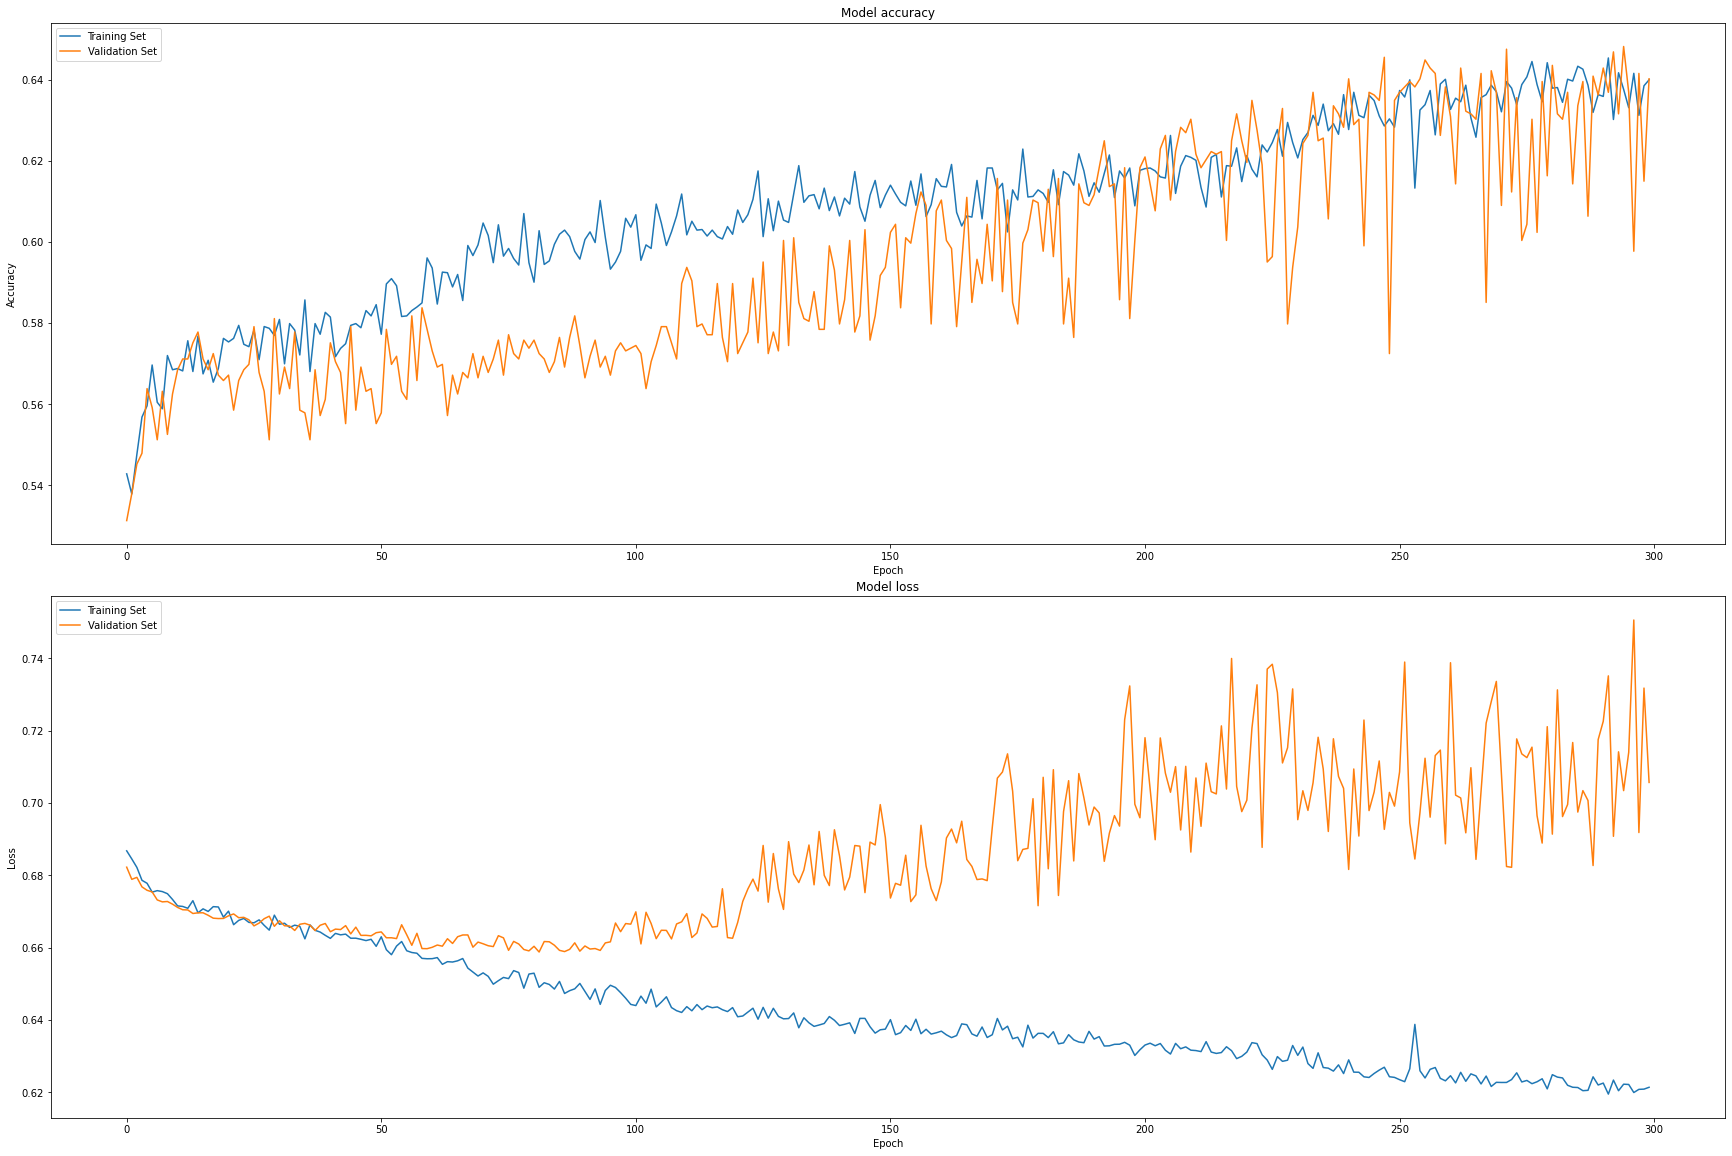

In [9]:
plot_history(history)

In [30]:
# load model from checkpoints
model1_checkpoint = tf.keras.models.load_model('model_checkpoints/model1/ckpt_200')
callbacks_continue = create_callbacks('model_checkpoints/model1/', 'epoch', 5)

history_continue = model1_checkpoint.fit(X_train, y_train,
                    validation_data=(X_validate, y_validate),
                    epochs=300,
                    batch_size=25,
                    callbacks=callbacks_continue,
                    initial_epoch=200
                    # validation_steps=1,
                    # validation_batch_size=1504
                    # class_weight=class_weight
                    )

Epoch 201/300


KeyboardInterrupt: 

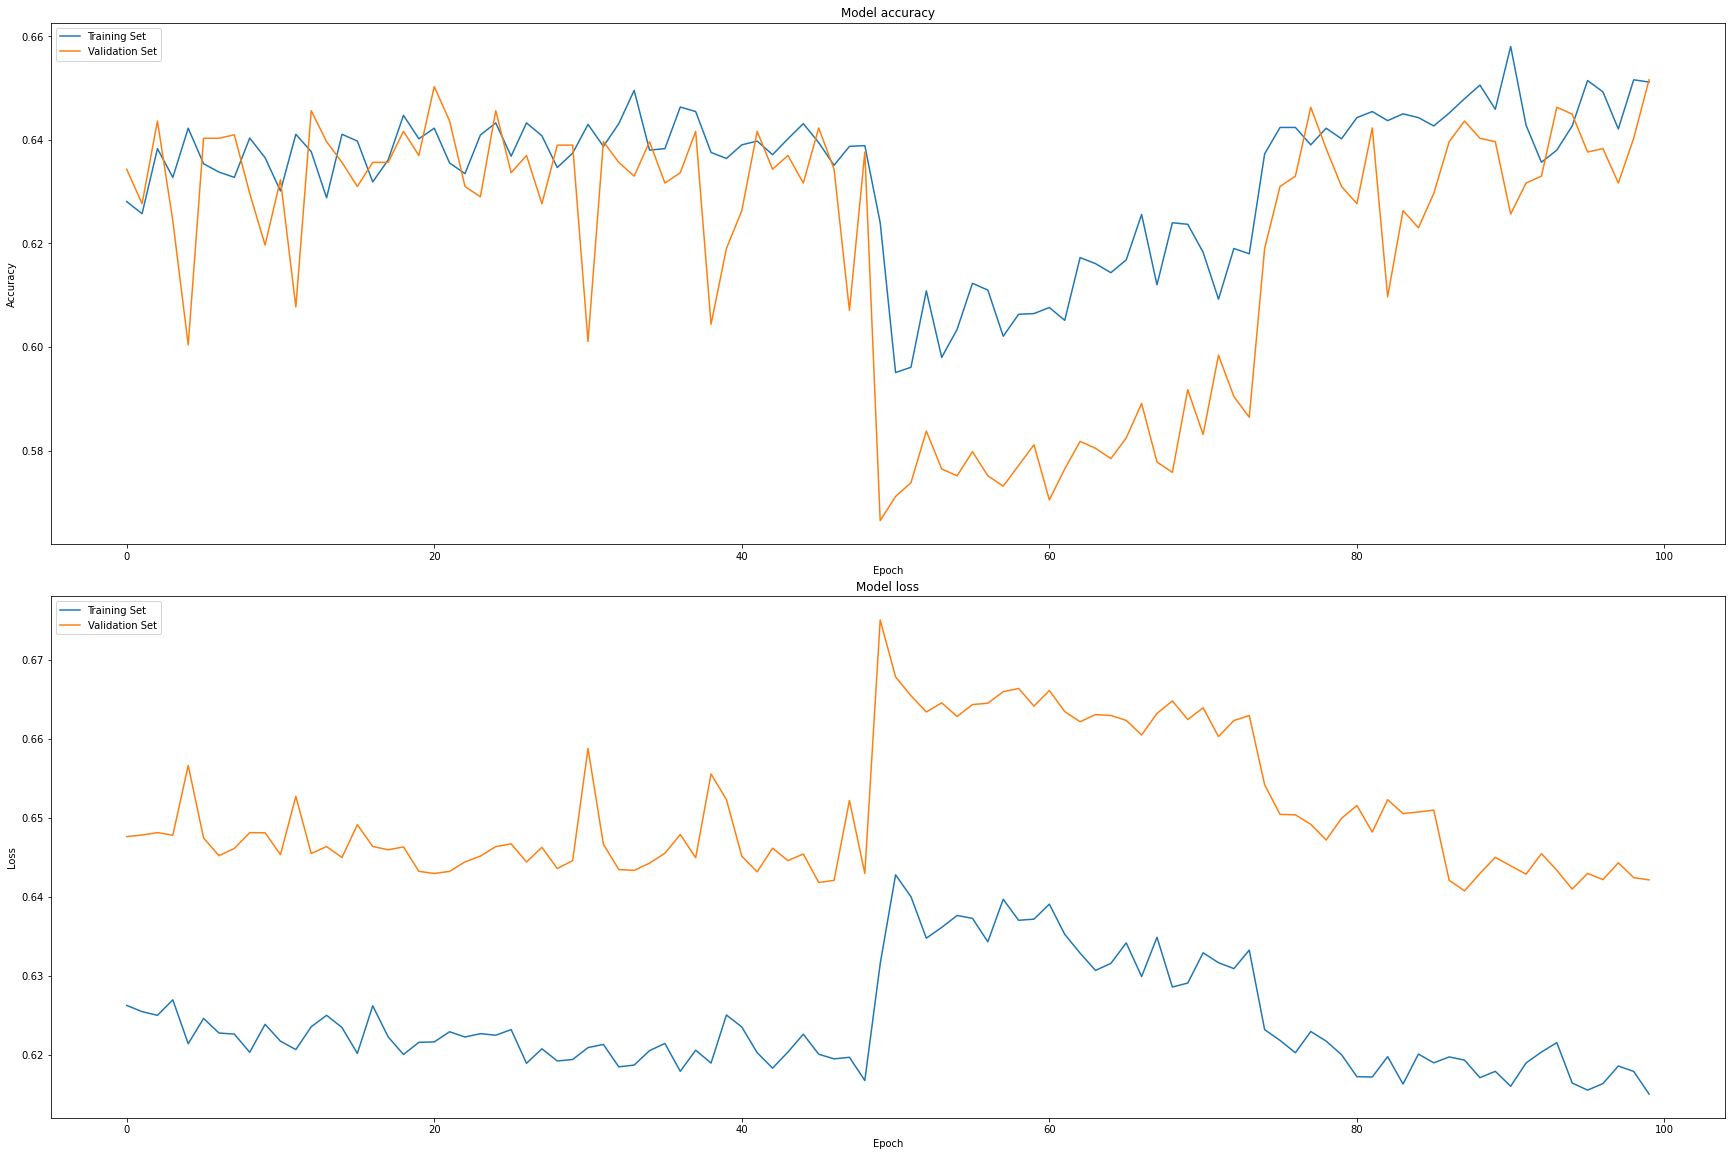

In [10]:
plot_history(history_continue)

In [10]:
y_predict_probs = model.predict(X_test)
print(y_predict_probs)

# Convert probabilities to binary predictions using a threshold of 0.5
y_predict = np.round(y_predict_probs)
print(y_predict)

49/49 [==============================] - 0s 1ms/step
[[0.25467876]
 [0.5118077 ]
 [0.44372195]
 ...
 [0.7252548 ]
 [0.00127088]
 [0.49901158]]
[[0.]
 [1.]
 [0.]
 ...
 [1.]
 [0.]
 [0.]]


[[537 246]
 [335 448]]


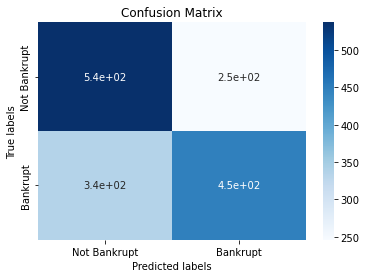

In [11]:
cm = confusion_matrix(y_test, y_predict)
print(cm)
plot_cm(cm)

In [16]:
# Calculate F1 score, precision, recall

f1 = f1_score(y_test, y_predict)
precision1 = precision_score(y_test, y_predict)
recall1 = recall_score(y_test, y_predict)

print("F1 score: {:.2f}".format(f1))
print("precision: {:.2}".format(precision1))
print("recall: {:.2}".format(recall1))

F1 score: 0.61
precision: 0.65
recall: 0.57


## Model 2

In [62]:
def bankruptcy_model_v2(input_shape=(18,)):
    # Define the normalization layer
    # normalization_layer = tf.keras.layers.experimental.preprocessing.Normalization()

    # # Adapt the normalization layer to the data
    # data = tf.ones((1, 18))
    # normalization_layer(data)

    # Define the model
    model = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.Normalization(),
        tf.keras.layers.Dense(18, activation='relu', input_shape=input_shape),
        # tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(9, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer, 
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
                )
    return model


In [63]:
model2 = bankruptcy_model_v2()
callbacks2 = create_callbacks('model_checkpoints/model2', 'epoch', 5)
history2 = model2.fit(X_train, y_train,
                    validation_data=(X_validate, y_validate),
                    epochs=100,
                    batch_size=25,
                    callbacks=callbacks2
                    # callbacks=callbacks,
                    # class_weight=class_weight
                    )

Epoch 1/100
274/274 [==============================] - 2s 3ms/step - loss: 1363.0588 - accuracy: 0.5470 - precision_1: 0.5295 - recall_1: 0.8914 - val_loss: 148.9259 - val_accuracy: 0.5578 - val_precision_1: 0.5315 - val_recall_1: 0.6328
Epoch 2/100
274/274 [==============================] - 1s 2ms/step - loss: 111.4397 - accuracy: 0.5470 - precision_1: 0.5520 - recall_1: 0.5270 - val_loss: 114.5644 - val_accuracy: 0.5532 - val_precision_1: 0.5332 - val_recall_1: 0.5243
Epoch 3/100
274/274 [==============================] - 1s 2ms/step - loss: 97.3184 - accuracy: 0.5502 - precision_1: 0.5549 - recall_1: 0.5346 - val_loss: 101.3003 - val_accuracy: 0.5632 - val_precision_1: 0.5438 - val_recall_1: 0.5355
Epoch 4/100
274/274 [==============================] - 1s 2ms/step - loss: 88.0179 - accuracy: 0.5466 - precision_1: 0.5508 - recall_1: 0.5340 - val_loss: 90.7572 - val_accuracy: 0.5652 - val_precision_1: 0.5445 - val_recall_1: 0.5535
Epoch 5/100
268/274 [============================>.] -

INFO:tensorflow:Assets written to: model_checkpoints/model2/ckpt_5/assets


INFO:tensorflow:Assets written to: model_checkpoints/model2/ckpt_5/assets


274/274 [==============================] - 1s 5ms/step - loss: 80.3503 - accuracy: 0.5507 - precision_1: 0.5551 - recall_1: 0.5372 - val_loss: 81.9518 - val_accuracy: 0.5479 - val_precision_1: 0.5319 - val_recall_1: 0.4520
Epoch 6/100
274/274 [==============================] - 1s 2ms/step - loss: 74.8521 - accuracy: 0.5533 - precision_1: 0.5577 - recall_1: 0.5407 - val_loss: 75.2277 - val_accuracy: 0.5685 - val_precision_1: 0.5392 - val_recall_1: 0.6690
Epoch 7/100
274/274 [==============================] - 1s 2ms/step - loss: 68.4931 - accuracy: 0.5521 - precision_1: 0.5563 - recall_1: 0.5412 - val_loss: 66.4831 - val_accuracy: 0.5658 - val_precision_1: 0.5442 - val_recall_1: 0.5647
Epoch 8/100
274/274 [==============================] - 1s 2ms/step - loss: 63.5282 - accuracy: 0.5622 - precision_1: 0.5671 - recall_1: 0.5470 - val_loss: 60.7087 - val_accuracy: 0.5758 - val_precision_1: 0.5457 - val_recall_1: 0.6732
Epoch 9/100
274/274 [==============================] - 1s 2ms/step - los

INFO:tensorflow:Assets written to: model_checkpoints/model2/ckpt_10/assets


INFO:tensorflow:Assets written to: model_checkpoints/model2/ckpt_10/assets


274/274 [==============================] - 1s 5ms/step - loss: 52.9762 - accuracy: 0.5581 - precision_1: 0.5628 - recall_1: 0.5438 - val_loss: 48.7624 - val_accuracy: 0.5545 - val_precision_1: 0.5351 - val_recall_1: 0.5202
Epoch 11/100
274/274 [==============================] - 1s 2ms/step - loss: 49.4719 - accuracy: 0.5679 - precision_1: 0.5722 - recall_1: 0.5581 - val_loss: 44.3135 - val_accuracy: 0.5758 - val_precision_1: 0.6015 - val_recall_1: 0.3338
Epoch 12/100
274/274 [==============================] - 1s 2ms/step - loss: 44.4885 - accuracy: 0.5662 - precision_1: 0.5710 - recall_1: 0.5523 - val_loss: 42.5200 - val_accuracy: 0.5691 - val_precision_1: 0.5362 - val_recall_1: 0.7316
Epoch 13/100
274/274 [==============================] - 1s 2ms/step - loss: 41.7081 - accuracy: 0.5637 - precision_1: 0.5678 - recall_1: 0.5546 - val_loss: 38.5201 - val_accuracy: 0.5785 - val_precision_1: 0.5508 - val_recall_1: 0.6412
Epoch 14/100
274/274 [==============================] - 1s 2ms/step -

INFO:tensorflow:Assets written to: model_checkpoints/model2/ckpt_15/assets


INFO:tensorflow:Assets written to: model_checkpoints/model2/ckpt_15/assets


274/274 [==============================] - 1s 5ms/step - loss: 34.6537 - accuracy: 0.5635 - precision_1: 0.5674 - recall_1: 0.5560 - val_loss: 32.5027 - val_accuracy: 0.5638 - val_precision_1: 0.5456 - val_recall_1: 0.5243
Epoch 16/100
274/274 [==============================] - 1s 2ms/step - loss: 31.6146 - accuracy: 0.5746 - precision_1: 0.5789 - recall_1: 0.5659 - val_loss: 29.4624 - val_accuracy: 0.5778 - val_precision_1: 0.5478 - val_recall_1: 0.6690
Epoch 17/100
274/274 [==============================] - 1s 2ms/step - loss: 29.5277 - accuracy: 0.5656 - precision_1: 0.5697 - recall_1: 0.5563 - val_loss: 27.3755 - val_accuracy: 0.5718 - val_precision_1: 0.5403 - val_recall_1: 0.6996
Epoch 18/100
274/274 [==============================] - 1s 2ms/step - loss: 26.7797 - accuracy: 0.5678 - precision_1: 0.5717 - recall_1: 0.5601 - val_loss: 25.3743 - val_accuracy: 0.5672 - val_precision_1: 0.5335 - val_recall_1: 0.7524
Epoch 19/100
274/274 [==============================] - 1s 2ms/step -

INFO:tensorflow:Assets written to: model_checkpoints/model2/ckpt_20/assets


INFO:tensorflow:Assets written to: model_checkpoints/model2/ckpt_20/assets


274/274 [==============================] - 2s 6ms/step - loss: 24.0654 - accuracy: 0.5605 - precision_1: 0.5644 - recall_1: 0.5523 - val_loss: 25.0383 - val_accuracy: 0.5592 - val_precision_1: 0.5247 - val_recall_1: 0.8261
Epoch 21/100
274/274 [==============================] - 1s 2ms/step - loss: 22.3903 - accuracy: 0.5532 - precision_1: 0.5560 - recall_1: 0.5537 - val_loss: 21.6979 - val_accuracy: 0.5605 - val_precision_1: 0.5277 - val_recall_1: 0.7691
Epoch 22/100
274/274 [==============================] - 1s 2ms/step - loss: 20.8452 - accuracy: 0.5580 - precision_1: 0.5617 - recall_1: 0.5511 - val_loss: 19.5697 - val_accuracy: 0.5605 - val_precision_1: 0.5285 - val_recall_1: 0.7469
Epoch 23/100
274/274 [==============================] - 1s 2ms/step - loss: 19.8760 - accuracy: 0.5494 - precision_1: 0.5523 - recall_1: 0.5491 - val_loss: 23.0471 - val_accuracy: 0.5485 - val_precision_1: 0.5163 - val_recall_1: 0.8790
Epoch 24/100
274/274 [==============================] - 1s 2ms/step -

INFO:tensorflow:Assets written to: model_checkpoints/model2/ckpt_25/assets


INFO:tensorflow:Assets written to: model_checkpoints/model2/ckpt_25/assets


274/274 [==============================] - 1s 5ms/step - loss: 18.0393 - accuracy: 0.5524 - precision_1: 0.5545 - recall_1: 0.5595 - val_loss: 16.9514 - val_accuracy: 0.5818 - val_precision_1: 0.5974 - val_recall_1: 0.3839
Epoch 26/100
274/274 [==============================] - 1s 2ms/step - loss: 17.1260 - accuracy: 0.5562 - precision_1: 0.5591 - recall_1: 0.5560 - val_loss: 16.3588 - val_accuracy: 0.5778 - val_precision_1: 0.5775 - val_recall_1: 0.4353
Epoch 27/100
274/274 [==============================] - 1s 2ms/step - loss: 16.3302 - accuracy: 0.5670 - precision_1: 0.5699 - recall_1: 0.5668 - val_loss: 15.6983 - val_accuracy: 0.5652 - val_precision_1: 0.5427 - val_recall_1: 0.5744
Epoch 28/100
274/274 [==============================] - 1s 2ms/step - loss: 15.2082 - accuracy: 0.5697 - precision_1: 0.5728 - recall_1: 0.5677 - val_loss: 16.0350 - val_accuracy: 0.5758 - val_precision_1: 0.6098 - val_recall_1: 0.3129
Epoch 29/100
274/274 [==============================] - 1s 2ms/step -

INFO:tensorflow:Assets written to: model_checkpoints/model2/ckpt_30/assets


INFO:tensorflow:Assets written to: model_checkpoints/model2/ckpt_30/assets


274/274 [==============================] - 1s 5ms/step - loss: 13.9094 - accuracy: 0.5594 - precision_1: 0.5621 - recall_1: 0.5610 - val_loss: 14.3761 - val_accuracy: 0.5645 - val_precision_1: 0.5444 - val_recall_1: 0.5452
Epoch 31/100
274/274 [==============================] - 1s 2ms/step - loss: 13.4623 - accuracy: 0.5699 - precision_1: 0.5736 - recall_1: 0.5645 - val_loss: 16.8162 - val_accuracy: 0.5645 - val_precision_1: 0.6441 - val_recall_1: 0.1989
Epoch 32/100
274/274 [==============================] - 1s 2ms/step - loss: 13.2555 - accuracy: 0.5689 - precision_1: 0.5724 - recall_1: 0.5648 - val_loss: 14.2236 - val_accuracy: 0.5765 - val_precision_1: 0.6158 - val_recall_1: 0.3032
Epoch 33/100
274/274 [==============================] - 1s 2ms/step - loss: 12.6992 - accuracy: 0.5612 - precision_1: 0.5648 - recall_1: 0.5552 - val_loss: 13.8781 - val_accuracy: 0.5578 - val_precision_1: 0.5234 - val_recall_1: 0.8414
Epoch 34/100
274/274 [==============================] - 1s 2ms/step -

INFO:tensorflow:Assets written to: model_checkpoints/model2/ckpt_35/assets


INFO:tensorflow:Assets written to: model_checkpoints/model2/ckpt_35/assets


274/274 [==============================] - 1s 5ms/step - loss: 11.4118 - accuracy: 0.5695 - precision_1: 0.5727 - recall_1: 0.5671 - val_loss: 12.5801 - val_accuracy: 0.5711 - val_precision_1: 0.5395 - val_recall_1: 0.7024
Epoch 36/100
274/274 [==============================] - 1s 2ms/step - loss: 11.5243 - accuracy: 0.5663 - precision_1: 0.5710 - recall_1: 0.5534 - val_loss: 13.5758 - val_accuracy: 0.5519 - val_precision_1: 0.5189 - val_recall_1: 0.8609
Epoch 37/100
274/274 [==============================] - 1s 2ms/step - loss: 10.9903 - accuracy: 0.5808 - precision_1: 0.5850 - recall_1: 0.5723 - val_loss: 12.3177 - val_accuracy: 0.5818 - val_precision_1: 0.6380 - val_recall_1: 0.2893
Epoch 38/100
274/274 [==============================] - 1s 2ms/step - loss: 10.2909 - accuracy: 0.5609 - precision_1: 0.5642 - recall_1: 0.5575 - val_loss: 12.2355 - val_accuracy: 0.5798 - val_precision_1: 0.6537 - val_recall_1: 0.2573
Epoch 39/100
274/274 [==============================] - 1s 2ms/step -

INFO:tensorflow:Assets written to: model_checkpoints/model2/ckpt_40/assets


INFO:tensorflow:Assets written to: model_checkpoints/model2/ckpt_40/assets


274/274 [==============================] - 1s 5ms/step - loss: 10.0875 - accuracy: 0.5656 - precision_1: 0.5683 - recall_1: 0.5662 - val_loss: 14.4389 - val_accuracy: 0.5572 - val_precision_1: 0.6992 - val_recall_1: 0.1293
Epoch 41/100
274/274 [==============================] - 1s 2ms/step - loss: 9.7142 - accuracy: 0.5724 - precision_1: 0.5765 - recall_1: 0.5648 - val_loss: 10.9974 - val_accuracy: 0.5851 - val_precision_1: 0.6035 - val_recall_1: 0.3853
Epoch 42/100
274/274 [==============================] - 1s 2ms/step - loss: 9.6321 - accuracy: 0.5545 - precision_1: 0.5583 - recall_1: 0.5467 - val_loss: 11.5183 - val_accuracy: 0.5512 - val_precision_1: 0.5176 - val_recall_1: 0.9013
Epoch 43/100
274/274 [==============================] - 1s 2ms/step - loss: 9.0516 - accuracy: 0.5663 - precision_1: 0.5695 - recall_1: 0.5642 - val_loss: 11.1338 - val_accuracy: 0.5818 - val_precision_1: 0.6585 - val_recall_1: 0.2601
Epoch 44/100
274/274 [==============================] - 1s 2ms/step - lo

INFO:tensorflow:Assets written to: model_checkpoints/model2/ckpt_45/assets


INFO:tensorflow:Assets written to: model_checkpoints/model2/ckpt_45/assets


274/274 [==============================] - 1s 5ms/step - loss: 8.5339 - accuracy: 0.5739 - precision_1: 0.5784 - recall_1: 0.5633 - val_loss: 11.8456 - val_accuracy: 0.5691 - val_precision_1: 0.6898 - val_recall_1: 0.1794
Epoch 46/100
274/274 [==============================] - 1s 2ms/step - loss: 8.3274 - accuracy: 0.5707 - precision_1: 0.5760 - recall_1: 0.5546 - val_loss: 10.5387 - val_accuracy: 0.5445 - val_precision_1: 0.5138 - val_recall_1: 0.8818
Epoch 47/100
274/274 [==============================] - 1s 2ms/step - loss: 8.0473 - accuracy: 0.5707 - precision_1: 0.5756 - recall_1: 0.5572 - val_loss: 10.8525 - val_accuracy: 0.5419 - val_precision_1: 0.5119 - val_recall_1: 0.8971
Epoch 48/100
274/274 [==============================] - 1s 2ms/step - loss: 7.9179 - accuracy: 0.5645 - precision_1: 0.5682 - recall_1: 0.5587 - val_loss: 16.2867 - val_accuracy: 0.5312 - val_precision_1: 0.5053 - val_recall_1: 0.9305
Epoch 49/100
274/274 [==============================] - 1s 2ms/step - los

INFO:tensorflow:Assets written to: model_checkpoints/model2/ckpt_50/assets


INFO:tensorflow:Assets written to: model_checkpoints/model2/ckpt_50/assets


274/274 [==============================] - 1s 5ms/step - loss: 7.7499 - accuracy: 0.5555 - precision_1: 0.5586 - recall_1: 0.5534 - val_loss: 9.2102 - val_accuracy: 0.5918 - val_precision_1: 0.6804 - val_recall_1: 0.2754
Epoch 51/100
274/274 [==============================] - 1s 2ms/step - loss: 7.1583 - accuracy: 0.5567 - precision_1: 0.5608 - recall_1: 0.5467 - val_loss: 9.2276 - val_accuracy: 0.5818 - val_precision_1: 0.6406 - val_recall_1: 0.2851
Epoch 52/100
274/274 [==============================] - 1s 2ms/step - loss: 7.1504 - accuracy: 0.5733 - precision_1: 0.5760 - recall_1: 0.5740 - val_loss: 10.6962 - val_accuracy: 0.5372 - val_precision_1: 0.5086 - val_recall_1: 0.9458
Epoch 53/100
274/274 [==============================] - 1s 2ms/step - loss: 7.1536 - accuracy: 0.5625 - precision_1: 0.5660 - recall_1: 0.5578 - val_loss: 9.4535 - val_accuracy: 0.5844 - val_precision_1: 0.7098 - val_recall_1: 0.2211
Epoch 54/100
274/274 [==============================] - 1s 2ms/step - loss: 

INFO:tensorflow:Assets written to: model_checkpoints/model2/ckpt_55/assets


INFO:tensorflow:Assets written to: model_checkpoints/model2/ckpt_55/assets


274/274 [==============================] - 1s 5ms/step - loss: 6.4766 - accuracy: 0.5600 - precision_1: 0.5627 - recall_1: 0.5616 - val_loss: 8.9172 - val_accuracy: 0.5725 - val_precision_1: 0.7568 - val_recall_1: 0.1558
Epoch 56/100
274/274 [==============================] - 1s 2ms/step - loss: 6.3335 - accuracy: 0.5765 - precision_1: 0.5795 - recall_1: 0.5755 - val_loss: 8.6063 - val_accuracy: 0.5738 - val_precision_1: 0.6291 - val_recall_1: 0.2643
Epoch 57/100
274/274 [==============================] - 1s 2ms/step - loss: 6.2449 - accuracy: 0.5628 - precision_1: 0.5656 - recall_1: 0.5636 - val_loss: 8.2960 - val_accuracy: 0.5858 - val_precision_1: 0.5600 - val_recall_1: 0.6231
Epoch 58/100
274/274 [==============================] - 1s 2ms/step - loss: 6.1735 - accuracy: 0.5683 - precision_1: 0.5704 - recall_1: 0.5743 - val_loss: 9.4927 - val_accuracy: 0.5352 - val_precision_1: 0.5075 - val_recall_1: 0.9416
Epoch 59/100
274/274 [==============================] - 1s 2ms/step - loss: 5

INFO:tensorflow:Assets written to: model_checkpoints/model2/ckpt_60/assets


INFO:tensorflow:Assets written to: model_checkpoints/model2/ckpt_60/assets


274/274 [==============================] - 2s 6ms/step - loss: 6.1622 - accuracy: 0.5552 - precision_1: 0.5587 - recall_1: 0.5502 - val_loss: 8.0546 - val_accuracy: 0.5805 - val_precision_1: 0.5692 - val_recall_1: 0.5035
Epoch 61/100
274/274 [==============================] - 1s 2ms/step - loss: 5.8027 - accuracy: 0.5555 - precision_1: 0.5583 - recall_1: 0.5557 - val_loss: 8.3682 - val_accuracy: 0.5751 - val_precision_1: 0.6835 - val_recall_1: 0.2072
Epoch 62/100
274/274 [==============================] - 1s 2ms/step - loss: 5.8072 - accuracy: 0.5524 - precision_1: 0.5548 - recall_1: 0.5569 - val_loss: 10.0659 - val_accuracy: 0.5565 - val_precision_1: 0.7167 - val_recall_1: 0.1196
Epoch 63/100
274/274 [==============================] - 1s 2ms/step - loss: 5.8175 - accuracy: 0.5587 - precision_1: 0.5617 - recall_1: 0.5581 - val_loss: 8.3725 - val_accuracy: 0.5479 - val_precision_1: 0.5166 - val_recall_1: 0.8428
Epoch 64/100
274/274 [==============================] - 1s 2ms/step - loss: 

INFO:tensorflow:Assets written to: model_checkpoints/model2/ckpt_65/assets


INFO:tensorflow:Assets written to: model_checkpoints/model2/ckpt_65/assets


274/274 [==============================] - 1s 5ms/step - loss: 5.8739 - accuracy: 0.5640 - precision_1: 0.5661 - recall_1: 0.5694 - val_loss: 9.1851 - val_accuracy: 0.5539 - val_precision_1: 0.7000 - val_recall_1: 0.1168
Epoch 66/100
274/274 [==============================] - 1s 2ms/step - loss: 5.2964 - accuracy: 0.5619 - precision_1: 0.5649 - recall_1: 0.5610 - val_loss: 7.4267 - val_accuracy: 0.5499 - val_precision_1: 0.5176 - val_recall_1: 0.8609
Epoch 67/100
274/274 [==============================] - 1s 2ms/step - loss: 5.1262 - accuracy: 0.5645 - precision_1: 0.5660 - recall_1: 0.5755 - val_loss: 7.7392 - val_accuracy: 0.5399 - val_precision_1: 0.5103 - val_recall_1: 0.9318
Epoch 68/100
274/274 [==============================] - 1s 2ms/step - loss: 4.9861 - accuracy: 0.5583 - precision_1: 0.5603 - recall_1: 0.5653 - val_loss: 7.4003 - val_accuracy: 0.5884 - val_precision_1: 0.6923 - val_recall_1: 0.2503
Epoch 69/100
274/274 [==============================] - 1s 2ms/step - loss: 5

INFO:tensorflow:Assets written to: model_checkpoints/model2/ckpt_70/assets


INFO:tensorflow:Assets written to: model_checkpoints/model2/ckpt_70/assets


274/274 [==============================] - 1s 5ms/step - loss: 5.3983 - accuracy: 0.5558 - precision_1: 0.5576 - recall_1: 0.5648 - val_loss: 7.7233 - val_accuracy: 0.5818 - val_precision_1: 0.6772 - val_recall_1: 0.2392
Epoch 71/100
274/274 [==============================] - 1s 2ms/step - loss: 5.0499 - accuracy: 0.5590 - precision_1: 0.5613 - recall_1: 0.5636 - val_loss: 7.3437 - val_accuracy: 0.5831 - val_precision_1: 0.6456 - val_recall_1: 0.2837
Epoch 72/100
274/274 [==============================] - 1s 2ms/step - loss: 5.0925 - accuracy: 0.5607 - precision_1: 0.5644 - recall_1: 0.5546 - val_loss: 7.1736 - val_accuracy: 0.5918 - val_precision_1: 0.5822 - val_recall_1: 0.5174
Epoch 73/100
274/274 [==============================] - 1s 2ms/step - loss: 5.5334 - accuracy: 0.5537 - precision_1: 0.5558 - recall_1: 0.5607 - val_loss: 7.8949 - val_accuracy: 0.5525 - val_precision_1: 0.7255 - val_recall_1: 0.1029
Epoch 74/100
274/274 [==============================] - 1s 2ms/step - loss: 4

INFO:tensorflow:Assets written to: model_checkpoints/model2/ckpt_75/assets


INFO:tensorflow:Assets written to: model_checkpoints/model2/ckpt_75/assets


274/274 [==============================] - 1s 5ms/step - loss: 4.9034 - accuracy: 0.5701 - precision_1: 0.5714 - recall_1: 0.5810 - val_loss: 7.5896 - val_accuracy: 0.5691 - val_precision_1: 0.7448 - val_recall_1: 0.1502
Epoch 76/100
274/274 [==============================] - 1s 2ms/step - loss: 4.8350 - accuracy: 0.5567 - precision_1: 0.5580 - recall_1: 0.5703 - val_loss: 7.1735 - val_accuracy: 0.5246 - val_precision_1: 0.5015 - val_recall_1: 0.9458
Epoch 77/100
274/274 [==============================] - 1s 2ms/step - loss: 4.7892 - accuracy: 0.5571 - precision_1: 0.5595 - recall_1: 0.5613 - val_loss: 6.8576 - val_accuracy: 0.5532 - val_precision_1: 0.5196 - val_recall_1: 0.8665
Epoch 78/100
274/274 [==============================] - 1s 2ms/step - loss: 4.2521 - accuracy: 0.5699 - precision_1: 0.5701 - recall_1: 0.5891 - val_loss: 6.8663 - val_accuracy: 0.5838 - val_precision_1: 0.7163 - val_recall_1: 0.2142
Epoch 79/100
274/274 [==============================] - 1s 2ms/step - loss: 4

INFO:tensorflow:Assets written to: model_checkpoints/model2/ckpt_80/assets


INFO:tensorflow:Assets written to: model_checkpoints/model2/ckpt_80/assets


274/274 [==============================] - 1s 5ms/step - loss: 4.5663 - accuracy: 0.5645 - precision_1: 0.5659 - recall_1: 0.5761 - val_loss: 8.4407 - val_accuracy: 0.5392 - val_precision_1: 0.6585 - val_recall_1: 0.0751
Epoch 81/100
274/274 [==============================] - 1s 2ms/step - loss: 4.6817 - accuracy: 0.5521 - precision_1: 0.5546 - recall_1: 0.5560 - val_loss: 7.7725 - val_accuracy: 0.5293 - val_precision_1: 0.5041 - val_recall_1: 0.9430
Epoch 82/100
274/274 [==============================] - 1s 2ms/step - loss: 4.6975 - accuracy: 0.5602 - precision_1: 0.5630 - recall_1: 0.5601 - val_loss: 6.9795 - val_accuracy: 0.5858 - val_precision_1: 0.6655 - val_recall_1: 0.2684
Epoch 83/100
274/274 [==============================] - 1s 2ms/step - loss: 4.3322 - accuracy: 0.5530 - precision_1: 0.5549 - recall_1: 0.5616 - val_loss: 6.8526 - val_accuracy: 0.5539 - val_precision_1: 0.5198 - val_recall_1: 0.8748
Epoch 84/100
274/274 [==============================] - 1s 2ms/step - loss: 4

INFO:tensorflow:Assets written to: model_checkpoints/model2/ckpt_85/assets


INFO:tensorflow:Assets written to: model_checkpoints/model2/ckpt_85/assets


274/274 [==============================] - 1s 5ms/step - loss: 4.4047 - accuracy: 0.5622 - precision_1: 0.5653 - recall_1: 0.5604 - val_loss: 6.4939 - val_accuracy: 0.5505 - val_precision_1: 0.5170 - val_recall_1: 0.9082
Epoch 86/100
274/274 [==============================] - 1s 2ms/step - loss: 4.0263 - accuracy: 0.5609 - precision_1: 0.5610 - recall_1: 0.5836 - val_loss: 9.0843 - val_accuracy: 0.5386 - val_precision_1: 0.6623 - val_recall_1: 0.0709
Epoch 87/100
274/274 [==============================] - 1s 2ms/step - loss: 4.0412 - accuracy: 0.5532 - precision_1: 0.5545 - recall_1: 0.5677 - val_loss: 7.5167 - val_accuracy: 0.5519 - val_precision_1: 0.7064 - val_recall_1: 0.1071
Epoch 88/100
274/274 [==============================] - 1s 2ms/step - loss: 3.9755 - accuracy: 0.5605 - precision_1: 0.5621 - recall_1: 0.5703 - val_loss: 7.1097 - val_accuracy: 0.5745 - val_precision_1: 0.7310 - val_recall_1: 0.1739
Epoch 89/100
274/274 [==============================] - 1s 2ms/step - loss: 3

INFO:tensorflow:Assets written to: model_checkpoints/model2/ckpt_90/assets


INFO:tensorflow:Assets written to: model_checkpoints/model2/ckpt_90/assets


274/274 [==============================] - 1s 5ms/step - loss: 4.2370 - accuracy: 0.5537 - precision_1: 0.5548 - recall_1: 0.5706 - val_loss: 6.4727 - val_accuracy: 0.5625 - val_precision_1: 0.5267 - val_recall_1: 0.8359
Epoch 91/100
274/274 [==============================] - 1s 2ms/step - loss: 4.2204 - accuracy: 0.5486 - precision_1: 0.5501 - recall_1: 0.5630 - val_loss: 6.6500 - val_accuracy: 0.5539 - val_precision_1: 0.5203 - val_recall_1: 0.8554
Epoch 92/100
274/274 [==============================] - 1s 2ms/step - loss: 3.8095 - accuracy: 0.5565 - precision_1: 0.5570 - recall_1: 0.5775 - val_loss: 6.9122 - val_accuracy: 0.5565 - val_precision_1: 0.6940 - val_recall_1: 0.1293
Epoch 93/100
274/274 [==============================] - 1s 2ms/step - loss: 3.6197 - accuracy: 0.5571 - precision_1: 0.5565 - recall_1: 0.5874 - val_loss: 6.3035 - val_accuracy: 0.5605 - val_precision_1: 0.5287 - val_recall_1: 0.7427
Epoch 94/100
274/274 [==============================] - 1s 2ms/step - loss: 3

INFO:tensorflow:Assets written to: model_checkpoints/model2/ckpt_95/assets


INFO:tensorflow:Assets written to: model_checkpoints/model2/ckpt_95/assets


274/274 [==============================] - 1s 5ms/step - loss: 3.8376 - accuracy: 0.5527 - precision_1: 0.5540 - recall_1: 0.5679 - val_loss: 6.3300 - val_accuracy: 0.5805 - val_precision_1: 0.6128 - val_recall_1: 0.3324
Epoch 96/100
274/274 [==============================] - 1s 2ms/step - loss: 4.0814 - accuracy: 0.5533 - precision_1: 0.5553 - recall_1: 0.5616 - val_loss: 5.9870 - val_accuracy: 0.5592 - val_precision_1: 0.5226 - val_recall_1: 0.8999
Epoch 97/100
274/274 [==============================] - 1s 2ms/step - loss: 3.5515 - accuracy: 0.5615 - precision_1: 0.5623 - recall_1: 0.5778 - val_loss: 7.6658 - val_accuracy: 0.5372 - val_precision_1: 0.5090 - val_recall_1: 0.9026
Epoch 98/100
274/274 [==============================] - 1s 2ms/step - loss: 3.6672 - accuracy: 0.5568 - precision_1: 0.5586 - recall_1: 0.5662 - val_loss: 7.0531 - val_accuracy: 0.5392 - val_precision_1: 0.5103 - val_recall_1: 0.8929
Epoch 99/100
274/274 [==============================] - 1s 2ms/step - loss: 4

INFO:tensorflow:Assets written to: model_checkpoints/model2/ckpt_100/assets


INFO:tensorflow:Assets written to: model_checkpoints/model2/ckpt_100/assets


274/274 [==============================] - 1s 5ms/step - loss: 3.7570 - accuracy: 0.5586 - precision_1: 0.5605 - recall_1: 0.5662 - val_loss: 6.1302 - val_accuracy: 0.5672 - val_precision_1: 0.5298 - val_recall_1: 0.8414


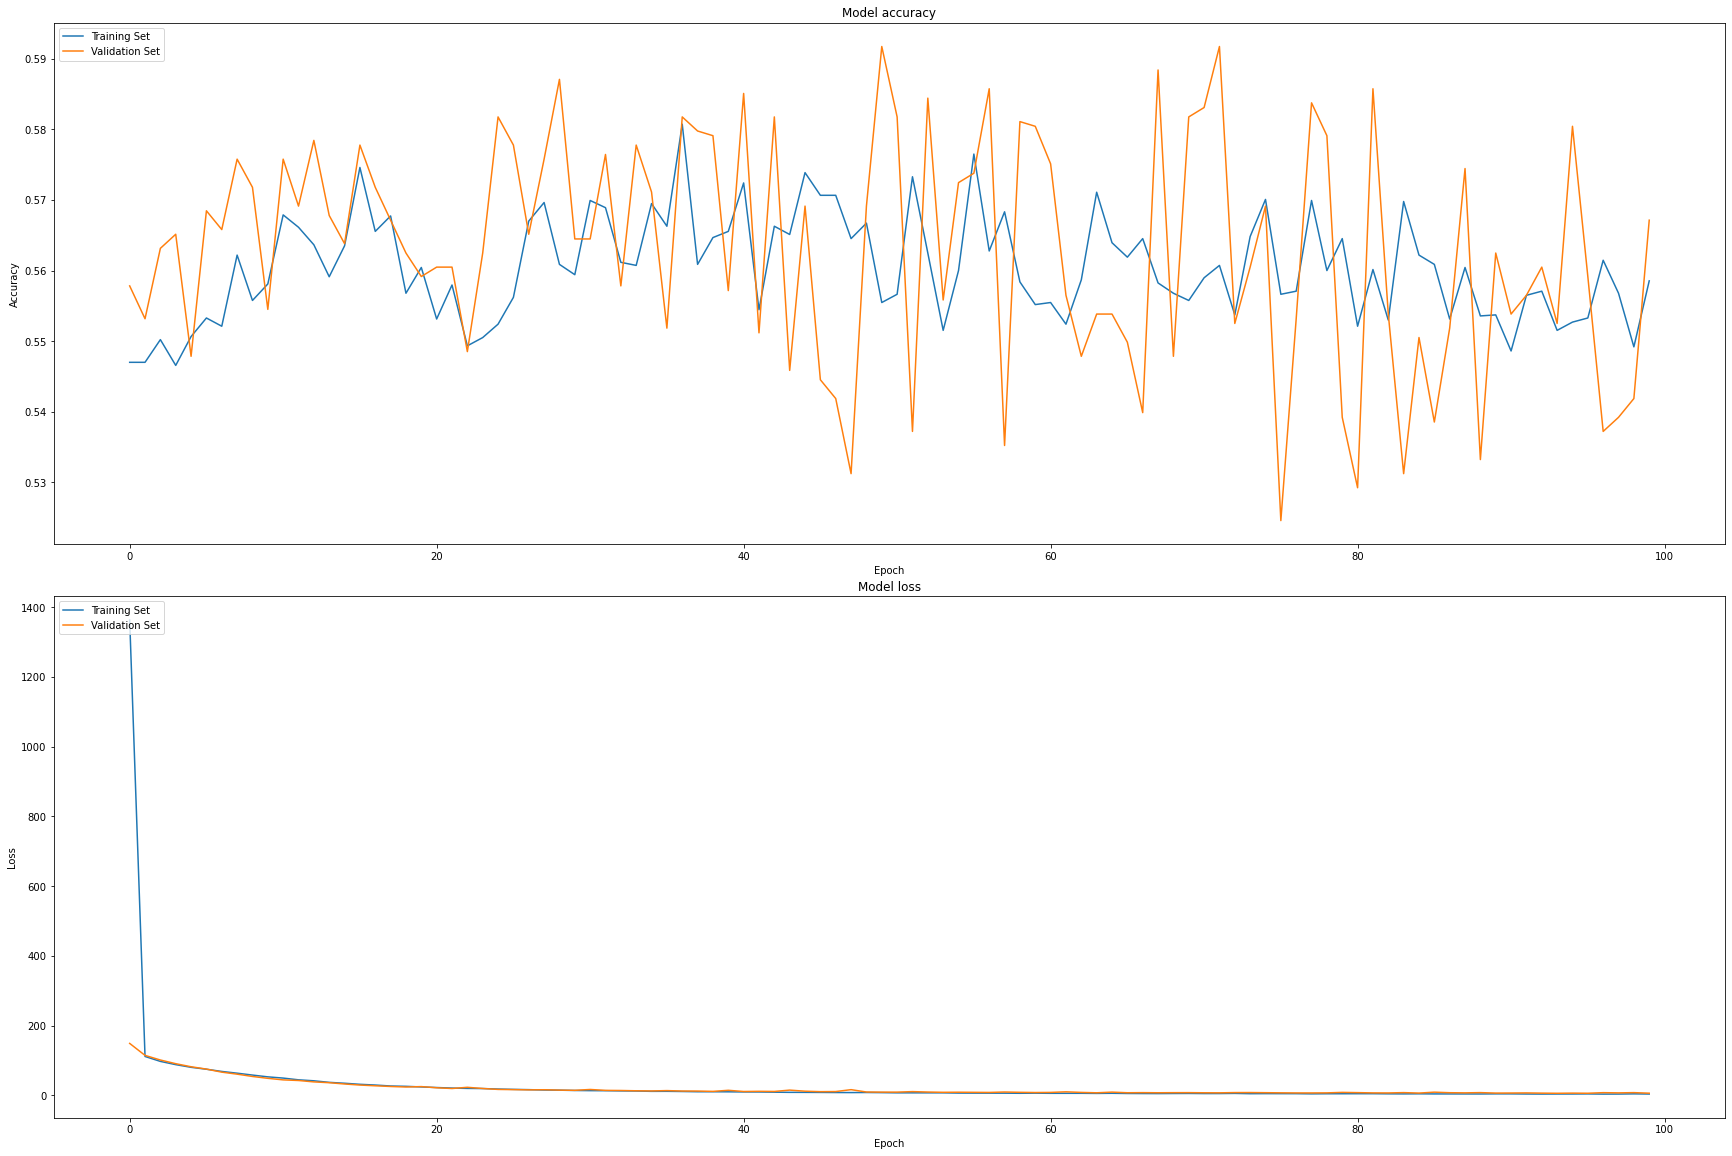

In [64]:
plot_history(history2)

In [17]:
y_predict_probs2 = model2.predict(X_test)
y_predict2 = np.round(y_predict_probs2)

NameError: name 'model2' is not defined

[[679 106]
 [639 142]]


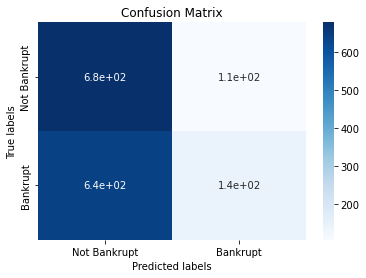

F1 score: 0.28


In [52]:
# plot confusion matrix
cm_2 = confusion_matrix(y_test, y_predict2)
print(cm_2)
plot_cm(cm_2)

# Calculate F1 score
f1 = f1_score(y_test, y_predict2)
print("F1 score: {:.2f}".format(f1))

## Model 3

In [9]:
y_hot_train = tf.one_hot(y_train, 2)
y_hot_val = tf.one_hot(y_validate, 2)
y_hot_test = tf.one_hot(y_test, 2)

In [20]:
def binary_classification_model(input_shape=(18,)):
    
    model = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.Normalization(),
        tf.keras.layers.Dense(20, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy']
                )
    
    return model

In [21]:
model3 = binary_classification_model()
callbacks3 = create_callbacks('model_checkpoints/model3/', 'epoch', 5)
history3 = model3.fit(X_train, y_hot_train,
                    validation_data=(X_validate, y_hot_val),
                    epochs=100,
                    batch_size=24,
                    callbacks=callbacks3,
                    # class_weight=class_weight
                    )

Epoch 1/100
286/286 [==============================] - 2s 3ms/step - loss: 13608.2012 - accuracy: 0.5228 - val_loss: 10924.4404 - val_accuracy: 0.4980
Epoch 2/100
286/286 [==============================] - 1s 2ms/step - loss: 9318.4561 - accuracy: 0.5339 - val_loss: 7177.2671 - val_accuracy: 0.5100
Epoch 3/100
286/286 [==============================] - 1s 2ms/step - loss: 5784.2393 - accuracy: 0.5337 - val_loss: 4090.5164 - val_accuracy: 0.5033
Epoch 4/100
286/286 [==============================] - 1s 2ms/step - loss: 2931.2698 - accuracy: 0.5228 - val_loss: 1610.0902 - val_accuracy: 0.4973
Epoch 5/100
263/286 [==========================>...] - ETA: 0s - loss: 845.8348 - accuracy: 0.5170

INFO:tensorflow:Assets written to: model_checkpoints/model3/ckpt_5/assets


INFO:tensorflow:Assets written to: model_checkpoints/model3/ckpt_5/assets


286/286 [==============================] - 1s 5ms/step - loss: 792.5808 - accuracy: 0.5104 - val_loss: 127.6420 - val_accuracy: 0.5233
Epoch 6/100
286/286 [==============================] - 1s 2ms/step - loss: 47.9010 - accuracy: 0.5073 - val_loss: 14.6130 - val_accuracy: 0.5080
Epoch 7/100
286/286 [==============================] - 1s 3ms/step - loss: 12.7141 - accuracy: 0.5327 - val_loss: 9.1856 - val_accuracy: 0.5193
Epoch 8/100
286/286 [==============================] - 1s 2ms/step - loss: 8.8694 - accuracy: 0.5327 - val_loss: 7.2578 - val_accuracy: 0.5186
Epoch 9/100
286/286 [==============================] - 1s 2ms/step - loss: 6.9202 - accuracy: 0.5296 - val_loss: 6.0378 - val_accuracy: 0.5126
Epoch 10/100
268/286 [===========================>..] - ETA: 0s - loss: 5.4067 - accuracy: 0.5294

INFO:tensorflow:Assets written to: model_checkpoints/model3/ckpt_10/assets


INFO:tensorflow:Assets written to: model_checkpoints/model3/ckpt_10/assets


286/286 [==============================] - 1s 5ms/step - loss: 5.6587 - accuracy: 0.5289 - val_loss: 5.2866 - val_accuracy: 0.5113
Epoch 11/100
286/286 [==============================] - 1s 2ms/step - loss: 4.8573 - accuracy: 0.5276 - val_loss: 4.7384 - val_accuracy: 0.5086
Epoch 12/100
286/286 [==============================] - 1s 2ms/step - loss: 4.2374 - accuracy: 0.5288 - val_loss: 4.3145 - val_accuracy: 0.5086
Epoch 13/100
286/286 [==============================] - 1s 2ms/step - loss: 3.8522 - accuracy: 0.5253 - val_loss: 4.0527 - val_accuracy: 0.5080
Epoch 14/100
286/286 [==============================] - 1s 2ms/step - loss: 3.5637 - accuracy: 0.5256 - val_loss: 3.8562 - val_accuracy: 0.5053
Epoch 15/100
256/286 [=========================>....] - ETA: 0s - loss: 3.1472 - accuracy: 0.5238

INFO:tensorflow:Assets written to: model_checkpoints/model3/ckpt_15/assets


INFO:tensorflow:Assets written to: model_checkpoints/model3/ckpt_15/assets


286/286 [==============================] - 1s 5ms/step - loss: 3.3328 - accuracy: 0.5238 - val_loss: 3.4856 - val_accuracy: 0.5053
Epoch 16/100
286/286 [==============================] - 1s 2ms/step - loss: 3.0645 - accuracy: 0.5235 - val_loss: 3.2054 - val_accuracy: 0.5033
Epoch 17/100
286/286 [==============================] - 0s 2ms/step - loss: 2.8815 - accuracy: 0.5231 - val_loss: 2.9804 - val_accuracy: 0.5053
Epoch 18/100
286/286 [==============================] - 0s 2ms/step - loss: 2.6877 - accuracy: 0.5234 - val_loss: 2.8198 - val_accuracy: 0.5020
Epoch 19/100
286/286 [==============================] - 1s 2ms/step - loss: 2.5273 - accuracy: 0.5232 - val_loss: 2.6215 - val_accuracy: 0.5000
Epoch 20/100
266/286 [==========================>...] - ETA: 0s - loss: 2.4211 - accuracy: 0.5238

INFO:tensorflow:Assets written to: model_checkpoints/model3/ckpt_20/assets


INFO:tensorflow:Assets written to: model_checkpoints/model3/ckpt_20/assets


286/286 [==============================] - 2s 6ms/step - loss: 2.3800 - accuracy: 0.5225 - val_loss: 2.4361 - val_accuracy: 0.4993
Epoch 21/100
286/286 [==============================] - 0s 2ms/step - loss: 2.2047 - accuracy: 0.5222 - val_loss: 2.2469 - val_accuracy: 0.5000
Epoch 22/100
286/286 [==============================] - 0s 2ms/step - loss: 2.0796 - accuracy: 0.5221 - val_loss: 2.0901 - val_accuracy: 0.4987
Epoch 23/100
286/286 [==============================] - 0s 2ms/step - loss: 1.9752 - accuracy: 0.5204 - val_loss: 1.8914 - val_accuracy: 0.5000
Epoch 24/100
286/286 [==============================] - 0s 2ms/step - loss: 1.8645 - accuracy: 0.5207 - val_loss: 1.7859 - val_accuracy: 0.4947
Epoch 25/100
260/286 [==========================>...] - ETA: 0s - loss: 1.5596 - accuracy: 0.5232

INFO:tensorflow:Assets written to: model_checkpoints/model3/ckpt_25/assets


INFO:tensorflow:Assets written to: model_checkpoints/model3/ckpt_25/assets


286/286 [==============================] - 2s 6ms/step - loss: 1.7584 - accuracy: 0.5206 - val_loss: 1.6804 - val_accuracy: 0.4920
Epoch 26/100
286/286 [==============================] - 1s 2ms/step - loss: 1.6735 - accuracy: 0.5191 - val_loss: 1.5689 - val_accuracy: 0.4907
Epoch 27/100
286/286 [==============================] - 1s 2ms/step - loss: 1.4990 - accuracy: 0.5181 - val_loss: 1.4319 - val_accuracy: 0.4900
Epoch 28/100
286/286 [==============================] - 1s 2ms/step - loss: 1.3495 - accuracy: 0.5165 - val_loss: 1.2881 - val_accuracy: 0.4900
Epoch 29/100
286/286 [==============================] - 1s 2ms/step - loss: 1.2470 - accuracy: 0.5158 - val_loss: 1.2392 - val_accuracy: 0.4894
Epoch 30/100
279/286 [============================>.] - ETA: 0s - loss: 1.1801 - accuracy: 0.5166

INFO:tensorflow:Assets written to: model_checkpoints/model3/ckpt_30/assets


INFO:tensorflow:Assets written to: model_checkpoints/model3/ckpt_30/assets


286/286 [==============================] - 1s 5ms/step - loss: 1.1997 - accuracy: 0.5153 - val_loss: 1.2484 - val_accuracy: 0.4907
Epoch 31/100
286/286 [==============================] - 1s 2ms/step - loss: 1.1138 - accuracy: 0.5140 - val_loss: 1.1528 - val_accuracy: 0.4907
Epoch 32/100
286/286 [==============================] - 0s 2ms/step - loss: 1.0666 - accuracy: 0.5145 - val_loss: 1.1586 - val_accuracy: 0.4894
Epoch 33/100
286/286 [==============================] - 0s 2ms/step - loss: 1.0289 - accuracy: 0.5134 - val_loss: 1.1447 - val_accuracy: 0.4900
Epoch 34/100
286/286 [==============================] - 1s 2ms/step - loss: 0.9805 - accuracy: 0.5131 - val_loss: 1.1030 - val_accuracy: 0.4907
Epoch 35/100
265/286 [==========================>...] - ETA: 0s - loss: 0.8459 - accuracy: 0.5149

INFO:tensorflow:Assets written to: model_checkpoints/model3/ckpt_35/assets


INFO:tensorflow:Assets written to: model_checkpoints/model3/ckpt_35/assets


286/286 [==============================] - 1s 5ms/step - loss: 0.9667 - accuracy: 0.5129 - val_loss: 1.1337 - val_accuracy: 0.4914
Epoch 36/100
286/286 [==============================] - 1s 2ms/step - loss: 0.9476 - accuracy: 0.5123 - val_loss: 1.0908 - val_accuracy: 0.4894
Epoch 37/100
286/286 [==============================] - 1s 2ms/step - loss: 0.9380 - accuracy: 0.5129 - val_loss: 1.0760 - val_accuracy: 0.4887
Epoch 38/100
286/286 [==============================] - 1s 2ms/step - loss: 0.9170 - accuracy: 0.5121 - val_loss: 1.0923 - val_accuracy: 0.4887
Epoch 39/100
286/286 [==============================] - 1s 2ms/step - loss: 0.9077 - accuracy: 0.5121 - val_loss: 1.0873 - val_accuracy: 0.4894
Epoch 40/100
257/286 [=========================>....] - ETA: 0s - loss: 0.9234 - accuracy: 0.5115

INFO:tensorflow:Assets written to: model_checkpoints/model3/ckpt_40/assets


INFO:tensorflow:Assets written to: model_checkpoints/model3/ckpt_40/assets


286/286 [==============================] - 1s 4ms/step - loss: 0.9014 - accuracy: 0.5118 - val_loss: 1.0946 - val_accuracy: 0.4894
Epoch 41/100
286/286 [==============================] - 0s 2ms/step - loss: 0.8938 - accuracy: 0.5115 - val_loss: 1.0955 - val_accuracy: 0.4900
Epoch 42/100
286/286 [==============================] - 1s 2ms/step - loss: 0.8969 - accuracy: 0.5120 - val_loss: 1.0705 - val_accuracy: 0.4880
Epoch 43/100
286/286 [==============================] - 1s 2ms/step - loss: 0.8712 - accuracy: 0.5112 - val_loss: 1.0750 - val_accuracy: 0.4880
Epoch 44/100
286/286 [==============================] - 1s 2ms/step - loss: 0.8675 - accuracy: 0.5099 - val_loss: 1.0640 - val_accuracy: 0.4880
Epoch 45/100
258/286 [==========================>...] - ETA: 0s - loss: 0.8706 - accuracy: 0.5100

INFO:tensorflow:Assets written to: model_checkpoints/model3/ckpt_45/assets


INFO:tensorflow:Assets written to: model_checkpoints/model3/ckpt_45/assets


286/286 [==============================] - 1s 4ms/step - loss: 0.8543 - accuracy: 0.5105 - val_loss: 1.0598 - val_accuracy: 0.4880
Epoch 46/100
286/286 [==============================] - 1s 2ms/step - loss: 0.8398 - accuracy: 0.5101 - val_loss: 1.0581 - val_accuracy: 0.4880
Epoch 47/100
286/286 [==============================] - 1s 2ms/step - loss: 0.8245 - accuracy: 0.5111 - val_loss: 1.0833 - val_accuracy: 0.4894
Epoch 48/100
286/286 [==============================] - 1s 2ms/step - loss: 0.8383 - accuracy: 0.5101 - val_loss: 1.0639 - val_accuracy: 0.4880
Epoch 49/100
286/286 [==============================] - 1s 2ms/step - loss: 0.7988 - accuracy: 0.5101 - val_loss: 1.0598 - val_accuracy: 0.4880
Epoch 50/100
278/286 [============================>.] - ETA: 0s - loss: 0.7913 - accuracy: 0.5100

INFO:tensorflow:Assets written to: model_checkpoints/model3/ckpt_50/assets


INFO:tensorflow:Assets written to: model_checkpoints/model3/ckpt_50/assets


286/286 [==============================] - 2s 6ms/step - loss: 0.7947 - accuracy: 0.5108 - val_loss: 1.0768 - val_accuracy: 0.4900
Epoch 51/100
286/286 [==============================] - 1s 2ms/step - loss: 0.7951 - accuracy: 0.5104 - val_loss: 1.0603 - val_accuracy: 0.4880
Epoch 52/100
286/286 [==============================] - 1s 2ms/step - loss: 0.7852 - accuracy: 0.5111 - val_loss: 1.0522 - val_accuracy: 0.4880
Epoch 53/100
286/286 [==============================] - 1s 2ms/step - loss: 0.7798 - accuracy: 0.5108 - val_loss: 1.0630 - val_accuracy: 0.4874
Epoch 54/100
286/286 [==============================] - 1s 2ms/step - loss: 0.7690 - accuracy: 0.5108 - val_loss: 1.0634 - val_accuracy: 0.4894
Epoch 55/100
271/286 [===========================>..] - ETA: 0s - loss: 0.7925 - accuracy: 0.5091

INFO:tensorflow:Assets written to: model_checkpoints/model3/ckpt_55/assets


INFO:tensorflow:Assets written to: model_checkpoints/model3/ckpt_55/assets


286/286 [==============================] - 2s 5ms/step - loss: 0.7878 - accuracy: 0.5088 - val_loss: 1.0450 - val_accuracy: 0.4860
Epoch 56/100
286/286 [==============================] - 1s 2ms/step - loss: 0.7668 - accuracy: 0.5091 - val_loss: 1.0590 - val_accuracy: 0.4880
Epoch 57/100
286/286 [==============================] - 1s 2ms/step - loss: 0.7740 - accuracy: 0.5095 - val_loss: 1.0637 - val_accuracy: 0.4867
Epoch 58/100
286/286 [==============================] - 1s 2ms/step - loss: 0.7580 - accuracy: 0.5091 - val_loss: 1.0583 - val_accuracy: 0.4880
Epoch 59/100
286/286 [==============================] - 1s 2ms/step - loss: 0.7568 - accuracy: 0.5092 - val_loss: 1.0595 - val_accuracy: 0.4867
Epoch 60/100
274/286 [===========================>..] - ETA: 0s - loss: 0.7460 - accuracy: 0.5091

INFO:tensorflow:Assets written to: model_checkpoints/model3/ckpt_60/assets


INFO:tensorflow:Assets written to: model_checkpoints/model3/ckpt_60/assets


286/286 [==============================] - 1s 5ms/step - loss: 0.7439 - accuracy: 0.5086 - val_loss: 1.0736 - val_accuracy: 0.4867
Epoch 61/100
286/286 [==============================] - 1s 2ms/step - loss: 0.7579 - accuracy: 0.5085 - val_loss: 1.0707 - val_accuracy: 0.4860
Epoch 62/100
286/286 [==============================] - 1s 2ms/step - loss: 0.7506 - accuracy: 0.5085 - val_loss: 1.0419 - val_accuracy: 0.4860
Epoch 63/100
286/286 [==============================] - 1s 2ms/step - loss: 0.7444 - accuracy: 0.5077 - val_loss: 1.0377 - val_accuracy: 0.4860
Epoch 64/100
286/286 [==============================] - 1s 3ms/step - loss: 0.7340 - accuracy: 0.5088 - val_loss: 1.0620 - val_accuracy: 0.4867
Epoch 65/100
271/286 [===========================>..] - ETA: 0s - loss: 0.7550 - accuracy: 0.5097

INFO:tensorflow:Assets written to: model_checkpoints/model3/ckpt_65/assets


INFO:tensorflow:Assets written to: model_checkpoints/model3/ckpt_65/assets


286/286 [==============================] - 2s 6ms/step - loss: 0.7517 - accuracy: 0.5085 - val_loss: 1.0305 - val_accuracy: 0.4860
Epoch 66/100
286/286 [==============================] - 1s 2ms/step - loss: 0.7362 - accuracy: 0.5092 - val_loss: 1.0398 - val_accuracy: 0.4867
Epoch 67/100
286/286 [==============================] - 1s 2ms/step - loss: 0.7341 - accuracy: 0.5080 - val_loss: 1.0383 - val_accuracy: 0.4854
Epoch 68/100
286/286 [==============================] - 1s 2ms/step - loss: 0.7262 - accuracy: 0.5079 - val_loss: 1.0398 - val_accuracy: 0.4854
Epoch 69/100
286/286 [==============================] - 1s 2ms/step - loss: 0.7286 - accuracy: 0.5079 - val_loss: 1.0416 - val_accuracy: 0.4854
Epoch 70/100
255/286 [=========================>....] - ETA: 0s - loss: 0.7293 - accuracy: 0.5111

INFO:tensorflow:Assets written to: model_checkpoints/model3/ckpt_70/assets


INFO:tensorflow:Assets written to: model_checkpoints/model3/ckpt_70/assets


286/286 [==============================] - 1s 5ms/step - loss: 0.7309 - accuracy: 0.5085 - val_loss: 1.0314 - val_accuracy: 0.4867
Epoch 71/100
286/286 [==============================] - 1s 2ms/step - loss: 0.7186 - accuracy: 0.5089 - val_loss: 1.0983 - val_accuracy: 0.4860
Epoch 72/100
286/286 [==============================] - 1s 2ms/step - loss: 0.7292 - accuracy: 0.5067 - val_loss: 1.0279 - val_accuracy: 0.4860
Epoch 73/100
286/286 [==============================] - 1s 2ms/step - loss: 0.7248 - accuracy: 0.5070 - val_loss: 1.0234 - val_accuracy: 0.4867
Epoch 74/100
286/286 [==============================] - 0s 2ms/step - loss: 0.7234 - accuracy: 0.5079 - val_loss: 1.0216 - val_accuracy: 0.4860
Epoch 75/100
279/286 [============================>.] - ETA: 0s - loss: 0.7147 - accuracy: 0.5064

INFO:tensorflow:Assets written to: model_checkpoints/model3/ckpt_75/assets


INFO:tensorflow:Assets written to: model_checkpoints/model3/ckpt_75/assets


286/286 [==============================] - 1s 5ms/step - loss: 0.7141 - accuracy: 0.5082 - val_loss: 1.0386 - val_accuracy: 0.4854
Epoch 76/100
286/286 [==============================] - 1s 2ms/step - loss: 0.7175 - accuracy: 0.5072 - val_loss: 1.0183 - val_accuracy: 0.4860
Epoch 77/100
286/286 [==============================] - 1s 2ms/step - loss: 0.7093 - accuracy: 0.5077 - val_loss: 1.0248 - val_accuracy: 0.4854
Epoch 78/100
286/286 [==============================] - 0s 2ms/step - loss: 0.7070 - accuracy: 0.5072 - val_loss: 1.0519 - val_accuracy: 0.4840
Epoch 79/100
286/286 [==============================] - 0s 2ms/step - loss: 0.7146 - accuracy: 0.5066 - val_loss: 1.0209 - val_accuracy: 0.4840
Epoch 80/100
252/286 [=========================>....] - ETA: 0s - loss: 0.6905 - accuracy: 0.5121

INFO:tensorflow:Assets written to: model_checkpoints/model3/ckpt_80/assets


INFO:tensorflow:Assets written to: model_checkpoints/model3/ckpt_80/assets


286/286 [==============================] - 1s 4ms/step - loss: 0.6908 - accuracy: 0.5076 - val_loss: 1.0114 - val_accuracy: 0.4854
Epoch 81/100
286/286 [==============================] - 0s 2ms/step - loss: 0.7046 - accuracy: 0.5073 - val_loss: 1.0110 - val_accuracy: 0.4854
Epoch 82/100
286/286 [==============================] - 0s 2ms/step - loss: 0.6943 - accuracy: 0.5074 - val_loss: 1.0642 - val_accuracy: 0.4820
Epoch 83/100
286/286 [==============================] - 0s 2ms/step - loss: 0.7087 - accuracy: 0.5066 - val_loss: 1.0122 - val_accuracy: 0.4827
Epoch 84/100
286/286 [==============================] - 0s 2ms/step - loss: 0.6974 - accuracy: 0.5072 - val_loss: 1.0335 - val_accuracy: 0.4820
Epoch 85/100
260/286 [==========================>...] - ETA: 0s - loss: 0.6957 - accuracy: 0.5077

INFO:tensorflow:Assets written to: model_checkpoints/model3/ckpt_85/assets


INFO:tensorflow:Assets written to: model_checkpoints/model3/ckpt_85/assets


286/286 [==============================] - 1s 4ms/step - loss: 0.6953 - accuracy: 0.5067 - val_loss: 0.9995 - val_accuracy: 0.4847
Epoch 86/100
286/286 [==============================] - 0s 2ms/step - loss: 0.6904 - accuracy: 0.5072 - val_loss: 0.9993 - val_accuracy: 0.4847
Epoch 87/100
286/286 [==============================] - 1s 2ms/step - loss: 0.6903 - accuracy: 0.5073 - val_loss: 0.9991 - val_accuracy: 0.4847
Epoch 88/100
286/286 [==============================] - 0s 2ms/step - loss: 0.6901 - accuracy: 0.5073 - val_loss: 0.9995 - val_accuracy: 0.4847
Epoch 89/100
286/286 [==============================] - 0s 2ms/step - loss: 0.6898 - accuracy: 0.5073 - val_loss: 0.9989 - val_accuracy: 0.4847
Epoch 90/100
260/286 [==========================>...] - ETA: 0s - loss: 0.6899 - accuracy: 0.5071

INFO:tensorflow:Assets written to: model_checkpoints/model3/ckpt_90/assets


INFO:tensorflow:Assets written to: model_checkpoints/model3/ckpt_90/assets


286/286 [==============================] - 1s 4ms/step - loss: 0.6901 - accuracy: 0.5073 - val_loss: 1.0001 - val_accuracy: 0.4847
Epoch 91/100
286/286 [==============================] - 0s 2ms/step - loss: 0.6897 - accuracy: 0.5073 - val_loss: 0.9984 - val_accuracy: 0.4854
Epoch 92/100
286/286 [==============================] - 0s 2ms/step - loss: 0.6903 - accuracy: 0.5072 - val_loss: 0.9979 - val_accuracy: 0.4854
Epoch 93/100
286/286 [==============================] - 0s 2ms/step - loss: 0.6901 - accuracy: 0.5073 - val_loss: 0.9975 - val_accuracy: 0.4854
Epoch 94/100
286/286 [==============================] - 0s 2ms/step - loss: 0.6898 - accuracy: 0.5073 - val_loss: 0.9971 - val_accuracy: 0.4854
Epoch 95/100
253/286 [=========================>....] - ETA: 0s - loss: 0.6905 - accuracy: 0.5079

INFO:tensorflow:Assets written to: model_checkpoints/model3/ckpt_95/assets


INFO:tensorflow:Assets written to: model_checkpoints/model3/ckpt_95/assets


286/286 [==============================] - 1s 4ms/step - loss: 0.6904 - accuracy: 0.5073 - val_loss: 0.9967 - val_accuracy: 0.4854
Epoch 96/100
286/286 [==============================] - 0s 2ms/step - loss: 0.7169 - accuracy: 0.5066 - val_loss: 0.9835 - val_accuracy: 0.4847
Epoch 97/100
286/286 [==============================] - 0s 2ms/step - loss: 0.7013 - accuracy: 0.5070 - val_loss: 0.9880 - val_accuracy: 0.4847
Epoch 98/100
286/286 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.5073 - val_loss: 0.9777 - val_accuracy: 0.4854
Epoch 99/100
286/286 [==============================] - 1s 2ms/step - loss: 0.6892 - accuracy: 0.5074 - val_loss: 0.9778 - val_accuracy: 0.4854
Epoch 100/100
265/286 [==========================>...] - ETA: 0s - loss: 0.6893 - accuracy: 0.5080

INFO:tensorflow:Assets written to: model_checkpoints/model3/ckpt_100/assets


INFO:tensorflow:Assets written to: model_checkpoints/model3/ckpt_100/assets


286/286 [==============================] - 1s 5ms/step - loss: 0.6893 - accuracy: 0.5074 - val_loss: 0.9776 - val_accuracy: 0.4854


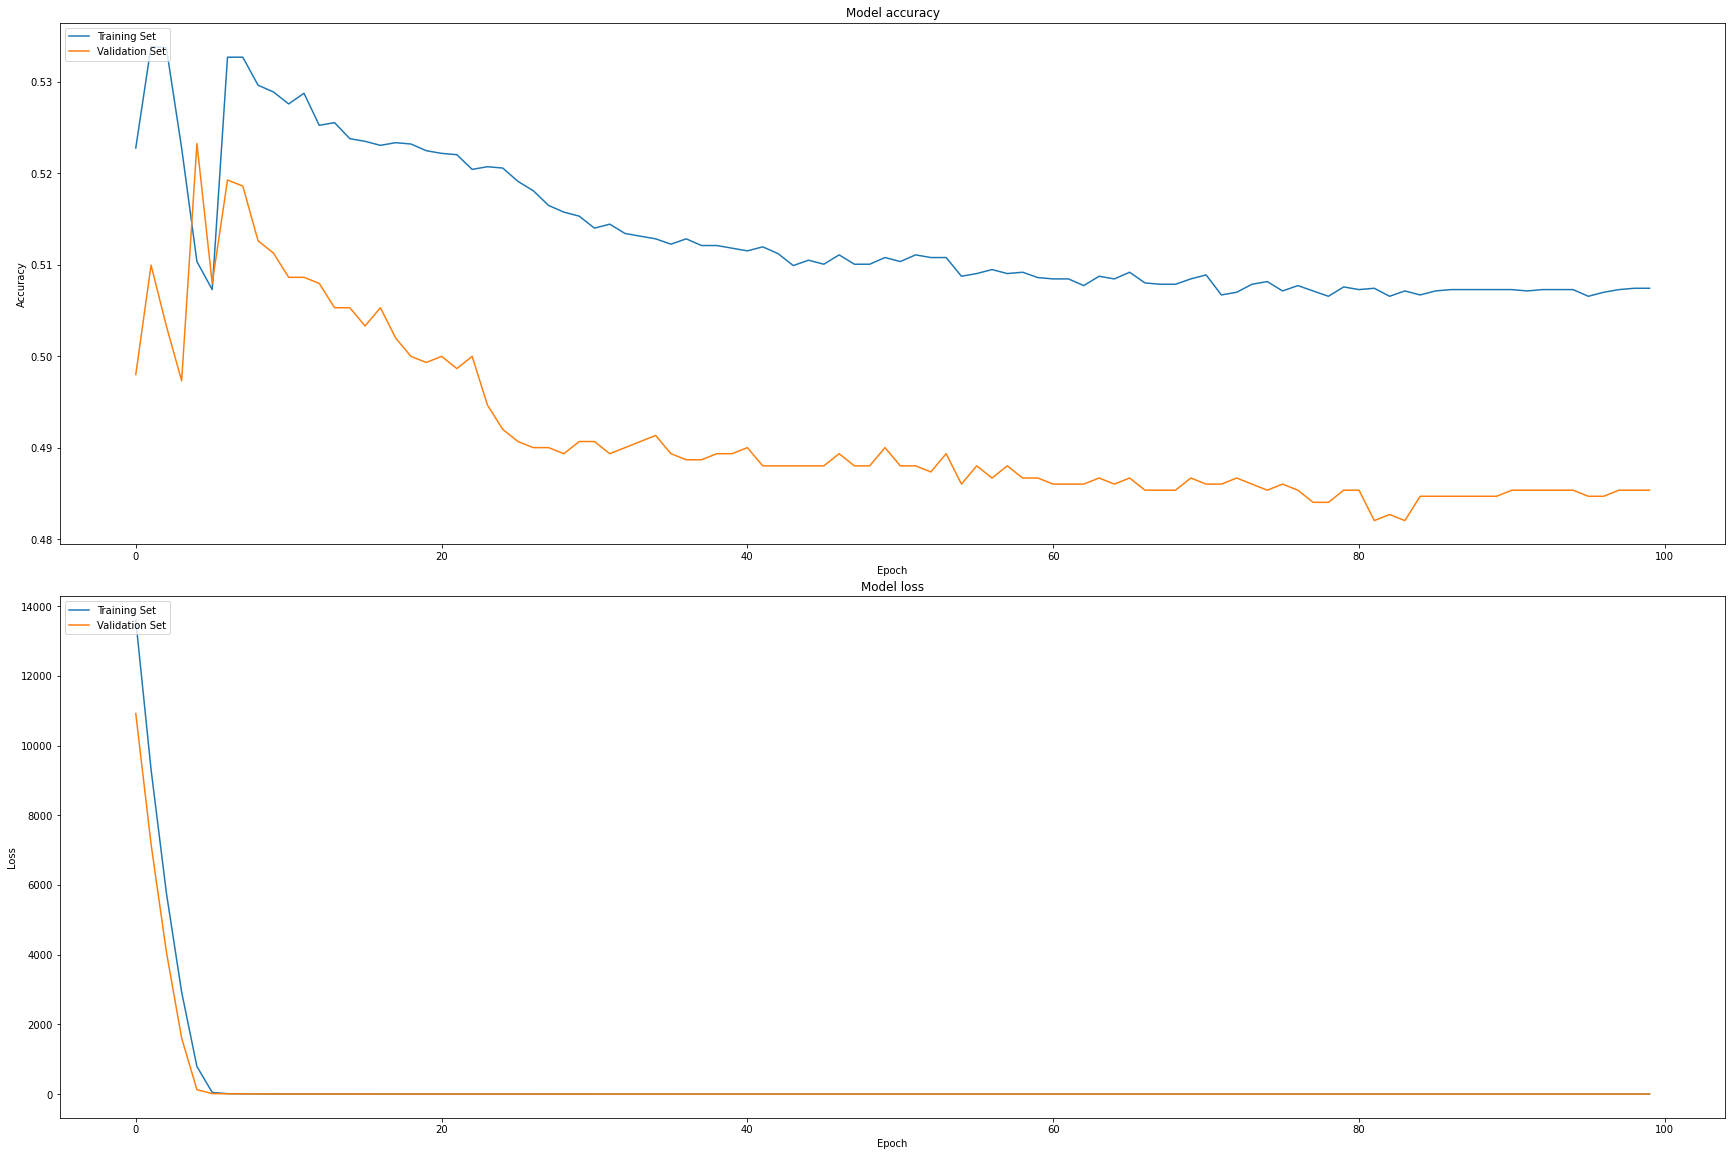

In [23]:
plot_history(history3)

In [25]:
y_predict_probs3 = model3.predict(X_test)
y_predict3 = np.round(y_predict_probs3)

49/49 [==============================] - 0s 2ms/step


In [26]:
num_classes = 2

# from lable to categorial
y_prediction = np.array([1,2]) 
y_categorial = tf.keras.utils.to_categorical(y_predict3, num_classes)

# from categorial to lable indexing
y_pred = y_categorial.argmax(1)

print(y_pred)

# plot confusion matrix
cm_3 = confusion_matrix(y_test, y_predict3)
print(cm_3)
plot_cm(cm_3)

# Calculate F1 score
f1 = f1_score(y_test, y_predict3)
print("F1 score: {:.2f}".format(f1))

ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets

In [41]:
# def binary_classification_model_4(input_shape=(18,)):
#     # create input layer
#     inputs = tf.keras.Input(shape=input_shape)
    
#     # create normalization layer
#     normalization = tf.keras.layers.experimental.preprocessing.Normalization()
#     x = normalization(inputs)
    
#     # create hidden layers
#     x = tf.keras.layers.Dense(18, activation='relu')(x)
#     x = tf.keras.layers.Dense(9, activation='relu')(x)
#     # create output layer
#     outputs = tf.keras.layers.Dense(1, activation='softmax')(x)
    
#     # create model
#     model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
#     # compile model
#     model.compile(optimizer='adam',
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])
    
#     return model

## Model 4 - Softmax

In [6]:
def binary_classification_model_4(input_shape=(18,)):
    
    model = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.Normalization(),
        tf.keras.layers.Dense(20, activation='relu'),
        # tf.keras.layers.BatchNormalization(),
        # tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(8, activation='relu'),
        # tf.keras.layers.BatchNormalization(),
        # tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2, activation='softmax'),
        # tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

    model.compile(optimizer,
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=6, monitor='val_loss')
    ]
    
    return model

In [28]:
model4 = binary_classification_model_4()
callbacks4 = create_callbacks('model_checkpoints/model4/', 'epoch', 5)
history4 = model4.fit(X_train, y_hot_train,
                    validation_data=(X_validate, y_hot_val),
                    epochs=100,
                    batch_size=24,
                    callbacks=callbacks4,
                    # class_weight=class_weight
                    )

Epoch 1/100
286/286 [==============================] - 2s 4ms/step - loss: 2003.1141 - accuracy: 0.5270 - val_loss: 1927.3868 - val_accuracy: 0.5020
Epoch 2/100
286/286 [==============================] - 1s 2ms/step - loss: 1800.5454 - accuracy: 0.5267 - val_loss: 1727.8577 - val_accuracy: 0.5013
Epoch 3/100
286/286 [==============================] - 1s 2ms/step - loss: 1600.3254 - accuracy: 0.5275 - val_loss: 1532.7919 - val_accuracy: 0.5013
Epoch 4/100
286/286 [==============================] - 1s 2ms/step - loss: 1406.3926 - accuracy: 0.5280 - val_loss: 1359.3712 - val_accuracy: 0.5013
Epoch 5/100
285/286 [============================>.] - ETA: 0s - loss: 1263.9735 - accuracy: 0.5282

INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_5/assets


INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_5/assets


286/286 [==============================] - 2s 5ms/step - loss: 1264.3502 - accuracy: 0.5282 - val_loss: 1240.0043 - val_accuracy: 0.5013
Epoch 6/100
286/286 [==============================] - 1s 2ms/step - loss: 1149.5712 - accuracy: 0.5292 - val_loss: 1126.6373 - val_accuracy: 0.5007
Epoch 7/100
286/286 [==============================] - 1s 2ms/step - loss: 1040.6035 - accuracy: 0.5301 - val_loss: 1019.2762 - val_accuracy: 0.5013
Epoch 8/100
286/286 [==============================] - 1s 2ms/step - loss: 936.6169 - accuracy: 0.5323 - val_loss: 916.0499 - val_accuracy: 0.5033
Epoch 9/100
286/286 [==============================] - 1s 2ms/step - loss: 837.3668 - accuracy: 0.5318 - val_loss: 817.8576 - val_accuracy: 0.5066
Epoch 10/100
276/286 [===========================>..] - ETA: 0s - loss: 745.9189 - accuracy: 0.5316

INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_10/assets


INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_10/assets


286/286 [==============================] - 1s 4ms/step - loss: 743.2041 - accuracy: 0.5333 - val_loss: 723.5297 - val_accuracy: 0.5073
Epoch 11/100
286/286 [==============================] - 1s 2ms/step - loss: 653.1195 - accuracy: 0.5350 - val_loss: 632.1416 - val_accuracy: 0.5086
Epoch 12/100
286/286 [==============================] - 1s 2ms/step - loss: 565.8909 - accuracy: 0.5365 - val_loss: 542.1518 - val_accuracy: 0.5073
Epoch 13/100
286/286 [==============================] - 1s 2ms/step - loss: 480.4513 - accuracy: 0.5374 - val_loss: 454.1281 - val_accuracy: 0.5093
Epoch 14/100
286/286 [==============================] - 1s 2ms/step - loss: 396.2762 - accuracy: 0.5378 - val_loss: 369.3828 - val_accuracy: 0.5100
Epoch 15/100
271/286 [===========================>..] - ETA: 0s - loss: 315.6251 - accuracy: 0.5361

INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_15/assets


INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_15/assets


286/286 [==============================] - 1s 5ms/step - loss: 314.3988 - accuracy: 0.5358 - val_loss: 287.2819 - val_accuracy: 0.5100
Epoch 16/100
286/286 [==============================] - 1s 2ms/step - loss: 236.2239 - accuracy: 0.5184 - val_loss: 214.5588 - val_accuracy: 0.4754
Epoch 17/100
286/286 [==============================] - 1s 2ms/step - loss: 197.8642 - accuracy: 0.4711 - val_loss: 206.6593 - val_accuracy: 0.4794
Epoch 18/100
286/286 [==============================] - 1s 2ms/step - loss: 190.2060 - accuracy: 0.4720 - val_loss: 199.0212 - val_accuracy: 0.4860
Epoch 19/100
286/286 [==============================] - 1s 2ms/step - loss: 182.7809 - accuracy: 0.4771 - val_loss: 191.8447 - val_accuracy: 0.4914
Epoch 20/100
272/286 [===========================>..] - ETA: 0s - loss: 174.4711 - accuracy: 0.4825

INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_20/assets


INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_20/assets


286/286 [==============================] - 1s 5ms/step - loss: 175.8226 - accuracy: 0.4825 - val_loss: 185.3605 - val_accuracy: 0.4834
Epoch 21/100
286/286 [==============================] - 1s 2ms/step - loss: 169.0624 - accuracy: 0.4904 - val_loss: 179.2330 - val_accuracy: 0.5053
Epoch 22/100
286/286 [==============================] - 1s 2ms/step - loss: 162.7308 - accuracy: 0.4950 - val_loss: 172.9660 - val_accuracy: 0.5047
Epoch 23/100
286/286 [==============================] - 1s 2ms/step - loss: 156.8965 - accuracy: 0.5000 - val_loss: 167.1483 - val_accuracy: 0.4874
Epoch 24/100
286/286 [==============================] - 1s 2ms/step - loss: 151.4011 - accuracy: 0.5007 - val_loss: 161.3869 - val_accuracy: 0.5086
Epoch 25/100
274/286 [===========================>..] - ETA: 0s - loss: 147.3656 - accuracy: 0.5088

INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_25/assets


INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_25/assets


286/286 [==============================] - 1s 4ms/step - loss: 146.5207 - accuracy: 0.5091 - val_loss: 156.1942 - val_accuracy: 0.5180
Epoch 26/100
286/286 [==============================] - 1s 2ms/step - loss: 141.9398 - accuracy: 0.5057 - val_loss: 151.1634 - val_accuracy: 0.5126
Epoch 27/100
286/286 [==============================] - 1s 2ms/step - loss: 137.5835 - accuracy: 0.5098 - val_loss: 146.4389 - val_accuracy: 0.5007
Epoch 28/100
286/286 [==============================] - 1s 2ms/step - loss: 133.5018 - accuracy: 0.5107 - val_loss: 141.6489 - val_accuracy: 0.5146
Epoch 29/100
286/286 [==============================] - 1s 2ms/step - loss: 129.4878 - accuracy: 0.5107 - val_loss: 137.1278 - val_accuracy: 0.5160
Epoch 30/100
267/286 [===========================>..] - ETA: 0s - loss: 124.5046 - accuracy: 0.5119

INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_30/assets


INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_30/assets


286/286 [==============================] - 1s 4ms/step - loss: 125.6958 - accuracy: 0.5127 - val_loss: 132.9483 - val_accuracy: 0.5206
Epoch 31/100
286/286 [==============================] - 1s 2ms/step - loss: 122.0207 - accuracy: 0.5134 - val_loss: 128.7796 - val_accuracy: 0.5140
Epoch 32/100
286/286 [==============================] - 1s 2ms/step - loss: 118.4364 - accuracy: 0.5115 - val_loss: 124.7605 - val_accuracy: 0.5100
Epoch 33/100
286/286 [==============================] - 1s 2ms/step - loss: 115.0215 - accuracy: 0.5120 - val_loss: 120.7832 - val_accuracy: 0.5186
Epoch 34/100
286/286 [==============================] - 1s 2ms/step - loss: 111.6826 - accuracy: 0.5139 - val_loss: 117.0697 - val_accuracy: 0.5066
Epoch 35/100
276/286 [===========================>..] - ETA: 0s - loss: 108.1788 - accuracy: 0.5171

INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_35/assets


INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_35/assets


286/286 [==============================] - 1s 4ms/step - loss: 108.3680 - accuracy: 0.5171 - val_loss: 113.5808 - val_accuracy: 0.5047
Epoch 36/100
286/286 [==============================] - 1s 2ms/step - loss: 105.2340 - accuracy: 0.5133 - val_loss: 110.0873 - val_accuracy: 0.5173
Epoch 37/100
286/286 [==============================] - 1s 2ms/step - loss: 102.2435 - accuracy: 0.5114 - val_loss: 107.0964 - val_accuracy: 0.5146
Epoch 38/100
286/286 [==============================] - 1s 2ms/step - loss: 99.3400 - accuracy: 0.5204 - val_loss: 104.1274 - val_accuracy: 0.5226
Epoch 39/100
286/286 [==============================] - 1s 2ms/step - loss: 96.5987 - accuracy: 0.5183 - val_loss: 101.2857 - val_accuracy: 0.5219
Epoch 40/100
278/286 [============================>.] - ETA: 0s - loss: 94.6991 - accuracy: 0.5163

INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_40/assets


INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_40/assets


286/286 [==============================] - 1s 5ms/step - loss: 93.9784 - accuracy: 0.5177 - val_loss: 98.4209 - val_accuracy: 0.5233
Epoch 41/100
286/286 [==============================] - 1s 2ms/step - loss: 91.4019 - accuracy: 0.5191 - val_loss: 95.6905 - val_accuracy: 0.5226
Epoch 42/100
286/286 [==============================] - 1s 2ms/step - loss: 88.9585 - accuracy: 0.5202 - val_loss: 93.3646 - val_accuracy: 0.5173
Epoch 43/100
286/286 [==============================] - 1s 2ms/step - loss: 86.6774 - accuracy: 0.5204 - val_loss: 90.9897 - val_accuracy: 0.5246
Epoch 44/100
286/286 [==============================] - 1s 2ms/step - loss: 84.5526 - accuracy: 0.5180 - val_loss: 88.7793 - val_accuracy: 0.5286
Epoch 45/100
271/286 [===========================>..] - ETA: 0s - loss: 82.8221 - accuracy: 0.5294

INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_45/assets


INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_45/assets


286/286 [==============================] - 2s 5ms/step - loss: 82.4592 - accuracy: 0.5258 - val_loss: 86.5881 - val_accuracy: 0.5279
Epoch 46/100
286/286 [==============================] - 1s 2ms/step - loss: 80.4988 - accuracy: 0.5216 - val_loss: 84.4670 - val_accuracy: 0.5312
Epoch 47/100
286/286 [==============================] - 1s 2ms/step - loss: 78.7288 - accuracy: 0.5269 - val_loss: 82.4103 - val_accuracy: 0.5253
Epoch 48/100
286/286 [==============================] - 1s 2ms/step - loss: 77.0361 - accuracy: 0.5244 - val_loss: 80.4816 - val_accuracy: 0.5259
Epoch 49/100
286/286 [==============================] - 1s 2ms/step - loss: 75.4830 - accuracy: 0.5272 - val_loss: 78.6174 - val_accuracy: 0.5299
Epoch 50/100
275/286 [===========================>..] - ETA: 0s - loss: 74.1925 - accuracy: 0.5252

INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_50/assets


INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_50/assets


286/286 [==============================] - 1s 4ms/step - loss: 73.9985 - accuracy: 0.5256 - val_loss: 76.8255 - val_accuracy: 0.5279
Epoch 51/100
286/286 [==============================] - 1s 2ms/step - loss: 72.5710 - accuracy: 0.5288 - val_loss: 75.0255 - val_accuracy: 0.5293
Epoch 52/100
286/286 [==============================] - 1s 2ms/step - loss: 71.2906 - accuracy: 0.5312 - val_loss: 73.3462 - val_accuracy: 0.5293
Epoch 53/100
286/286 [==============================] - 1s 2ms/step - loss: 70.0581 - accuracy: 0.5272 - val_loss: 71.7952 - val_accuracy: 0.5392
Epoch 54/100
286/286 [==============================] - 1s 2ms/step - loss: 68.8482 - accuracy: 0.5296 - val_loss: 70.1921 - val_accuracy: 0.5299
Epoch 55/100
266/286 [==========================>...] - ETA: 0s - loss: 67.9986 - accuracy: 0.5304

INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_55/assets


INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_55/assets


286/286 [==============================] - 1s 5ms/step - loss: 67.7031 - accuracy: 0.5296 - val_loss: 68.6652 - val_accuracy: 0.5306
Epoch 56/100
286/286 [==============================] - 1s 2ms/step - loss: 66.6189 - accuracy: 0.5333 - val_loss: 67.1656 - val_accuracy: 0.5226
Epoch 57/100
286/286 [==============================] - 1s 2ms/step - loss: 65.5619 - accuracy: 0.5317 - val_loss: 65.7757 - val_accuracy: 0.5306
Epoch 58/100
286/286 [==============================] - 1s 2ms/step - loss: 64.5435 - accuracy: 0.5324 - val_loss: 64.4667 - val_accuracy: 0.5346
Epoch 59/100
286/286 [==============================] - 1s 2ms/step - loss: 63.5874 - accuracy: 0.5312 - val_loss: 62.9574 - val_accuracy: 0.5359
Epoch 60/100
279/286 [============================>.] - ETA: 0s - loss: 62.6860 - accuracy: 0.5320

INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_60/assets


INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_60/assets


286/286 [==============================] - 1s 5ms/step - loss: 62.5959 - accuracy: 0.5324 - val_loss: 61.6901 - val_accuracy: 0.5359
Epoch 61/100
286/286 [==============================] - 1s 2ms/step - loss: 61.6246 - accuracy: 0.5334 - val_loss: 60.5210 - val_accuracy: 0.5273
Epoch 62/100
286/286 [==============================] - 1s 2ms/step - loss: 60.7242 - accuracy: 0.5333 - val_loss: 59.3266 - val_accuracy: 0.5452
Epoch 63/100
286/286 [==============================] - 1s 2ms/step - loss: 59.9019 - accuracy: 0.5321 - val_loss: 58.3062 - val_accuracy: 0.5379
Epoch 64/100
286/286 [==============================] - 1s 2ms/step - loss: 59.0830 - accuracy: 0.5327 - val_loss: 57.3208 - val_accuracy: 0.5326
Epoch 65/100
278/286 [============================>.] - ETA: 0s - loss: 58.6249 - accuracy: 0.5321

INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_65/assets


INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_65/assets


286/286 [==============================] - 1s 4ms/step - loss: 58.3556 - accuracy: 0.5321 - val_loss: 56.2986 - val_accuracy: 0.5379
Epoch 66/100
286/286 [==============================] - 1s 2ms/step - loss: 57.6035 - accuracy: 0.5321 - val_loss: 55.3986 - val_accuracy: 0.5326
Epoch 67/100
286/286 [==============================] - 1s 2ms/step - loss: 56.9735 - accuracy: 0.5348 - val_loss: 54.4548 - val_accuracy: 0.5386
Epoch 68/100
286/286 [==============================] - 1s 2ms/step - loss: 56.3189 - accuracy: 0.5371 - val_loss: 53.5992 - val_accuracy: 0.5392
Epoch 69/100
286/286 [==============================] - 1s 2ms/step - loss: 55.7395 - accuracy: 0.5386 - val_loss: 52.8585 - val_accuracy: 0.5412
Epoch 70/100
262/286 [==========================>...] - ETA: 0s - loss: 56.4618 - accuracy: 0.5378

INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_70/assets


INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_70/assets


286/286 [==============================] - 1s 5ms/step - loss: 55.1900 - accuracy: 0.5381 - val_loss: 52.0785 - val_accuracy: 0.5426
Epoch 71/100
286/286 [==============================] - 1s 2ms/step - loss: 54.6398 - accuracy: 0.5380 - val_loss: 51.3602 - val_accuracy: 0.5532
Epoch 72/100
286/286 [==============================] - 1s 2ms/step - loss: 54.1082 - accuracy: 0.5391 - val_loss: 50.9652 - val_accuracy: 0.5160
Epoch 73/100
286/286 [==============================] - 1s 2ms/step - loss: 53.5819 - accuracy: 0.5384 - val_loss: 50.1375 - val_accuracy: 0.5399
Epoch 74/100
286/286 [==============================] - 1s 2ms/step - loss: 53.0370 - accuracy: 0.5399 - val_loss: 49.6217 - val_accuracy: 0.5459
Epoch 75/100
279/286 [============================>.] - ETA: 0s - loss: 52.5768 - accuracy: 0.5400

INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_75/assets


INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_75/assets


286/286 [==============================] - 1s 4ms/step - loss: 52.5596 - accuracy: 0.5390 - val_loss: 49.0510 - val_accuracy: 0.5492
Epoch 76/100
286/286 [==============================] - 1s 2ms/step - loss: 52.0622 - accuracy: 0.5431 - val_loss: 48.5980 - val_accuracy: 0.5419
Epoch 77/100
286/286 [==============================] - 1s 2ms/step - loss: 51.5616 - accuracy: 0.5425 - val_loss: 48.2033 - val_accuracy: 0.5379
Epoch 78/100
286/286 [==============================] - 1s 2ms/step - loss: 51.0539 - accuracy: 0.5423 - val_loss: 47.8576 - val_accuracy: 0.5432
Epoch 79/100
286/286 [==============================] - 1s 2ms/step - loss: 50.5690 - accuracy: 0.5440 - val_loss: 47.3427 - val_accuracy: 0.5499
Epoch 80/100
281/286 [============================>.] - ETA: 0s - loss: 49.6841 - accuracy: 0.5470

INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_80/assets


INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_80/assets


286/286 [==============================] - 1s 5ms/step - loss: 50.1004 - accuracy: 0.5457 - val_loss: 47.0513 - val_accuracy: 0.5339
Epoch 81/100
286/286 [==============================] - 1s 2ms/step - loss: 49.6639 - accuracy: 0.5426 - val_loss: 46.6738 - val_accuracy: 0.5632
Epoch 82/100
286/286 [==============================] - 1s 2ms/step - loss: 49.2278 - accuracy: 0.5463 - val_loss: 46.2043 - val_accuracy: 0.5485
Epoch 83/100
286/286 [==============================] - 1s 2ms/step - loss: 48.7483 - accuracy: 0.5479 - val_loss: 45.8874 - val_accuracy: 0.5326
Epoch 84/100
286/286 [==============================] - 1s 2ms/step - loss: 48.3651 - accuracy: 0.5463 - val_loss: 45.5186 - val_accuracy: 0.5598
Epoch 85/100
282/286 [============================>.] - ETA: 0s - loss: 47.7715 - accuracy: 0.5480

INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_85/assets


INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_85/assets


286/286 [==============================] - 1s 4ms/step - loss: 47.9541 - accuracy: 0.5480 - val_loss: 45.1077 - val_accuracy: 0.5499
Epoch 86/100
286/286 [==============================] - 1s 2ms/step - loss: 47.5245 - accuracy: 0.5445 - val_loss: 44.8619 - val_accuracy: 0.5346
Epoch 87/100
286/286 [==============================] - 1s 2ms/step - loss: 47.1546 - accuracy: 0.5510 - val_loss: 44.4677 - val_accuracy: 0.5499
Epoch 88/100
286/286 [==============================] - 1s 2ms/step - loss: 46.7354 - accuracy: 0.5492 - val_loss: 44.1431 - val_accuracy: 0.5539
Epoch 89/100
286/286 [==============================] - 1s 2ms/step - loss: 46.3474 - accuracy: 0.5489 - val_loss: 43.8261 - val_accuracy: 0.5465
Epoch 90/100
261/286 [==========================>...] - ETA: 0s - loss: 43.6522 - accuracy: 0.5508

INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_90/assets


INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_90/assets


286/286 [==============================] - 2s 6ms/step - loss: 46.0004 - accuracy: 0.5504 - val_loss: 43.5779 - val_accuracy: 0.5399
Epoch 91/100
286/286 [==============================] - 1s 2ms/step - loss: 45.6498 - accuracy: 0.5501 - val_loss: 43.2689 - val_accuracy: 0.5592
Epoch 92/100
286/286 [==============================] - 1s 2ms/step - loss: 45.2970 - accuracy: 0.5511 - val_loss: 42.9091 - val_accuracy: 0.5559
Epoch 93/100
286/286 [==============================] - 1s 2ms/step - loss: 44.9661 - accuracy: 0.5532 - val_loss: 42.7032 - val_accuracy: 0.5339
Epoch 94/100
286/286 [==============================] - 1s 2ms/step - loss: 44.6922 - accuracy: 0.5508 - val_loss: 42.3433 - val_accuracy: 0.5479
Epoch 95/100
257/286 [=========================>....] - ETA: 0s - loss: 45.4633 - accuracy: 0.5469

INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_95/assets


INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_95/assets


286/286 [==============================] - 1s 5ms/step - loss: 44.3615 - accuracy: 0.5515 - val_loss: 42.1277 - val_accuracy: 0.5585
Epoch 96/100
286/286 [==============================] - 1s 3ms/step - loss: 44.0773 - accuracy: 0.5534 - val_loss: 41.8702 - val_accuracy: 0.5392
Epoch 97/100
286/286 [==============================] - 1s 3ms/step - loss: 43.7747 - accuracy: 0.5529 - val_loss: 41.6867 - val_accuracy: 0.5406
Epoch 98/100
286/286 [==============================] - 1s 3ms/step - loss: 43.5191 - accuracy: 0.5536 - val_loss: 41.3757 - val_accuracy: 0.5672
Epoch 99/100
286/286 [==============================] - 1s 2ms/step - loss: 43.2284 - accuracy: 0.5532 - val_loss: 41.1089 - val_accuracy: 0.5472
Epoch 100/100
270/286 [===========================>..] - ETA: 0s - loss: 42.7829 - accuracy: 0.5515

INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_100/assets


INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_100/assets


286/286 [==============================] - 2s 5ms/step - loss: 42.9533 - accuracy: 0.5524 - val_loss: 40.8703 - val_accuracy: 0.5605


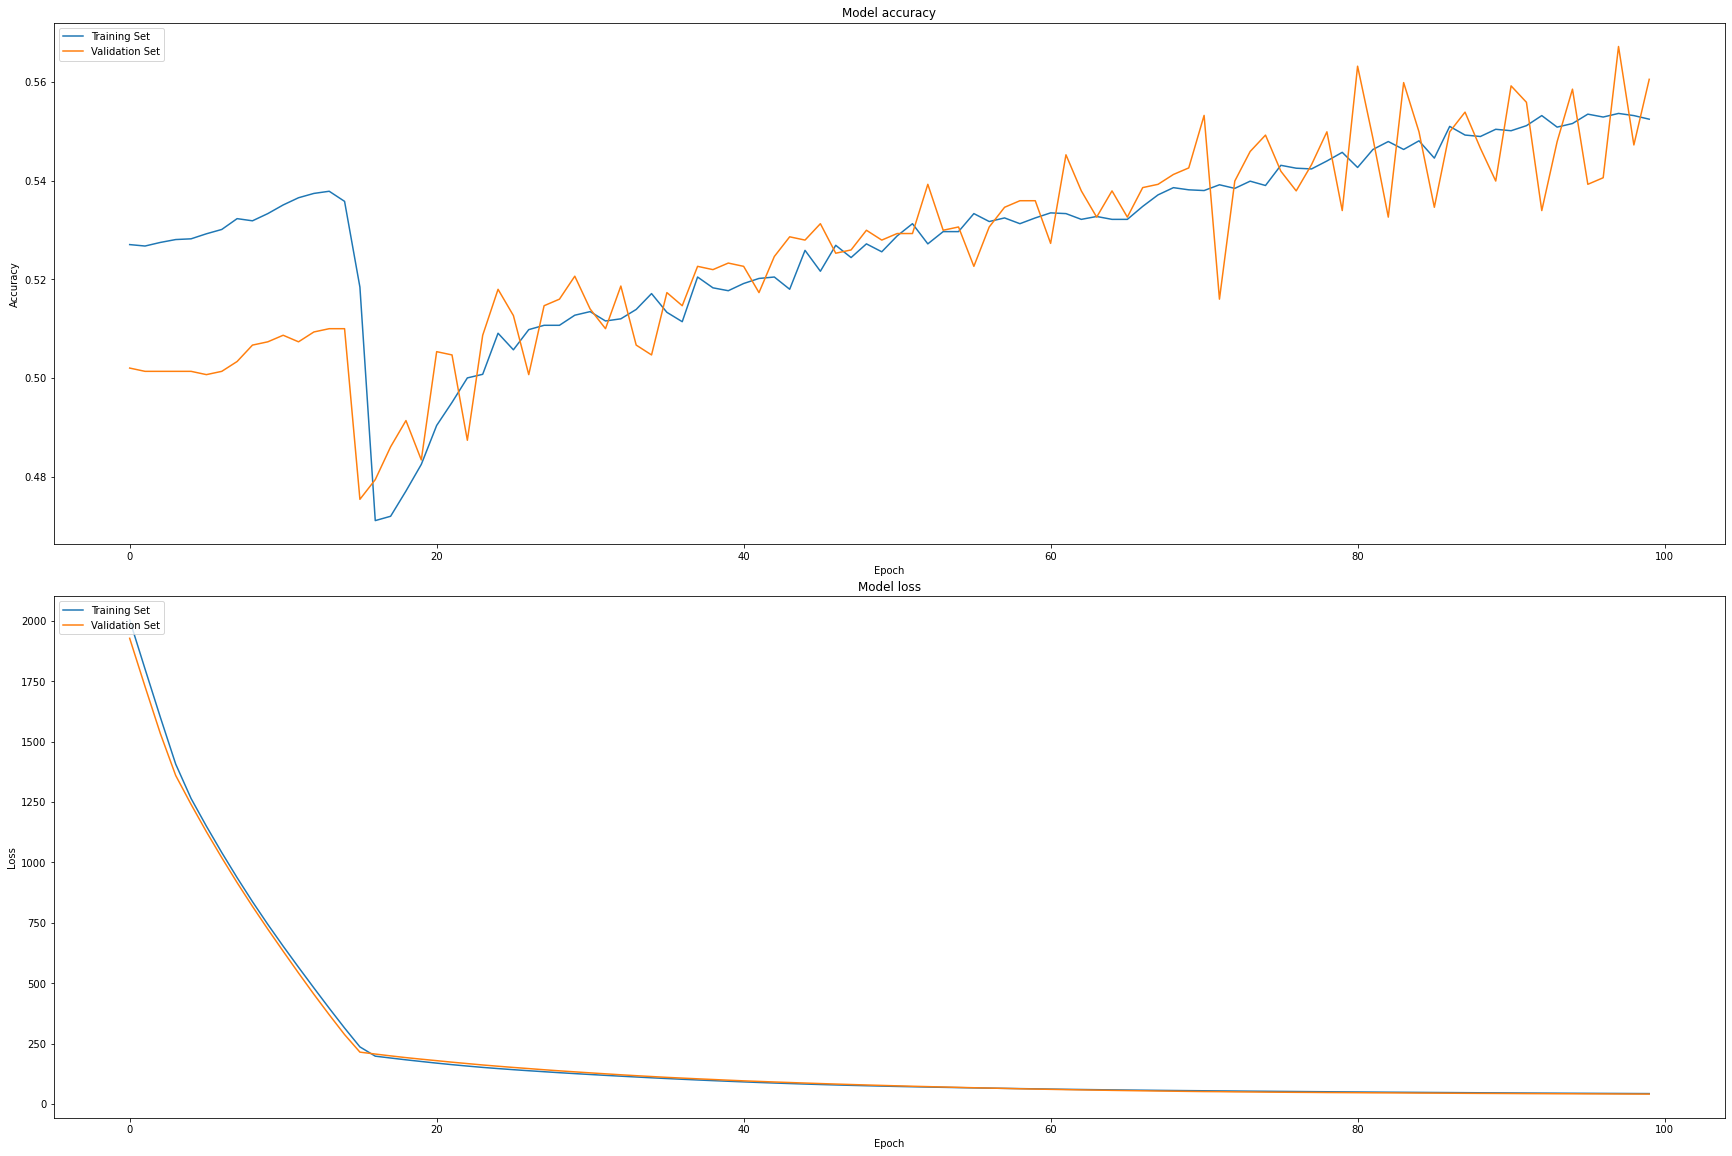

In [29]:
plot_history(history4)

In [32]:
# load and continue training 
model4_load = tf.keras.models.load_model('model_checkpoints/model4/ckpt_100')
callbacks4_continue = create_callbacks('model_checkpoints/model4/', 'epoch', 5)
history4_continue = model4.fit(X_train, y_hot_train,
                    validation_data=(X_validate, y_hot_val),
                    epochs=200,
                    batch_size=24,
                    callbacks=callbacks4_continue,
                    initial_epoch=100
                    # class_weight=class_weight
                    )


Epoch 101/200
286/286 [==============================] - 1s 4ms/step - loss: 42.7006 - accuracy: 0.5533 - val_loss: 40.6505 - val_accuracy: 0.5698
Epoch 102/200
286/286 [==============================] - 1s 2ms/step - loss: 42.3869 - accuracy: 0.5540 - val_loss: 40.3733 - val_accuracy: 0.5618
Epoch 103/200
286/286 [==============================] - 1s 2ms/step - loss: 42.1310 - accuracy: 0.5545 - val_loss: 40.2811 - val_accuracy: 0.5445
Epoch 104/200
286/286 [==============================] - 1s 2ms/step - loss: 41.8798 - accuracy: 0.5590 - val_loss: 40.1090 - val_accuracy: 0.5459
Epoch 105/200
283/286 [============================>.] - ETA: 0s - loss: 41.6706 - accuracy: 0.5558

INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_105/assets


INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_105/assets


286/286 [==============================] - 1s 5ms/step - loss: 41.6139 - accuracy: 0.5552 - val_loss: 39.8719 - val_accuracy: 0.5758
Epoch 106/200
286/286 [==============================] - 1s 2ms/step - loss: 41.3764 - accuracy: 0.5564 - val_loss: 39.5852 - val_accuracy: 0.5465
Epoch 107/200
286/286 [==============================] - 1s 2ms/step - loss: 41.1219 - accuracy: 0.5556 - val_loss: 39.4389 - val_accuracy: 0.5445
Epoch 108/200
286/286 [==============================] - 1s 2ms/step - loss: 40.8830 - accuracy: 0.5590 - val_loss: 39.2003 - val_accuracy: 0.5791
Epoch 109/200
286/286 [==============================] - 1s 2ms/step - loss: 40.6521 - accuracy: 0.5572 - val_loss: 39.0089 - val_accuracy: 0.5791
Epoch 110/200
263/286 [==========================>...] - ETA: 0s - loss: 40.9292 - accuracy: 0.5626

INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_110/assets


INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_110/assets


286/286 [==============================] - 1s 5ms/step - loss: 40.3885 - accuracy: 0.5612 - val_loss: 38.7898 - val_accuracy: 0.5519
Epoch 111/200
286/286 [==============================] - 1s 2ms/step - loss: 40.1597 - accuracy: 0.5600 - val_loss: 38.5518 - val_accuracy: 0.5645
Epoch 112/200
286/286 [==============================] - 1s 2ms/step - loss: 39.9093 - accuracy: 0.5616 - val_loss: 38.4781 - val_accuracy: 0.5605
Epoch 113/200
286/286 [==============================] - 1s 2ms/step - loss: 39.6855 - accuracy: 0.5599 - val_loss: 38.3509 - val_accuracy: 0.5472
Epoch 114/200
286/286 [==============================] - 1s 2ms/step - loss: 39.4620 - accuracy: 0.5678 - val_loss: 38.0652 - val_accuracy: 0.5505
Epoch 115/200
265/286 [==========================>...] - ETA: 0s - loss: 39.3616 - accuracy: 0.5594

INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_115/assets


INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_115/assets


286/286 [==============================] - 2s 6ms/step - loss: 39.2682 - accuracy: 0.5587 - val_loss: 37.8716 - val_accuracy: 0.5572
Epoch 116/200
286/286 [==============================] - 1s 2ms/step - loss: 39.0416 - accuracy: 0.5602 - val_loss: 37.7139 - val_accuracy: 0.5652
Epoch 117/200
286/286 [==============================] - 1s 2ms/step - loss: 38.8349 - accuracy: 0.5629 - val_loss: 37.5908 - val_accuracy: 0.5539
Epoch 118/200
286/286 [==============================] - 1s 2ms/step - loss: 38.6118 - accuracy: 0.5607 - val_loss: 37.3842 - val_accuracy: 0.5765
Epoch 119/200
286/286 [==============================] - 1s 2ms/step - loss: 38.4225 - accuracy: 0.5634 - val_loss: 37.1137 - val_accuracy: 0.5678
Epoch 120/200
263/286 [==========================>...] - ETA: 0s - loss: 38.9078 - accuracy: 0.5602

INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_120/assets


INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_120/assets


286/286 [==============================] - 1s 5ms/step - loss: 38.2209 - accuracy: 0.5605 - val_loss: 37.0094 - val_accuracy: 0.5565
Epoch 121/200
286/286 [==============================] - 1s 2ms/step - loss: 38.0260 - accuracy: 0.5613 - val_loss: 36.8658 - val_accuracy: 0.5871
Epoch 122/200
286/286 [==============================] - 1s 2ms/step - loss: 37.8735 - accuracy: 0.5615 - val_loss: 36.7426 - val_accuracy: 0.5658
Epoch 123/200
286/286 [==============================] - 1s 2ms/step - loss: 37.6613 - accuracy: 0.5648 - val_loss: 36.5027 - val_accuracy: 0.5931
Epoch 124/200
286/286 [==============================] - 1s 2ms/step - loss: 37.5018 - accuracy: 0.5647 - val_loss: 36.4162 - val_accuracy: 0.5565
Epoch 125/200
268/286 [===========================>..] - ETA: 0s - loss: 38.6140 - accuracy: 0.5658

INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_125/assets


INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_125/assets


286/286 [==============================] - 1s 5ms/step - loss: 37.3387 - accuracy: 0.5662 - val_loss: 36.2135 - val_accuracy: 0.5691
Epoch 126/200
286/286 [==============================] - 1s 2ms/step - loss: 37.1570 - accuracy: 0.5643 - val_loss: 36.0704 - val_accuracy: 0.5831
Epoch 127/200
286/286 [==============================] - 1s 2ms/step - loss: 36.9936 - accuracy: 0.5664 - val_loss: 35.9086 - val_accuracy: 0.5625
Epoch 128/200
286/286 [==============================] - 1s 2ms/step - loss: 36.8510 - accuracy: 0.5634 - val_loss: 35.6868 - val_accuracy: 0.5944
Epoch 129/200
286/286 [==============================] - 1s 2ms/step - loss: 36.6582 - accuracy: 0.5644 - val_loss: 35.5849 - val_accuracy: 0.5765
Epoch 130/200
274/286 [===========================>..] - ETA: 0s - loss: 36.6713 - accuracy: 0.5663

INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_130/assets


INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_130/assets


286/286 [==============================] - 1s 5ms/step - loss: 36.5033 - accuracy: 0.5662 - val_loss: 35.5364 - val_accuracy: 0.5652
Epoch 131/200
286/286 [==============================] - 1s 2ms/step - loss: 36.3361 - accuracy: 0.5637 - val_loss: 35.3046 - val_accuracy: 0.5957
Epoch 132/200
286/286 [==============================] - 1s 2ms/step - loss: 36.1866 - accuracy: 0.5678 - val_loss: 35.1660 - val_accuracy: 0.5951
Epoch 133/200
286/286 [==============================] - 1s 2ms/step - loss: 36.0677 - accuracy: 0.5629 - val_loss: 34.9832 - val_accuracy: 0.5838
Epoch 134/200
286/286 [==============================] - 1s 2ms/step - loss: 35.8859 - accuracy: 0.5688 - val_loss: 34.9229 - val_accuracy: 0.5665
Epoch 135/200
269/286 [===========================>..] - ETA: 0s - loss: 32.8880 - accuracy: 0.5685

INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_135/assets


INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_135/assets


286/286 [==============================] - 1s 5ms/step - loss: 35.7394 - accuracy: 0.5682 - val_loss: 34.8393 - val_accuracy: 0.5691
Epoch 136/200
286/286 [==============================] - 1s 2ms/step - loss: 35.6067 - accuracy: 0.5724 - val_loss: 34.6115 - val_accuracy: 0.5891
Epoch 137/200
286/286 [==============================] - 1s 2ms/step - loss: 35.4533 - accuracy: 0.5710 - val_loss: 34.4889 - val_accuracy: 0.5957
Epoch 138/200
286/286 [==============================] - 1s 2ms/step - loss: 35.2831 - accuracy: 0.5724 - val_loss: 34.4592 - val_accuracy: 0.5971
Epoch 139/200
286/286 [==============================] - 1s 2ms/step - loss: 35.1579 - accuracy: 0.5673 - val_loss: 34.2887 - val_accuracy: 0.5858
Epoch 140/200
270/286 [===========================>..] - ETA: 0s - loss: 35.2028 - accuracy: 0.5724

INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_140/assets


INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_140/assets


286/286 [==============================] - 1s 5ms/step - loss: 35.0327 - accuracy: 0.5701 - val_loss: 34.1946 - val_accuracy: 0.6004
Epoch 141/200
286/286 [==============================] - 1s 2ms/step - loss: 34.9111 - accuracy: 0.5718 - val_loss: 34.1634 - val_accuracy: 0.5691
Epoch 142/200
286/286 [==============================] - 1s 2ms/step - loss: 34.7495 - accuracy: 0.5777 - val_loss: 33.9278 - val_accuracy: 0.5678
Epoch 143/200
286/286 [==============================] - 1s 2ms/step - loss: 34.6231 - accuracy: 0.5676 - val_loss: 33.7867 - val_accuracy: 0.5745
Epoch 144/200
286/286 [==============================] - 1s 2ms/step - loss: 34.4675 - accuracy: 0.5727 - val_loss: 33.7246 - val_accuracy: 0.5884
Epoch 145/200
255/286 [=========================>....] - ETA: 0s - loss: 34.2862 - accuracy: 0.5685

INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_145/assets


INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_145/assets


286/286 [==============================] - 1s 5ms/step - loss: 34.3352 - accuracy: 0.5689 - val_loss: 33.6266 - val_accuracy: 0.5771
Epoch 146/200
286/286 [==============================] - 1s 2ms/step - loss: 34.2039 - accuracy: 0.5666 - val_loss: 33.4641 - val_accuracy: 0.5984
Epoch 147/200
286/286 [==============================] - 1s 2ms/step - loss: 34.0675 - accuracy: 0.5721 - val_loss: 33.3067 - val_accuracy: 0.5997
Epoch 148/200
286/286 [==============================] - 1s 2ms/step - loss: 33.9650 - accuracy: 0.5691 - val_loss: 33.2409 - val_accuracy: 0.5884
Epoch 149/200
286/286 [==============================] - 1s 2ms/step - loss: 33.7943 - accuracy: 0.5689 - val_loss: 33.0639 - val_accuracy: 0.5918
Epoch 150/200
266/286 [==========================>...] - ETA: 0s - loss: 33.6304 - accuracy: 0.5717

INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_150/assets


INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_150/assets


286/286 [==============================] - 1s 5ms/step - loss: 33.6831 - accuracy: 0.5723 - val_loss: 33.0428 - val_accuracy: 0.5665
Epoch 151/200
286/286 [==============================] - 1s 2ms/step - loss: 33.5683 - accuracy: 0.5702 - val_loss: 33.1878 - val_accuracy: 0.5691
Epoch 152/200
286/286 [==============================] - 1s 2ms/step - loss: 33.4281 - accuracy: 0.5772 - val_loss: 32.8038 - val_accuracy: 0.5991
Epoch 153/200
286/286 [==============================] - 1s 2ms/step - loss: 33.3396 - accuracy: 0.5745 - val_loss: 32.6448 - val_accuracy: 0.5971
Epoch 154/200
286/286 [==============================] - 1s 2ms/step - loss: 33.2112 - accuracy: 0.5743 - val_loss: 32.5565 - val_accuracy: 0.5798
Epoch 155/200
285/286 [============================>.] - ETA: 0s - loss: 33.1064 - accuracy: 0.5751

INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_155/assets


INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_155/assets


286/286 [==============================] - 1s 5ms/step - loss: 33.0757 - accuracy: 0.5752 - val_loss: 32.5072 - val_accuracy: 0.5705
Epoch 156/200
286/286 [==============================] - 1s 2ms/step - loss: 32.9371 - accuracy: 0.5799 - val_loss: 32.3660 - val_accuracy: 0.5818
Epoch 157/200
286/286 [==============================] - 1s 2ms/step - loss: 32.8219 - accuracy: 0.5683 - val_loss: 32.4833 - val_accuracy: 0.5765
Epoch 158/200
286/286 [==============================] - 1s 2ms/step - loss: 32.7193 - accuracy: 0.5720 - val_loss: 32.2835 - val_accuracy: 0.5831
Epoch 159/200
286/286 [==============================] - 1s 2ms/step - loss: 32.6274 - accuracy: 0.5778 - val_loss: 32.1473 - val_accuracy: 0.5858
Epoch 160/200
274/286 [===========================>..] - ETA: 0s - loss: 32.4773 - accuracy: 0.5763

INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_160/assets


INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_160/assets


286/286 [==============================] - 2s 6ms/step - loss: 32.4779 - accuracy: 0.5759 - val_loss: 32.0796 - val_accuracy: 0.5864
Epoch 161/200
286/286 [==============================] - 1s 2ms/step - loss: 32.3989 - accuracy: 0.5737 - val_loss: 32.1223 - val_accuracy: 0.5785
Epoch 162/200
286/286 [==============================] - 1s 2ms/step - loss: 32.2928 - accuracy: 0.5740 - val_loss: 31.9401 - val_accuracy: 0.5971
Epoch 163/200
286/286 [==============================] - 1s 2ms/step - loss: 32.2213 - accuracy: 0.5775 - val_loss: 31.7945 - val_accuracy: 0.5864
Epoch 164/200
286/286 [==============================] - 1s 2ms/step - loss: 32.0833 - accuracy: 0.5755 - val_loss: 31.7320 - val_accuracy: 0.5831
Epoch 165/200
276/286 [===========================>..] - ETA: 0s - loss: 32.1183 - accuracy: 0.5770

INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_165/assets


INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_165/assets


286/286 [==============================] - 1s 5ms/step - loss: 31.9943 - accuracy: 0.5768 - val_loss: 31.6414 - val_accuracy: 0.5778
Epoch 166/200
286/286 [==============================] - 1s 2ms/step - loss: 31.8999 - accuracy: 0.5735 - val_loss: 31.7624 - val_accuracy: 0.5791
Epoch 167/200
286/286 [==============================] - 1s 2ms/step - loss: 31.7974 - accuracy: 0.5724 - val_loss: 31.4341 - val_accuracy: 0.5858
Epoch 168/200
286/286 [==============================] - 1s 2ms/step - loss: 31.7125 - accuracy: 0.5717 - val_loss: 31.2923 - val_accuracy: 0.5918
Epoch 169/200
286/286 [==============================] - 1s 2ms/step - loss: 31.6004 - accuracy: 0.5770 - val_loss: 31.2403 - val_accuracy: 0.5851
Epoch 170/200
267/286 [===========================>..] - ETA: 0s - loss: 31.1824 - accuracy: 0.5754

INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_170/assets


INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_170/assets


286/286 [==============================] - 1s 5ms/step - loss: 31.5299 - accuracy: 0.5718 - val_loss: 31.1159 - val_accuracy: 0.5977
Epoch 171/200
286/286 [==============================] - 1s 2ms/step - loss: 31.4637 - accuracy: 0.5742 - val_loss: 31.2285 - val_accuracy: 0.5811
Epoch 172/200
286/286 [==============================] - 1s 2ms/step - loss: 31.3546 - accuracy: 0.5777 - val_loss: 30.9569 - val_accuracy: 0.5938
Epoch 173/200
286/286 [==============================] - 1s 2ms/step - loss: 31.2720 - accuracy: 0.5756 - val_loss: 30.9641 - val_accuracy: 0.6090
Epoch 174/200
286/286 [==============================] - 1s 2ms/step - loss: 31.1717 - accuracy: 0.5713 - val_loss: 30.9622 - val_accuracy: 0.5811
Epoch 175/200
272/286 [===========================>..] - ETA: 0s - loss: 31.5603 - accuracy: 0.5735

INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_175/assets


INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_175/assets


286/286 [==============================] - 1s 5ms/step - loss: 31.0931 - accuracy: 0.5765 - val_loss: 30.7837 - val_accuracy: 0.5938
Epoch 176/200
286/286 [==============================] - 1s 2ms/step - loss: 31.0467 - accuracy: 0.5732 - val_loss: 30.7425 - val_accuracy: 0.5811
Epoch 177/200
286/286 [==============================] - 1s 2ms/step - loss: 30.9252 - accuracy: 0.5775 - val_loss: 30.5667 - val_accuracy: 0.5858
Epoch 178/200
286/286 [==============================] - 1s 2ms/step - loss: 30.8247 - accuracy: 0.5758 - val_loss: 30.5256 - val_accuracy: 0.5844
Epoch 179/200
286/286 [==============================] - 1s 2ms/step - loss: 30.7676 - accuracy: 0.5786 - val_loss: 30.4160 - val_accuracy: 0.5851
Epoch 180/200
265/286 [==========================>...] - ETA: 0s - loss: 30.5326 - accuracy: 0.5818

INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_180/assets


INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_180/assets


286/286 [==============================] - 1s 5ms/step - loss: 30.6641 - accuracy: 0.5800 - val_loss: 30.3629 - val_accuracy: 0.5878
Epoch 181/200
286/286 [==============================] - 1s 2ms/step - loss: 30.6296 - accuracy: 0.5781 - val_loss: 30.2718 - val_accuracy: 0.5864
Epoch 182/200
286/286 [==============================] - 1s 2ms/step - loss: 30.5499 - accuracy: 0.5768 - val_loss: 30.3286 - val_accuracy: 0.5831
Epoch 183/200
286/286 [==============================] - 1s 2ms/step - loss: 30.4453 - accuracy: 0.5787 - val_loss: 30.2688 - val_accuracy: 0.5831
Epoch 184/200
286/286 [==============================] - 1s 2ms/step - loss: 30.3691 - accuracy: 0.5777 - val_loss: 30.0399 - val_accuracy: 0.6124
Epoch 185/200
268/286 [===========================>..] - ETA: 0s - loss: 30.9575 - accuracy: 0.5808

INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_185/assets


INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_185/assets


286/286 [==============================] - 1s 5ms/step - loss: 30.2967 - accuracy: 0.5778 - val_loss: 29.9818 - val_accuracy: 0.5878
Epoch 186/200
286/286 [==============================] - 1s 2ms/step - loss: 30.2288 - accuracy: 0.5761 - val_loss: 29.9949 - val_accuracy: 0.5858
Epoch 187/200
286/286 [==============================] - 1s 2ms/step - loss: 30.1573 - accuracy: 0.5767 - val_loss: 29.8538 - val_accuracy: 0.5984
Epoch 188/200
286/286 [==============================] - 1s 2ms/step - loss: 30.0726 - accuracy: 0.5748 - val_loss: 29.8451 - val_accuracy: 0.5871
Epoch 189/200
286/286 [==============================] - 1s 2ms/step - loss: 30.0037 - accuracy: 0.5784 - val_loss: 29.7576 - val_accuracy: 0.5878
Epoch 190/200
268/286 [===========================>..] - ETA: 0s - loss: 30.2445 - accuracy: 0.5756

INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_190/assets


INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_190/assets


286/286 [==============================] - 1s 5ms/step - loss: 29.9263 - accuracy: 0.5771 - val_loss: 29.9202 - val_accuracy: 0.5864
Epoch 191/200
286/286 [==============================] - 1s 2ms/step - loss: 29.8657 - accuracy: 0.5794 - val_loss: 29.6599 - val_accuracy: 0.5904
Epoch 192/200
286/286 [==============================] - 1s 2ms/step - loss: 29.7514 - accuracy: 0.5809 - val_loss: 29.5724 - val_accuracy: 0.5984
Epoch 193/200
286/286 [==============================] - 1s 2ms/step - loss: 29.6816 - accuracy: 0.5746 - val_loss: 29.5263 - val_accuracy: 0.5838
Epoch 194/200
286/286 [==============================] - 1s 2ms/step - loss: 29.6080 - accuracy: 0.5756 - val_loss: 29.4888 - val_accuracy: 0.5864
Epoch 195/200
274/286 [===========================>..] - ETA: 0s - loss: 29.5877 - accuracy: 0.5754

INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_195/assets


INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_195/assets


286/286 [==============================] - 1s 5ms/step - loss: 29.5466 - accuracy: 0.5762 - val_loss: 29.3694 - val_accuracy: 0.5898
Epoch 196/200
286/286 [==============================] - 1s 2ms/step - loss: 29.4673 - accuracy: 0.5800 - val_loss: 29.2682 - val_accuracy: 0.5871
Epoch 197/200
286/286 [==============================] - 1s 2ms/step - loss: 29.3951 - accuracy: 0.5810 - val_loss: 29.3033 - val_accuracy: 0.5838
Epoch 198/200
286/286 [==============================] - 1s 2ms/step - loss: 29.3287 - accuracy: 0.5812 - val_loss: 29.2438 - val_accuracy: 0.5851
Epoch 199/200
286/286 [==============================] - 1s 2ms/step - loss: 29.2747 - accuracy: 0.5759 - val_loss: 28.9970 - val_accuracy: 0.5844
Epoch 200/200
258/286 [==========================>...] - ETA: 0s - loss: 26.9477 - accuracy: 0.5770

INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_200/assets


INFO:tensorflow:Assets written to: model_checkpoints/model4/ckpt_200/assets


286/286 [==============================] - 1s 5ms/step - loss: 29.1772 - accuracy: 0.5759 - val_loss: 29.0961 - val_accuracy: 0.5911


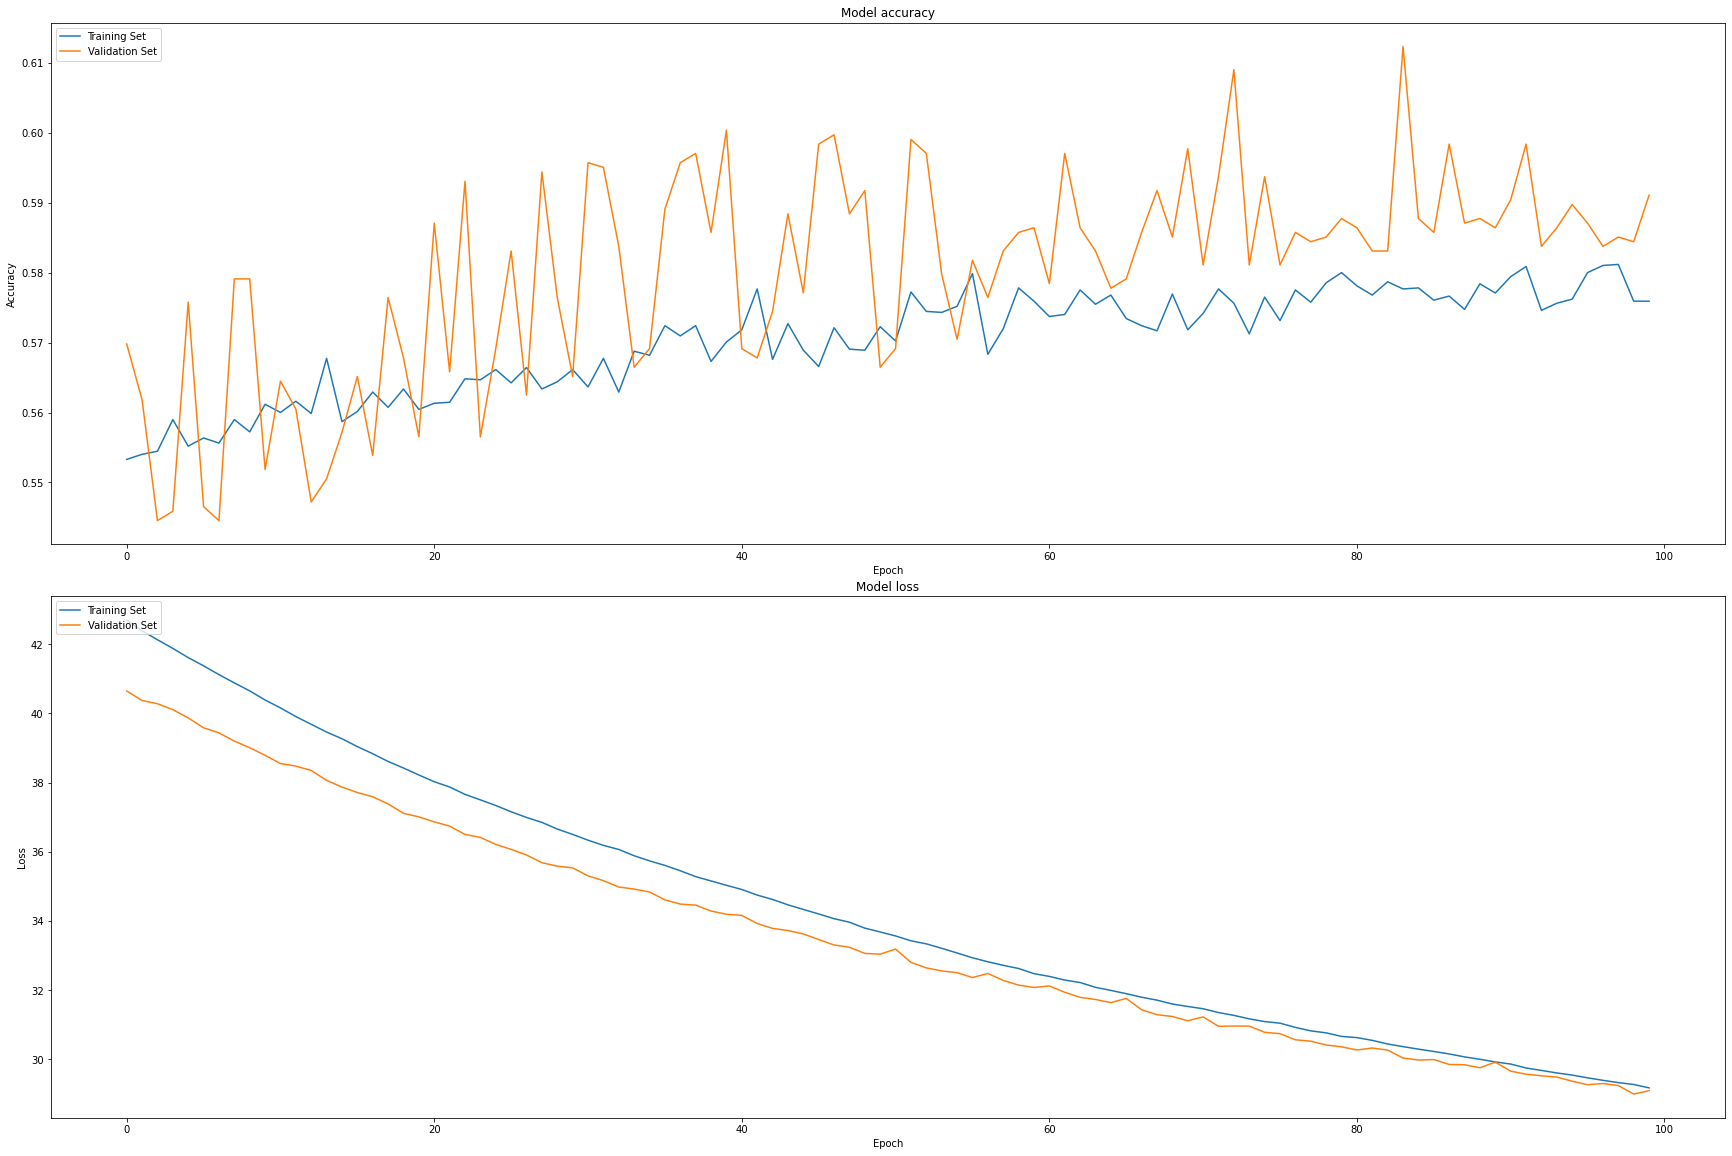

In [33]:
plot_history(history4_continue)

In [9]:
model4_checkpoint = tf.keras.models.load_model('model_checkpoints/model4/ckpt_200')

In [10]:
y_pred_probs4 = model4_checkpoint.predict(X_test)
print(y_pred_probs4)

y_predict4 = np.round(y_pred_probs4)# Convert probabilities to binary predictions using a threshold of 0.5
print (y_predict4)
# print(y_predict4)

49/49 [==============================] - 0s 1ms/step
[[1.00000000e+00 5.46639637e-38]
 [0.00000000e+00 1.00000000e+00]
 [7.38122361e-03 9.92618740e-01]
 ...
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [8.86165738e-01 1.13834225e-01]]
[[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [11]:
# convert categorical to binary
binary_preds_1d = np.argmax(y_predict4, axis=1)
print(binary_preds_1d)

precision = precision_score(y_test, binary_preds_1d)
recall = recall_score(y_test, binary_preds_1d)
f1_4 = f1_score(y_test, binary_preds_1d)

print( "precision: ", precision)
print( "recall: ", recall)
print("f1 score: ", f1_4)

[0 1 1 ... 0 0 0]
precision:  0.5665024630541872
recall:  0.5874840357598978
f1 score:  0.5768025078369907


[[432 351]
 [357 426]]


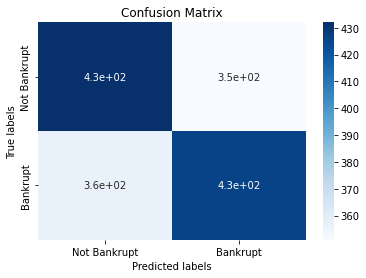

In [58]:
conf_mat = confusion_matrix(y_test, binary_preds_1d)
print(conf_mat)
plot_cm(conf_mat)

In [11]:
# less epochs
model5 = binary_classification_model_4()
callbacks5 = create_callbacks('model_checkpoints/model5/', 'epoch', 5)
history5 = model5.fit(X_train, y_hot_train,
                    validation_data=(X_validate, y_hot_val),
                    epochs=300,
                    batch_size=24,
                    callbacks=callbacks5,
                    # class_weight=class_weight
                    )

Epoch 1/300
286/286 [==============================] - 2s 4ms/step - loss: 4653.8652 - accuracy: 0.4978 - val_loss: 4187.6997 - val_accuracy: 0.5253
Epoch 2/300
286/286 [==============================] - 1s 2ms/step - loss: 4515.9849 - accuracy: 0.4978 - val_loss: 4062.5146 - val_accuracy: 0.5239
Epoch 3/300
286/286 [==============================] - 1s 2ms/step - loss: 4381.3755 - accuracy: 0.4978 - val_loss: 3940.9570 - val_accuracy: 0.5239
Epoch 4/300
286/286 [==============================] - 1s 2ms/step - loss: 4250.3223 - accuracy: 0.4978 - val_loss: 3822.7576 - val_accuracy: 0.5246
Epoch 5/300
256/286 [=========================>....] - ETA: 0s - loss: 4105.0776 - accuracy: 0.5011

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_5/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_5/assets


286/286 [==============================] - 1s 5ms/step - loss: 4122.8511 - accuracy: 0.4975 - val_loss: 3707.7581 - val_accuracy: 0.5246
Epoch 6/300
286/286 [==============================] - 1s 3ms/step - loss: 3999.3472 - accuracy: 0.4972 - val_loss: 3596.0139 - val_accuracy: 0.5233
Epoch 7/300
286/286 [==============================] - 1s 2ms/step - loss: 3879.1829 - accuracy: 0.4978 - val_loss: 3487.3762 - val_accuracy: 0.5239
Epoch 8/300
286/286 [==============================] - 1s 2ms/step - loss: 3761.7490 - accuracy: 0.4984 - val_loss: 3379.9956 - val_accuracy: 0.5246
Epoch 9/300
286/286 [==============================] - 1s 2ms/step - loss: 3646.4900 - accuracy: 0.4974 - val_loss: 3274.9180 - val_accuracy: 0.5246
Epoch 10/300
266/286 [==========================>...] - ETA: 0s - loss: 3547.2073 - accuracy: 0.4962

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_10/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_10/assets


286/286 [==============================] - 1s 5ms/step - loss: 3532.4983 - accuracy: 0.4968 - val_loss: 3170.9778 - val_accuracy: 0.5239
Epoch 11/300
286/286 [==============================] - 1s 2ms/step - loss: 3416.7781 - accuracy: 0.4969 - val_loss: 3059.5598 - val_accuracy: 0.5253
Epoch 12/300
286/286 [==============================] - 1s 2ms/step - loss: 3231.4653 - accuracy: 0.4975 - val_loss: 2832.6665 - val_accuracy: 0.5239
Epoch 13/300
286/286 [==============================] - 1s 2ms/step - loss: 2997.9370 - accuracy: 0.4971 - val_loss: 2641.4346 - val_accuracy: 0.5239
Epoch 14/300
286/286 [==============================] - 1s 2ms/step - loss: 2799.7568 - accuracy: 0.4974 - val_loss: 2469.6689 - val_accuracy: 0.5226
Epoch 15/300
265/286 [==========================>...] - ETA: 0s - loss: 2626.5471 - accuracy: 0.4991

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_15/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_15/assets


286/286 [==============================] - 1s 4ms/step - loss: 2617.4270 - accuracy: 0.4975 - val_loss: 2307.4583 - val_accuracy: 0.5233
Epoch 16/300
286/286 [==============================] - 1s 2ms/step - loss: 2440.6187 - accuracy: 0.4972 - val_loss: 2147.9141 - val_accuracy: 0.5233
Epoch 17/300
286/286 [==============================] - 1s 2ms/step - loss: 2269.6582 - accuracy: 0.4962 - val_loss: 1994.9733 - val_accuracy: 0.5233
Epoch 18/300
286/286 [==============================] - 1s 2ms/step - loss: 2103.7781 - accuracy: 0.4958 - val_loss: 1844.2596 - val_accuracy: 0.5226
Epoch 19/300
286/286 [==============================] - 1s 2ms/step - loss: 1940.4391 - accuracy: 0.4955 - val_loss: 1696.3450 - val_accuracy: 0.5213
Epoch 20/300
262/286 [==========================>...] - ETA: 0s - loss: 1786.8329 - accuracy: 0.4959

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_20/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_20/assets


286/286 [==============================] - 1s 5ms/step - loss: 1778.9420 - accuracy: 0.4943 - val_loss: 1550.0216 - val_accuracy: 0.5199
Epoch 21/300
286/286 [==============================] - 1s 2ms/step - loss: 1618.6625 - accuracy: 0.4930 - val_loss: 1404.6539 - val_accuracy: 0.5206
Epoch 22/300
286/286 [==============================] - 1s 2ms/step - loss: 1459.8125 - accuracy: 0.4921 - val_loss: 1260.9358 - val_accuracy: 0.5206
Epoch 23/300
286/286 [==============================] - 1s 2ms/step - loss: 1303.4213 - accuracy: 0.4907 - val_loss: 1122.8102 - val_accuracy: 0.5206
Epoch 24/300
286/286 [==============================] - 1s 2ms/step - loss: 1170.7925 - accuracy: 0.4902 - val_loss: 1036.0033 - val_accuracy: 0.5193
Epoch 25/300
283/286 [============================>.] - ETA: 0s - loss: 1106.9181 - accuracy: 0.4898

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_25/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_25/assets


286/286 [==============================] - 1s 5ms/step - loss: 1108.3264 - accuracy: 0.4898 - val_loss: 994.1477 - val_accuracy: 0.5193
Epoch 26/300
286/286 [==============================] - 1s 2ms/step - loss: 1062.3141 - accuracy: 0.4895 - val_loss: 952.2488 - val_accuracy: 0.5199
Epoch 27/300
286/286 [==============================] - 1s 2ms/step - loss: 1016.2531 - accuracy: 0.4896 - val_loss: 910.3685 - val_accuracy: 0.5199
Epoch 28/300
286/286 [==============================] - 1s 2ms/step - loss: 970.3570 - accuracy: 0.4893 - val_loss: 868.7015 - val_accuracy: 0.5199
Epoch 29/300
286/286 [==============================] - 1s 2ms/step - loss: 924.5904 - accuracy: 0.4890 - val_loss: 827.4269 - val_accuracy: 0.5186
Epoch 30/300
267/286 [===========================>..] - ETA: 0s - loss: 882.1165 - accuracy: 0.4883

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_30/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_30/assets


286/286 [==============================] - 1s 5ms/step - loss: 879.0576 - accuracy: 0.4886 - val_loss: 786.4901 - val_accuracy: 0.5180
Epoch 31/300
286/286 [==============================] - 1s 2ms/step - loss: 833.6318 - accuracy: 0.4886 - val_loss: 745.6898 - val_accuracy: 0.5160
Epoch 32/300
286/286 [==============================] - 1s 2ms/step - loss: 788.5283 - accuracy: 0.4883 - val_loss: 705.3489 - val_accuracy: 0.5140
Epoch 33/300
286/286 [==============================] - 1s 2ms/step - loss: 743.6711 - accuracy: 0.4873 - val_loss: 665.4098 - val_accuracy: 0.5126
Epoch 34/300
286/286 [==============================] - 1s 2ms/step - loss: 699.0981 - accuracy: 0.4870 - val_loss: 625.7198 - val_accuracy: 0.5133
Epoch 35/300
262/286 [==========================>...] - ETA: 0s - loss: 659.3488 - accuracy: 0.4862

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_35/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_35/assets


286/286 [==============================] - 1s 5ms/step - loss: 654.9604 - accuracy: 0.4863 - val_loss: 586.5773 - val_accuracy: 0.5120
Epoch 36/300
286/286 [==============================] - 1s 2ms/step - loss: 611.4523 - accuracy: 0.4851 - val_loss: 548.0958 - val_accuracy: 0.5106
Epoch 37/300
286/286 [==============================] - 1s 2ms/step - loss: 568.5000 - accuracy: 0.4842 - val_loss: 510.1755 - val_accuracy: 0.5100
Epoch 38/300
286/286 [==============================] - 1s 2ms/step - loss: 526.1693 - accuracy: 0.4832 - val_loss: 472.8225 - val_accuracy: 0.5100
Epoch 39/300
286/286 [==============================] - 1s 2ms/step - loss: 484.4175 - accuracy: 0.4836 - val_loss: 435.9901 - val_accuracy: 0.5106
Epoch 40/300
268/286 [===========================>..] - ETA: 0s - loss: 443.2105 - accuracy: 0.4852

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_40/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_40/assets


286/286 [==============================] - 1s 4ms/step - loss: 443.3818 - accuracy: 0.4822 - val_loss: 400.2188 - val_accuracy: 0.5113
Epoch 41/300
286/286 [==============================] - 1s 2ms/step - loss: 403.1868 - accuracy: 0.4838 - val_loss: 364.6901 - val_accuracy: 0.5100
Epoch 42/300
286/286 [==============================] - 1s 2ms/step - loss: 363.5638 - accuracy: 0.4883 - val_loss: 329.7679 - val_accuracy: 0.5193
Epoch 43/300
286/286 [==============================] - 1s 2ms/step - loss: 324.5431 - accuracy: 0.5072 - val_loss: 295.3237 - val_accuracy: 0.4993
Epoch 44/300
286/286 [==============================] - 1s 2ms/step - loss: 286.3757 - accuracy: 0.5174 - val_loss: 261.7209 - val_accuracy: 0.5007
Epoch 45/300
257/286 [=========================>....] - ETA: 0s - loss: 253.9330 - accuracy: 0.5154

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_45/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_45/assets


286/286 [==============================] - 1s 5ms/step - loss: 249.9103 - accuracy: 0.5199 - val_loss: 231.0065 - val_accuracy: 0.5020
Epoch 46/300
286/286 [==============================] - 1s 2ms/step - loss: 222.3461 - accuracy: 0.5193 - val_loss: 211.1682 - val_accuracy: 0.5027
Epoch 47/300
286/286 [==============================] - 1s 2ms/step - loss: 204.1263 - accuracy: 0.5209 - val_loss: 192.6248 - val_accuracy: 0.5053
Epoch 48/300
286/286 [==============================] - 1s 2ms/step - loss: 186.7693 - accuracy: 0.5219 - val_loss: 174.7660 - val_accuracy: 0.5040
Epoch 49/300
286/286 [==============================] - 1s 2ms/step - loss: 170.0354 - accuracy: 0.5229 - val_loss: 157.4021 - val_accuracy: 0.5033
Epoch 50/300
264/286 [==========================>...] - ETA: 0s - loss: 152.3820 - accuracy: 0.5224

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_50/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_50/assets


286/286 [==============================] - 1s 4ms/step - loss: 153.7814 - accuracy: 0.5239 - val_loss: 140.6096 - val_accuracy: 0.5053
Epoch 51/300
286/286 [==============================] - 1s 2ms/step - loss: 138.0018 - accuracy: 0.5235 - val_loss: 124.3829 - val_accuracy: 0.5020
Epoch 52/300
286/286 [==============================] - 1s 2ms/step - loss: 122.6207 - accuracy: 0.5247 - val_loss: 108.5219 - val_accuracy: 0.5007
Epoch 53/300
286/286 [==============================] - 1s 2ms/step - loss: 107.6767 - accuracy: 0.5237 - val_loss: 93.4404 - val_accuracy: 0.5033
Epoch 54/300
286/286 [==============================] - 1s 2ms/step - loss: 93.1191 - accuracy: 0.5226 - val_loss: 78.8441 - val_accuracy: 0.5060
Epoch 55/300
267/286 [===========================>..] - ETA: 0s - loss: 78.1268 - accuracy: 0.5279

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_55/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_55/assets


286/286 [==============================] - 1s 5ms/step - loss: 79.1811 - accuracy: 0.5272 - val_loss: 64.9317 - val_accuracy: 0.5093
Epoch 56/300
286/286 [==============================] - 1s 2ms/step - loss: 66.0895 - accuracy: 0.5219 - val_loss: 51.9997 - val_accuracy: 0.5106
Epoch 57/300
286/286 [==============================] - 1s 2ms/step - loss: 54.3011 - accuracy: 0.5225 - val_loss: 41.0684 - val_accuracy: 0.5086
Epoch 58/300
286/286 [==============================] - 1s 2ms/step - loss: 45.6807 - accuracy: 0.5133 - val_loss: 34.8908 - val_accuracy: 0.5133
Epoch 59/300
286/286 [==============================] - 1s 2ms/step - loss: 42.6354 - accuracy: 0.5184 - val_loss: 33.5719 - val_accuracy: 0.5213
Epoch 60/300
267/286 [===========================>..] - ETA: 0s - loss: 41.9494 - accuracy: 0.5200

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_60/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_60/assets


286/286 [==============================] - 1s 5ms/step - loss: 41.2477 - accuracy: 0.5202 - val_loss: 32.1803 - val_accuracy: 0.5293
Epoch 61/300
286/286 [==============================] - 1s 2ms/step - loss: 39.9604 - accuracy: 0.5204 - val_loss: 31.0078 - val_accuracy: 0.5213
Epoch 62/300
286/286 [==============================] - 1s 2ms/step - loss: 38.7623 - accuracy: 0.5234 - val_loss: 29.7647 - val_accuracy: 0.5273
Epoch 63/300
286/286 [==============================] - 1s 2ms/step - loss: 37.6045 - accuracy: 0.5276 - val_loss: 28.6333 - val_accuracy: 0.5312
Epoch 64/300
286/286 [==============================] - 1s 2ms/step - loss: 36.5231 - accuracy: 0.5321 - val_loss: 27.5357 - val_accuracy: 0.5399
Epoch 65/300
263/286 [==========================>...] - ETA: 0s - loss: 36.2147 - accuracy: 0.5290

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_65/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_65/assets


286/286 [==============================] - 1s 5ms/step - loss: 35.4658 - accuracy: 0.5282 - val_loss: 26.6094 - val_accuracy: 0.5253
Epoch 66/300
286/286 [==============================] - 1s 2ms/step - loss: 34.4742 - accuracy: 0.5299 - val_loss: 25.5852 - val_accuracy: 0.5465
Epoch 67/300
286/286 [==============================] - 1s 2ms/step - loss: 33.5389 - accuracy: 0.5365 - val_loss: 24.6816 - val_accuracy: 0.5246
Epoch 68/300
286/286 [==============================] - 1s 2ms/step - loss: 32.6018 - accuracy: 0.5361 - val_loss: 23.8761 - val_accuracy: 0.5299
Epoch 69/300
286/286 [==============================] - 1s 2ms/step - loss: 31.7960 - accuracy: 0.5336 - val_loss: 23.0214 - val_accuracy: 0.5505
Epoch 70/300
270/286 [===========================>..] - ETA: 0s - loss: 31.3293 - accuracy: 0.5400

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_70/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_70/assets


286/286 [==============================] - 1s 4ms/step - loss: 30.9919 - accuracy: 0.5415 - val_loss: 22.1624 - val_accuracy: 0.5372
Epoch 71/300
286/286 [==============================] - 1s 2ms/step - loss: 30.2612 - accuracy: 0.5444 - val_loss: 21.4328 - val_accuracy: 0.5465
Epoch 72/300
286/286 [==============================] - 1s 2ms/step - loss: 29.5473 - accuracy: 0.5407 - val_loss: 20.8090 - val_accuracy: 0.5512
Epoch 73/300
286/286 [==============================] - 1s 2ms/step - loss: 28.9412 - accuracy: 0.5412 - val_loss: 20.3154 - val_accuracy: 0.5406
Epoch 74/300
286/286 [==============================] - 1s 2ms/step - loss: 28.3556 - accuracy: 0.5412 - val_loss: 19.8667 - val_accuracy: 0.5399
Epoch 75/300
265/286 [==========================>...] - ETA: 0s - loss: 27.9757 - accuracy: 0.5439

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_75/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_75/assets


286/286 [==============================] - 1s 5ms/step - loss: 27.8293 - accuracy: 0.5435 - val_loss: 19.5217 - val_accuracy: 0.5439
Epoch 76/300
286/286 [==============================] - 1s 2ms/step - loss: 27.2345 - accuracy: 0.5467 - val_loss: 19.3519 - val_accuracy: 0.5326
Epoch 77/300
286/286 [==============================] - 1s 2ms/step - loss: 26.7258 - accuracy: 0.5422 - val_loss: 18.8691 - val_accuracy: 0.5499
Epoch 78/300
286/286 [==============================] - 1s 2ms/step - loss: 26.1766 - accuracy: 0.5475 - val_loss: 18.7512 - val_accuracy: 0.5359
Epoch 79/300
286/286 [==============================] - 1s 2ms/step - loss: 25.6759 - accuracy: 0.5491 - val_loss: 18.3045 - val_accuracy: 0.5352
Epoch 80/300
257/286 [=========================>....] - ETA: 0s - loss: 24.6129 - accuracy: 0.5459

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_80/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_80/assets


286/286 [==============================] - 1s 5ms/step - loss: 25.1649 - accuracy: 0.5473 - val_loss: 17.9794 - val_accuracy: 0.5465
Epoch 81/300
286/286 [==============================] - 1s 2ms/step - loss: 24.6882 - accuracy: 0.5520 - val_loss: 17.7510 - val_accuracy: 0.5459
Epoch 82/300
286/286 [==============================] - 1s 2ms/step - loss: 24.2432 - accuracy: 0.5542 - val_loss: 17.4935 - val_accuracy: 0.5439
Epoch 83/300
286/286 [==============================] - 1s 2ms/step - loss: 23.8167 - accuracy: 0.5545 - val_loss: 17.2643 - val_accuracy: 0.5485
Epoch 84/300
286/286 [==============================] - 1s 2ms/step - loss: 23.4386 - accuracy: 0.5520 - val_loss: 16.9493 - val_accuracy: 0.5532
Epoch 85/300
268/286 [===========================>..] - ETA: 0s - loss: 23.1048 - accuracy: 0.5529

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_85/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_85/assets


286/286 [==============================] - 1s 5ms/step - loss: 23.0406 - accuracy: 0.5524 - val_loss: 16.7711 - val_accuracy: 0.5565
Epoch 86/300
286/286 [==============================] - 1s 2ms/step - loss: 22.6765 - accuracy: 0.5496 - val_loss: 16.9922 - val_accuracy: 0.5419
Epoch 87/300
286/286 [==============================] - 1s 2ms/step - loss: 22.3199 - accuracy: 0.5530 - val_loss: 16.4255 - val_accuracy: 0.5445
Epoch 88/300
286/286 [==============================] - 1s 2ms/step - loss: 21.9297 - accuracy: 0.5548 - val_loss: 16.2776 - val_accuracy: 0.5406
Epoch 89/300
286/286 [==============================] - 1s 2ms/step - loss: 21.5659 - accuracy: 0.5540 - val_loss: 16.0586 - val_accuracy: 0.5565
Epoch 90/300
264/286 [==========================>...] - ETA: 0s - loss: 21.5781 - accuracy: 0.5530

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_90/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_90/assets


286/286 [==============================] - 1s 4ms/step - loss: 21.2397 - accuracy: 0.5542 - val_loss: 15.8916 - val_accuracy: 0.5426
Epoch 91/300
286/286 [==============================] - 1s 2ms/step - loss: 20.9420 - accuracy: 0.5542 - val_loss: 15.6778 - val_accuracy: 0.5512
Epoch 92/300
286/286 [==============================] - 1s 2ms/step - loss: 20.6538 - accuracy: 0.5567 - val_loss: 15.5840 - val_accuracy: 0.5598
Epoch 93/300
286/286 [==============================] - 1s 2ms/step - loss: 20.3344 - accuracy: 0.5568 - val_loss: 15.4073 - val_accuracy: 0.5578
Epoch 94/300
286/286 [==============================] - 1s 2ms/step - loss: 20.0507 - accuracy: 0.5588 - val_loss: 15.2654 - val_accuracy: 0.5472
Epoch 95/300
267/286 [===========================>..] - ETA: 0s - loss: 19.8141 - accuracy: 0.5610

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_95/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_95/assets


286/286 [==============================] - 1s 5ms/step - loss: 19.7801 - accuracy: 0.5600 - val_loss: 15.1318 - val_accuracy: 0.5472
Epoch 96/300
286/286 [==============================] - 1s 2ms/step - loss: 19.5111 - accuracy: 0.5594 - val_loss: 15.0881 - val_accuracy: 0.5406
Epoch 97/300
286/286 [==============================] - 1s 2ms/step - loss: 19.2040 - accuracy: 0.5602 - val_loss: 14.8706 - val_accuracy: 0.5472
Epoch 98/300
286/286 [==============================] - 1s 2ms/step - loss: 18.9700 - accuracy: 0.5570 - val_loss: 14.7111 - val_accuracy: 0.5539
Epoch 99/300
286/286 [==============================] - 1s 2ms/step - loss: 18.7275 - accuracy: 0.5605 - val_loss: 14.6678 - val_accuracy: 0.5452
Epoch 100/300
266/286 [==========================>...] - ETA: 0s - loss: 18.6973 - accuracy: 0.5586

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_100/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_100/assets


286/286 [==============================] - 1s 5ms/step - loss: 18.5155 - accuracy: 0.5600 - val_loss: 14.4909 - val_accuracy: 0.5426
Epoch 101/300
286/286 [==============================] - 1s 2ms/step - loss: 18.3102 - accuracy: 0.5600 - val_loss: 14.3253 - val_accuracy: 0.5565
Epoch 102/300
286/286 [==============================] - 1s 2ms/step - loss: 18.1000 - accuracy: 0.5635 - val_loss: 14.2070 - val_accuracy: 0.5479
Epoch 103/300
286/286 [==============================] - 1s 2ms/step - loss: 17.8837 - accuracy: 0.5628 - val_loss: 14.0927 - val_accuracy: 0.5592
Epoch 104/300
286/286 [==============================] - 1s 2ms/step - loss: 17.7214 - accuracy: 0.5599 - val_loss: 14.1059 - val_accuracy: 0.5406
Epoch 105/300
266/286 [==========================>...] - ETA: 0s - loss: 17.9951 - accuracy: 0.5642

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_105/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_105/assets


286/286 [==============================] - 1s 5ms/step - loss: 17.5170 - accuracy: 0.5647 - val_loss: 13.8642 - val_accuracy: 0.5419
Epoch 106/300
286/286 [==============================] - 1s 3ms/step - loss: 17.3444 - accuracy: 0.5533 - val_loss: 13.7044 - val_accuracy: 0.5452
Epoch 107/300
286/286 [==============================] - 1s 3ms/step - loss: 17.1399 - accuracy: 0.5597 - val_loss: 13.5721 - val_accuracy: 0.5539
Epoch 108/300
286/286 [==============================] - 1s 3ms/step - loss: 16.9742 - accuracy: 0.5596 - val_loss: 13.6804 - val_accuracy: 0.5339
Epoch 109/300
286/286 [==============================] - 1s 2ms/step - loss: 16.7926 - accuracy: 0.5610 - val_loss: 13.3343 - val_accuracy: 0.5598
Epoch 110/300
269/286 [===========================>..] - ETA: 0s - loss: 16.7256 - accuracy: 0.5612

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_110/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_110/assets


286/286 [==============================] - 2s 6ms/step - loss: 16.6357 - accuracy: 0.5606 - val_loss: 13.2096 - val_accuracy: 0.5512
Epoch 111/300
286/286 [==============================] - 1s 2ms/step - loss: 16.4636 - accuracy: 0.5606 - val_loss: 13.1029 - val_accuracy: 0.5432
Epoch 112/300
286/286 [==============================] - 1s 2ms/step - loss: 16.2968 - accuracy: 0.5634 - val_loss: 12.9407 - val_accuracy: 0.5552
Epoch 113/300
286/286 [==============================] - 1s 3ms/step - loss: 16.1238 - accuracy: 0.5631 - val_loss: 12.8370 - val_accuracy: 0.5598
Epoch 114/300
286/286 [==============================] - 1s 2ms/step - loss: 15.9789 - accuracy: 0.5662 - val_loss: 12.7651 - val_accuracy: 0.5519
Epoch 115/300
277/286 [============================>.] - ETA: 0s - loss: 15.7751 - accuracy: 0.5644

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_115/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_115/assets


286/286 [==============================] - 1s 5ms/step - loss: 15.8149 - accuracy: 0.5634 - val_loss: 12.7821 - val_accuracy: 0.5406
Epoch 116/300
286/286 [==============================] - 1s 3ms/step - loss: 15.6586 - accuracy: 0.5632 - val_loss: 12.5464 - val_accuracy: 0.5492
Epoch 117/300
286/286 [==============================] - 1s 2ms/step - loss: 15.5105 - accuracy: 0.5599 - val_loss: 12.4829 - val_accuracy: 0.5459
Epoch 118/300
286/286 [==============================] - 1s 2ms/step - loss: 15.3958 - accuracy: 0.5624 - val_loss: 12.4312 - val_accuracy: 0.5459
Epoch 119/300
286/286 [==============================] - 1s 2ms/step - loss: 15.2236 - accuracy: 0.5613 - val_loss: 12.2845 - val_accuracy: 0.5472
Epoch 120/300
268/286 [===========================>..] - ETA: 0s - loss: 15.0748 - accuracy: 0.5620

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_120/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_120/assets


286/286 [==============================] - 1s 5ms/step - loss: 15.1038 - accuracy: 0.5637 - val_loss: 12.2066 - val_accuracy: 0.5605
Epoch 121/300
286/286 [==============================] - 1s 2ms/step - loss: 14.9703 - accuracy: 0.5635 - val_loss: 12.2687 - val_accuracy: 0.5406
Epoch 122/300
286/286 [==============================] - 1s 2ms/step - loss: 14.8087 - accuracy: 0.5644 - val_loss: 12.0310 - val_accuracy: 0.5618
Epoch 123/300
286/286 [==============================] - 0s 2ms/step - loss: 14.6654 - accuracy: 0.5635 - val_loss: 11.9395 - val_accuracy: 0.5539
Epoch 124/300
286/286 [==============================] - 0s 2ms/step - loss: 14.5347 - accuracy: 0.5641 - val_loss: 11.8538 - val_accuracy: 0.5445
Epoch 125/300
282/286 [============================>.] - ETA: 0s - loss: 14.4691 - accuracy: 0.5622

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_125/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_125/assets


286/286 [==============================] - 1s 5ms/step - loss: 14.3874 - accuracy: 0.5626 - val_loss: 11.7522 - val_accuracy: 0.5632
Epoch 126/300
286/286 [==============================] - 1s 2ms/step - loss: 14.2666 - accuracy: 0.5628 - val_loss: 11.8074 - val_accuracy: 0.5386
Epoch 127/300
286/286 [==============================] - 1s 2ms/step - loss: 14.1521 - accuracy: 0.5610 - val_loss: 11.6667 - val_accuracy: 0.5412
Epoch 128/300
286/286 [==============================] - 1s 2ms/step - loss: 14.0469 - accuracy: 0.5616 - val_loss: 11.5188 - val_accuracy: 0.5645
Epoch 129/300
286/286 [==============================] - 1s 2ms/step - loss: 13.9487 - accuracy: 0.5628 - val_loss: 11.4782 - val_accuracy: 0.5392
Epoch 130/300
271/286 [===========================>..] - ETA: 0s - loss: 12.9890 - accuracy: 0.5664

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_130/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_130/assets


286/286 [==============================] - 2s 6ms/step - loss: 13.8198 - accuracy: 0.5647 - val_loss: 11.3944 - val_accuracy: 0.5412
Epoch 131/300
286/286 [==============================] - 1s 3ms/step - loss: 13.7017 - accuracy: 0.5641 - val_loss: 11.2718 - val_accuracy: 0.5545
Epoch 132/300
286/286 [==============================] - 1s 3ms/step - loss: 13.5751 - accuracy: 0.5685 - val_loss: 11.1840 - val_accuracy: 0.5472
Epoch 133/300
286/286 [==============================] - 1s 4ms/step - loss: 13.4596 - accuracy: 0.5657 - val_loss: 11.1148 - val_accuracy: 0.5439
Epoch 134/300
286/286 [==============================] - 1s 3ms/step - loss: 13.3511 - accuracy: 0.5624 - val_loss: 11.0070 - val_accuracy: 0.5519
Epoch 135/300
277/286 [============================>.] - ETA: 0s - loss: 13.1534 - accuracy: 0.5626

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_135/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_135/assets


286/286 [==============================] - 2s 5ms/step - loss: 13.2446 - accuracy: 0.5626 - val_loss: 10.8990 - val_accuracy: 0.5645
Epoch 136/300
286/286 [==============================] - 1s 2ms/step - loss: 13.1283 - accuracy: 0.5653 - val_loss: 10.9258 - val_accuracy: 0.5406
Epoch 137/300
286/286 [==============================] - 1s 2ms/step - loss: 13.0371 - accuracy: 0.5659 - val_loss: 10.8494 - val_accuracy: 0.5645
Epoch 138/300
286/286 [==============================] - 1s 2ms/step - loss: 12.9333 - accuracy: 0.5634 - val_loss: 10.7357 - val_accuracy: 0.5632
Epoch 139/300
286/286 [==============================] - 1s 2ms/step - loss: 12.8376 - accuracy: 0.5638 - val_loss: 10.6652 - val_accuracy: 0.5479
Epoch 140/300
275/286 [===========================>..] - ETA: 0s - loss: 11.9783 - accuracy: 0.5668

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_140/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_140/assets


286/286 [==============================] - 1s 5ms/step - loss: 12.7170 - accuracy: 0.5653 - val_loss: 10.6303 - val_accuracy: 0.5652
Epoch 141/300
286/286 [==============================] - 1s 2ms/step - loss: 12.6306 - accuracy: 0.5631 - val_loss: 10.5535 - val_accuracy: 0.5459
Epoch 142/300
286/286 [==============================] - 1s 2ms/step - loss: 12.5229 - accuracy: 0.5606 - val_loss: 10.4721 - val_accuracy: 0.5652
Epoch 143/300
286/286 [==============================] - 1s 2ms/step - loss: 12.4095 - accuracy: 0.5647 - val_loss: 10.3409 - val_accuracy: 0.5605
Epoch 144/300
286/286 [==============================] - 1s 2ms/step - loss: 12.2992 - accuracy: 0.5643 - val_loss: 10.2612 - val_accuracy: 0.5652
Epoch 145/300
262/286 [==========================>...] - ETA: 0s - loss: 12.4612 - accuracy: 0.5709

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_145/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_145/assets


286/286 [==============================] - 1s 5ms/step - loss: 12.1944 - accuracy: 0.5694 - val_loss: 10.1890 - val_accuracy: 0.5592
Epoch 146/300
286/286 [==============================] - 1s 2ms/step - loss: 12.0801 - accuracy: 0.5657 - val_loss: 10.1214 - val_accuracy: 0.5492
Epoch 147/300
286/286 [==============================] - 1s 2ms/step - loss: 11.9851 - accuracy: 0.5672 - val_loss: 10.1888 - val_accuracy: 0.5406
Epoch 148/300
286/286 [==============================] - 0s 2ms/step - loss: 11.8932 - accuracy: 0.5632 - val_loss: 9.9926 - val_accuracy: 0.5632
Epoch 149/300
286/286 [==============================] - 0s 2ms/step - loss: 11.7934 - accuracy: 0.5666 - val_loss: 9.9710 - val_accuracy: 0.5412
Epoch 150/300
273/286 [===========================>..] - ETA: 0s - loss: 11.4552 - accuracy: 0.5690

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_150/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_150/assets


286/286 [==============================] - 1s 5ms/step - loss: 11.7077 - accuracy: 0.5678 - val_loss: 9.8321 - val_accuracy: 0.5578
Epoch 151/300
286/286 [==============================] - 1s 2ms/step - loss: 11.6003 - accuracy: 0.5635 - val_loss: 9.7559 - val_accuracy: 0.5539
Epoch 152/300
286/286 [==============================] - 1s 2ms/step - loss: 11.5196 - accuracy: 0.5640 - val_loss: 9.6896 - val_accuracy: 0.5578
Epoch 153/300
286/286 [==============================] - 1s 2ms/step - loss: 11.4282 - accuracy: 0.5648 - val_loss: 9.6039 - val_accuracy: 0.5485
Epoch 154/300
286/286 [==============================] - 1s 2ms/step - loss: 11.3439 - accuracy: 0.5624 - val_loss: 9.5144 - val_accuracy: 0.5532
Epoch 155/300
286/286 [==============================] - ETA: 0s - loss: 11.2413 - accuracy: 0.5657

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_155/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_155/assets


286/286 [==============================] - 1s 4ms/step - loss: 11.2413 - accuracy: 0.5657 - val_loss: 9.4251 - val_accuracy: 0.5525
Epoch 156/300
286/286 [==============================] - 1s 2ms/step - loss: 11.1249 - accuracy: 0.5666 - val_loss: 9.3653 - val_accuracy: 0.5532
Epoch 157/300
286/286 [==============================] - 1s 2ms/step - loss: 11.0523 - accuracy: 0.5669 - val_loss: 9.3088 - val_accuracy: 0.5452
Epoch 158/300
286/286 [==============================] - 1s 2ms/step - loss: 10.9569 - accuracy: 0.5626 - val_loss: 9.2110 - val_accuracy: 0.5485
Epoch 159/300
286/286 [==============================] - 1s 2ms/step - loss: 10.8951 - accuracy: 0.5629 - val_loss: 9.2451 - val_accuracy: 0.5439
Epoch 160/300
281/286 [============================>.] - ETA: 0s - loss: 10.8965 - accuracy: 0.5649

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_160/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_160/assets


286/286 [==============================] - 1s 4ms/step - loss: 10.7945 - accuracy: 0.5637 - val_loss: 9.0862 - val_accuracy: 0.5485
Epoch 161/300
286/286 [==============================] - 1s 2ms/step - loss: 10.7172 - accuracy: 0.5675 - val_loss: 9.1662 - val_accuracy: 0.5366
Epoch 162/300
286/286 [==============================] - 0s 2ms/step - loss: 10.6195 - accuracy: 0.5651 - val_loss: 8.9810 - val_accuracy: 0.5459
Epoch 163/300
286/286 [==============================] - 0s 2ms/step - loss: 10.5320 - accuracy: 0.5644 - val_loss: 8.8922 - val_accuracy: 0.5432
Epoch 164/300
286/286 [==============================] - 0s 2ms/step - loss: 10.4344 - accuracy: 0.5670 - val_loss: 8.7484 - val_accuracy: 0.5632
Epoch 165/300
253/286 [=========================>....] - ETA: 0s - loss: 10.5387 - accuracy: 0.5634

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_165/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_165/assets


286/286 [==============================] - 1s 4ms/step - loss: 10.3566 - accuracy: 0.5635 - val_loss: 8.7471 - val_accuracy: 0.5658
Epoch 166/300
286/286 [==============================] - 1s 2ms/step - loss: 10.2791 - accuracy: 0.5653 - val_loss: 8.6493 - val_accuracy: 0.5459
Epoch 167/300
286/286 [==============================] - 1s 2ms/step - loss: 10.1830 - accuracy: 0.5634 - val_loss: 8.6410 - val_accuracy: 0.5406
Epoch 168/300
286/286 [==============================] - 0s 2ms/step - loss: 10.0806 - accuracy: 0.5670 - val_loss: 8.4323 - val_accuracy: 0.5652
Epoch 169/300
286/286 [==============================] - 0s 2ms/step - loss: 10.0426 - accuracy: 0.5634 - val_loss: 8.3812 - val_accuracy: 0.5572
Epoch 170/300
271/286 [===========================>..] - ETA: 0s - loss: 9.5389 - accuracy: 0.5695

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_170/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_170/assets


286/286 [==============================] - 1s 5ms/step - loss: 9.9276 - accuracy: 0.5682 - val_loss: 8.3095 - val_accuracy: 0.5585
Epoch 171/300
286/286 [==============================] - 1s 2ms/step - loss: 9.8487 - accuracy: 0.5679 - val_loss: 8.2401 - val_accuracy: 0.5572
Epoch 172/300
286/286 [==============================] - 1s 2ms/step - loss: 9.7758 - accuracy: 0.5656 - val_loss: 8.1542 - val_accuracy: 0.5658
Epoch 173/300
286/286 [==============================] - 0s 2ms/step - loss: 9.6886 - accuracy: 0.5609 - val_loss: 8.0816 - val_accuracy: 0.5658
Epoch 174/300
286/286 [==============================] - 1s 2ms/step - loss: 9.5944 - accuracy: 0.5634 - val_loss: 8.0024 - val_accuracy: 0.5578
Epoch 175/300
252/286 [=========================>....] - ETA: 0s - loss: 9.8046 - accuracy: 0.5627

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_175/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_175/assets


286/286 [==============================] - 1s 4ms/step - loss: 9.5214 - accuracy: 0.5631 - val_loss: 8.0242 - val_accuracy: 0.5439
Epoch 176/300
286/286 [==============================] - 0s 2ms/step - loss: 9.4395 - accuracy: 0.5624 - val_loss: 7.8679 - val_accuracy: 0.5492
Epoch 177/300
286/286 [==============================] - 1s 2ms/step - loss: 9.3452 - accuracy: 0.5644 - val_loss: 7.9001 - val_accuracy: 0.5419
Epoch 178/300
286/286 [==============================] - 0s 2ms/step - loss: 9.2754 - accuracy: 0.5621 - val_loss: 7.7204 - val_accuracy: 0.5492
Epoch 179/300
286/286 [==============================] - 0s 2ms/step - loss: 9.1531 - accuracy: 0.5663 - val_loss: 7.6345 - val_accuracy: 0.5658
Epoch 180/300
286/286 [==============================] - ETA: 0s - loss: 9.0631 - accuracy: 0.5632

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_180/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_180/assets


286/286 [==============================] - 1s 4ms/step - loss: 9.0631 - accuracy: 0.5632 - val_loss: 7.5550 - val_accuracy: 0.5658
Epoch 181/300
286/286 [==============================] - 1s 2ms/step - loss: 8.9769 - accuracy: 0.5612 - val_loss: 7.4914 - val_accuracy: 0.5598
Epoch 182/300
286/286 [==============================] - 1s 2ms/step - loss: 8.8874 - accuracy: 0.5643 - val_loss: 7.5251 - val_accuracy: 0.5439
Epoch 183/300
286/286 [==============================] - 0s 2ms/step - loss: 8.8102 - accuracy: 0.5648 - val_loss: 7.4198 - val_accuracy: 0.5585
Epoch 184/300
286/286 [==============================] - 0s 2ms/step - loss: 8.7255 - accuracy: 0.5621 - val_loss: 7.3638 - val_accuracy: 0.5492
Epoch 185/300
253/286 [=========================>....] - ETA: 0s - loss: 8.7015 - accuracy: 0.5598

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_185/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_185/assets


286/286 [==============================] - 1s 4ms/step - loss: 8.6649 - accuracy: 0.5622 - val_loss: 7.3113 - val_accuracy: 0.5492
Epoch 186/300
286/286 [==============================] - 1s 2ms/step - loss: 8.5764 - accuracy: 0.5593 - val_loss: 7.2389 - val_accuracy: 0.5479
Epoch 187/300
286/286 [==============================] - 1s 2ms/step - loss: 8.5101 - accuracy: 0.5591 - val_loss: 7.1921 - val_accuracy: 0.5499
Epoch 188/300
286/286 [==============================] - 1s 2ms/step - loss: 8.4007 - accuracy: 0.5570 - val_loss: 7.0778 - val_accuracy: 0.5618
Epoch 189/300
286/286 [==============================] - 1s 2ms/step - loss: 8.3440 - accuracy: 0.5624 - val_loss: 7.0163 - val_accuracy: 0.5578
Epoch 190/300
284/286 [============================>.] - ETA: 0s - loss: 8.2978 - accuracy: 0.5604

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_190/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_190/assets


286/286 [==============================] - 1s 4ms/step - loss: 8.2664 - accuracy: 0.5607 - val_loss: 6.9798 - val_accuracy: 0.5505
Epoch 191/300
286/286 [==============================] - 1s 2ms/step - loss: 8.1855 - accuracy: 0.5629 - val_loss: 7.0327 - val_accuracy: 0.5392
Epoch 192/300
286/286 [==============================] - 1s 2ms/step - loss: 8.0998 - accuracy: 0.5631 - val_loss: 6.8245 - val_accuracy: 0.5605
Epoch 193/300
286/286 [==============================] - 0s 2ms/step - loss: 8.0201 - accuracy: 0.5643 - val_loss: 6.7565 - val_accuracy: 0.5605
Epoch 194/300
286/286 [==============================] - 1s 2ms/step - loss: 7.9502 - accuracy: 0.5645 - val_loss: 6.7031 - val_accuracy: 0.5572
Epoch 195/300
253/286 [=========================>....] - ETA: 0s - loss: 7.9401 - accuracy: 0.5593

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_195/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_195/assets


286/286 [==============================] - 2s 5ms/step - loss: 7.8726 - accuracy: 0.5605 - val_loss: 6.6316 - val_accuracy: 0.5585
Epoch 196/300
286/286 [==============================] - 1s 2ms/step - loss: 7.7866 - accuracy: 0.5628 - val_loss: 6.5861 - val_accuracy: 0.5532
Epoch 197/300
286/286 [==============================] - 1s 2ms/step - loss: 7.7201 - accuracy: 0.5607 - val_loss: 6.5326 - val_accuracy: 0.5525
Epoch 198/300
286/286 [==============================] - 1s 2ms/step - loss: 7.6357 - accuracy: 0.5586 - val_loss: 6.6876 - val_accuracy: 0.5379
Epoch 199/300
286/286 [==============================] - 1s 2ms/step - loss: 7.5580 - accuracy: 0.5607 - val_loss: 6.4571 - val_accuracy: 0.5445
Epoch 200/300
282/286 [============================>.] - ETA: 0s - loss: 7.5087 - accuracy: 0.5619

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_200/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_200/assets


286/286 [==============================] - 1s 5ms/step - loss: 7.4923 - accuracy: 0.5618 - val_loss: 6.3747 - val_accuracy: 0.5605
Epoch 201/300
286/286 [==============================] - 1s 2ms/step - loss: 7.4080 - accuracy: 0.5632 - val_loss: 6.3348 - val_accuracy: 0.5525
Epoch 202/300
286/286 [==============================] - 1s 2ms/step - loss: 7.3479 - accuracy: 0.5610 - val_loss: 6.2901 - val_accuracy: 0.5505
Epoch 203/300
286/286 [==============================] - 1s 2ms/step - loss: 7.2713 - accuracy: 0.5653 - val_loss: 6.2605 - val_accuracy: 0.5598
Epoch 204/300
286/286 [==============================] - 1s 2ms/step - loss: 7.1931 - accuracy: 0.5679 - val_loss: 6.1849 - val_accuracy: 0.5512
Epoch 205/300
285/286 [============================>.] - ETA: 0s - loss: 7.1605 - accuracy: 0.5572

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_205/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_205/assets


286/286 [==============================] - 1s 4ms/step - loss: 7.1535 - accuracy: 0.5571 - val_loss: 6.1512 - val_accuracy: 0.5565
Epoch 206/300
286/286 [==============================] - 0s 2ms/step - loss: 7.0583 - accuracy: 0.5571 - val_loss: 6.0927 - val_accuracy: 0.5499
Epoch 207/300
286/286 [==============================] - 1s 2ms/step - loss: 6.9966 - accuracy: 0.5640 - val_loss: 6.0373 - val_accuracy: 0.5652
Epoch 208/300
286/286 [==============================] - 1s 2ms/step - loss: 6.9687 - accuracy: 0.5631 - val_loss: 5.9910 - val_accuracy: 0.5638
Epoch 209/300
286/286 [==============================] - 1s 2ms/step - loss: 6.8702 - accuracy: 0.5638 - val_loss: 5.9224 - val_accuracy: 0.5545
Epoch 210/300
253/286 [=========================>....] - ETA: 0s - loss: 6.8822 - accuracy: 0.5639

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_210/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_210/assets


286/286 [==============================] - 1s 4ms/step - loss: 6.7979 - accuracy: 0.5615 - val_loss: 5.9223 - val_accuracy: 0.5598
Epoch 211/300
286/286 [==============================] - 1s 2ms/step - loss: 6.7408 - accuracy: 0.5656 - val_loss: 5.8136 - val_accuracy: 0.5625
Epoch 212/300
286/286 [==============================] - 1s 2ms/step - loss: 6.6764 - accuracy: 0.5609 - val_loss: 5.8029 - val_accuracy: 0.5638
Epoch 213/300
286/286 [==============================] - 1s 2ms/step - loss: 6.6350 - accuracy: 0.5597 - val_loss: 5.7097 - val_accuracy: 0.5605
Epoch 214/300
286/286 [==============================] - 0s 2ms/step - loss: 6.5481 - accuracy: 0.5609 - val_loss: 5.6654 - val_accuracy: 0.5578
Epoch 215/300
283/286 [============================>.] - ETA: 0s - loss: 6.4954 - accuracy: 0.5586

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_215/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_215/assets


286/286 [==============================] - 1s 4ms/step - loss: 6.4834 - accuracy: 0.5591 - val_loss: 5.6365 - val_accuracy: 0.5485
Epoch 216/300
286/286 [==============================] - 0s 2ms/step - loss: 6.4441 - accuracy: 0.5626 - val_loss: 5.6323 - val_accuracy: 0.5399
Epoch 217/300
286/286 [==============================] - 1s 2ms/step - loss: 6.3610 - accuracy: 0.5624 - val_loss: 5.5702 - val_accuracy: 0.5492
Epoch 218/300
286/286 [==============================] - 0s 2ms/step - loss: 6.3077 - accuracy: 0.5631 - val_loss: 5.5262 - val_accuracy: 0.5638
Epoch 219/300
286/286 [==============================] - 1s 2ms/step - loss: 6.2364 - accuracy: 0.5683 - val_loss: 5.4701 - val_accuracy: 0.5645
Epoch 220/300
283/286 [============================>.] - ETA: 0s - loss: 6.1896 - accuracy: 0.5621

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_220/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_220/assets


286/286 [==============================] - 1s 4ms/step - loss: 6.1958 - accuracy: 0.5624 - val_loss: 5.5226 - val_accuracy: 0.5392
Epoch 221/300
286/286 [==============================] - 0s 2ms/step - loss: 6.1477 - accuracy: 0.5584 - val_loss: 5.4098 - val_accuracy: 0.5612
Epoch 222/300
286/286 [==============================] - 1s 2ms/step - loss: 6.0861 - accuracy: 0.5616 - val_loss: 5.3573 - val_accuracy: 0.5665
Epoch 223/300
286/286 [==============================] - 1s 2ms/step - loss: 6.0445 - accuracy: 0.5680 - val_loss: 5.4011 - val_accuracy: 0.5432
Epoch 224/300
286/286 [==============================] - 0s 2ms/step - loss: 5.9813 - accuracy: 0.5632 - val_loss: 5.3553 - val_accuracy: 0.5445
Epoch 225/300
253/286 [=========================>....] - ETA: 0s - loss: 6.0642 - accuracy: 0.5623

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_225/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_225/assets


286/286 [==============================] - 1s 4ms/step - loss: 5.9411 - accuracy: 0.5600 - val_loss: 5.2752 - val_accuracy: 0.5665
Epoch 226/300
286/286 [==============================] - 1s 2ms/step - loss: 5.8993 - accuracy: 0.5672 - val_loss: 5.2405 - val_accuracy: 0.5665
Epoch 227/300
286/286 [==============================] - 1s 2ms/step - loss: 5.8372 - accuracy: 0.5701 - val_loss: 5.2171 - val_accuracy: 0.5505
Epoch 228/300
286/286 [==============================] - 0s 2ms/step - loss: 5.7754 - accuracy: 0.5672 - val_loss: 5.1744 - val_accuracy: 0.5658
Epoch 229/300
286/286 [==============================] - 0s 2ms/step - loss: 5.7385 - accuracy: 0.5638 - val_loss: 5.2021 - val_accuracy: 0.5439
Epoch 230/300
252/286 [=========================>....] - ETA: 0s - loss: 5.6707 - accuracy: 0.5618

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_230/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_230/assets


286/286 [==============================] - 1s 4ms/step - loss: 5.6752 - accuracy: 0.5638 - val_loss: 5.2232 - val_accuracy: 0.5432
Epoch 231/300
286/286 [==============================] - 1s 2ms/step - loss: 5.6239 - accuracy: 0.5643 - val_loss: 5.1539 - val_accuracy: 0.5465
Epoch 232/300
286/286 [==============================] - 1s 2ms/step - loss: 5.5995 - accuracy: 0.5612 - val_loss: 5.3808 - val_accuracy: 0.5399
Epoch 233/300
286/286 [==============================] - 1s 2ms/step - loss: 5.5489 - accuracy: 0.5629 - val_loss: 5.0415 - val_accuracy: 0.5565
Epoch 234/300
286/286 [==============================] - 1s 2ms/step - loss: 5.4888 - accuracy: 0.5667 - val_loss: 5.0031 - val_accuracy: 0.5638
Epoch 235/300
286/286 [==============================] - ETA: 0s - loss: 5.4470 - accuracy: 0.5676

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_235/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_235/assets


286/286 [==============================] - 1s 4ms/step - loss: 5.4470 - accuracy: 0.5676 - val_loss: 4.9754 - val_accuracy: 0.5545
Epoch 236/300
286/286 [==============================] - 1s 2ms/step - loss: 5.4133 - accuracy: 0.5597 - val_loss: 4.9214 - val_accuracy: 0.5565
Epoch 237/300
286/286 [==============================] - 1s 2ms/step - loss: 5.3620 - accuracy: 0.5672 - val_loss: 4.9343 - val_accuracy: 0.5492
Epoch 238/300
286/286 [==============================] - 0s 2ms/step - loss: 5.3222 - accuracy: 0.5653 - val_loss: 4.8921 - val_accuracy: 0.5532
Epoch 239/300
286/286 [==============================] - 1s 2ms/step - loss: 5.2905 - accuracy: 0.5629 - val_loss: 5.0308 - val_accuracy: 0.5432
Epoch 240/300
253/286 [=========================>....] - ETA: 0s - loss: 5.1277 - accuracy: 0.5621

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_240/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_240/assets


286/286 [==============================] - 1s 4ms/step - loss: 5.2524 - accuracy: 0.5635 - val_loss: 4.8342 - val_accuracy: 0.5632
Epoch 241/300
286/286 [==============================] - 1s 2ms/step - loss: 5.2406 - accuracy: 0.5662 - val_loss: 4.8344 - val_accuracy: 0.5465
Epoch 242/300
286/286 [==============================] - 1s 2ms/step - loss: 5.1688 - accuracy: 0.5653 - val_loss: 4.8809 - val_accuracy: 0.5618
Epoch 243/300
286/286 [==============================] - 0s 2ms/step - loss: 5.1299 - accuracy: 0.5648 - val_loss: 4.7638 - val_accuracy: 0.5638
Epoch 244/300
286/286 [==============================] - 0s 2ms/step - loss: 5.0948 - accuracy: 0.5662 - val_loss: 4.7323 - val_accuracy: 0.5632
Epoch 245/300
255/286 [=========================>....] - ETA: 0s - loss: 5.0298 - accuracy: 0.5681

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_245/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_245/assets


286/286 [==============================] - 1s 4ms/step - loss: 5.0602 - accuracy: 0.5664 - val_loss: 4.7698 - val_accuracy: 0.5632
Epoch 246/300
286/286 [==============================] - 1s 2ms/step - loss: 5.0237 - accuracy: 0.5686 - val_loss: 4.7227 - val_accuracy: 0.5632
Epoch 247/300
286/286 [==============================] - 0s 2ms/step - loss: 4.9952 - accuracy: 0.5653 - val_loss: 4.6822 - val_accuracy: 0.5612
Epoch 248/300
286/286 [==============================] - 0s 2ms/step - loss: 4.9507 - accuracy: 0.5698 - val_loss: 4.7098 - val_accuracy: 0.5472
Epoch 249/300
286/286 [==============================] - 1s 2ms/step - loss: 4.9374 - accuracy: 0.5683 - val_loss: 4.6469 - val_accuracy: 0.5592
Epoch 250/300
284/286 [============================>.] - ETA: 0s - loss: 4.9124 - accuracy: 0.5622

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_250/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_250/assets


286/286 [==============================] - 1s 4ms/step - loss: 4.9050 - accuracy: 0.5621 - val_loss: 4.6158 - val_accuracy: 0.5559
Epoch 251/300
286/286 [==============================] - 0s 2ms/step - loss: 4.8641 - accuracy: 0.5645 - val_loss: 4.5915 - val_accuracy: 0.5545
Epoch 252/300
286/286 [==============================] - 1s 2ms/step - loss: 4.8306 - accuracy: 0.5631 - val_loss: 4.5771 - val_accuracy: 0.5572
Epoch 253/300
286/286 [==============================] - 0s 2ms/step - loss: 4.8189 - accuracy: 0.5667 - val_loss: 4.5465 - val_accuracy: 0.5592
Epoch 254/300
286/286 [==============================] - 1s 2ms/step - loss: 4.7902 - accuracy: 0.5663 - val_loss: 4.5456 - val_accuracy: 0.5545
Epoch 255/300
254/286 [=========================>....] - ETA: 0s - loss: 4.7711 - accuracy: 0.5694

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_255/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_255/assets


286/286 [==============================] - 1s 4ms/step - loss: 4.7567 - accuracy: 0.5664 - val_loss: 4.5515 - val_accuracy: 0.5492
Epoch 256/300
286/286 [==============================] - 1s 2ms/step - loss: 4.7281 - accuracy: 0.5679 - val_loss: 4.4886 - val_accuracy: 0.5605
Epoch 257/300
286/286 [==============================] - 1s 2ms/step - loss: 4.7209 - accuracy: 0.5705 - val_loss: 4.4947 - val_accuracy: 0.5632
Epoch 258/300
286/286 [==============================] - 1s 2ms/step - loss: 4.6604 - accuracy: 0.5653 - val_loss: 4.5132 - val_accuracy: 0.5445
Epoch 259/300
286/286 [==============================] - 0s 2ms/step - loss: 4.6538 - accuracy: 0.5644 - val_loss: 4.4633 - val_accuracy: 0.5612
Epoch 260/300
277/286 [============================>.] - ETA: 0s - loss: 4.6751 - accuracy: 0.5656

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_260/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_260/assets


286/286 [==============================] - 1s 5ms/step - loss: 4.6109 - accuracy: 0.5662 - val_loss: 4.5214 - val_accuracy: 0.5618
Epoch 261/300
286/286 [==============================] - 1s 2ms/step - loss: 4.6009 - accuracy: 0.5637 - val_loss: 4.4065 - val_accuracy: 0.5532
Epoch 262/300
286/286 [==============================] - 0s 2ms/step - loss: 4.5752 - accuracy: 0.5682 - val_loss: 4.3672 - val_accuracy: 0.5612
Epoch 263/300
286/286 [==============================] - 1s 2ms/step - loss: 4.5334 - accuracy: 0.5678 - val_loss: 4.3497 - val_accuracy: 0.5645
Epoch 264/300
286/286 [==============================] - 0s 2ms/step - loss: 4.5166 - accuracy: 0.5618 - val_loss: 4.3524 - val_accuracy: 0.5545
Epoch 265/300
284/286 [============================>.] - ETA: 0s - loss: 4.4999 - accuracy: 0.5613

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_265/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_265/assets


286/286 [==============================] - 1s 4ms/step - loss: 4.5136 - accuracy: 0.5605 - val_loss: 4.3516 - val_accuracy: 0.5512
Epoch 266/300
286/286 [==============================] - 1s 2ms/step - loss: 4.4743 - accuracy: 0.5596 - val_loss: 4.2990 - val_accuracy: 0.5658
Epoch 267/300
286/286 [==============================] - 0s 2ms/step - loss: 4.4420 - accuracy: 0.5629 - val_loss: 4.3489 - val_accuracy: 0.5479
Epoch 268/300
286/286 [==============================] - 0s 2ms/step - loss: 4.4185 - accuracy: 0.5644 - val_loss: 4.4440 - val_accuracy: 0.5585
Epoch 269/300
286/286 [==============================] - 0s 2ms/step - loss: 4.4033 - accuracy: 0.5698 - val_loss: 4.3249 - val_accuracy: 0.5439
Epoch 270/300
255/286 [=========================>....] - ETA: 0s - loss: 4.2875 - accuracy: 0.5681

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_270/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_270/assets


286/286 [==============================] - 2s 6ms/step - loss: 4.3652 - accuracy: 0.5702 - val_loss: 4.3136 - val_accuracy: 0.5445
Epoch 271/300
286/286 [==============================] - 1s 2ms/step - loss: 4.3513 - accuracy: 0.5676 - val_loss: 4.2190 - val_accuracy: 0.5672
Epoch 272/300
286/286 [==============================] - 1s 2ms/step - loss: 4.3359 - accuracy: 0.5657 - val_loss: 4.1935 - val_accuracy: 0.5612
Epoch 273/300
286/286 [==============================] - 1s 2ms/step - loss: 4.3069 - accuracy: 0.5682 - val_loss: 4.2240 - val_accuracy: 0.5505
Epoch 274/300
286/286 [==============================] - 1s 2ms/step - loss: 4.2772 - accuracy: 0.5641 - val_loss: 4.2084 - val_accuracy: 0.5625
Epoch 275/300
280/286 [============================>.] - ETA: 0s - loss: 4.2401 - accuracy: 0.5615

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_275/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_275/assets


286/286 [==============================] - 1s 4ms/step - loss: 4.2656 - accuracy: 0.5626 - val_loss: 4.1775 - val_accuracy: 0.5578
Epoch 276/300
286/286 [==============================] - 1s 2ms/step - loss: 4.2345 - accuracy: 0.5660 - val_loss: 4.2435 - val_accuracy: 0.5439
Epoch 277/300
286/286 [==============================] - 1s 2ms/step - loss: 4.2177 - accuracy: 0.5702 - val_loss: 4.1368 - val_accuracy: 0.5592
Epoch 278/300
286/286 [==============================] - 1s 2ms/step - loss: 4.1902 - accuracy: 0.5624 - val_loss: 4.1798 - val_accuracy: 0.5618
Epoch 279/300
286/286 [==============================] - 1s 2ms/step - loss: 4.1871 - accuracy: 0.5583 - val_loss: 4.1997 - val_accuracy: 0.5452
Epoch 280/300
281/286 [============================>.] - ETA: 0s - loss: 4.2031 - accuracy: 0.5626

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_280/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_280/assets


286/286 [==============================] - 1s 4ms/step - loss: 4.1664 - accuracy: 0.5628 - val_loss: 4.0959 - val_accuracy: 0.5545
Epoch 281/300
286/286 [==============================] - 1s 2ms/step - loss: 4.1451 - accuracy: 0.5695 - val_loss: 4.0961 - val_accuracy: 0.5598
Epoch 282/300
286/286 [==============================] - 1s 2ms/step - loss: 4.1101 - accuracy: 0.5662 - val_loss: 4.0874 - val_accuracy: 0.5545
Epoch 283/300
286/286 [==============================] - 1s 2ms/step - loss: 4.1084 - accuracy: 0.5635 - val_loss: 4.1151 - val_accuracy: 0.5432
Epoch 284/300
286/286 [==============================] - 1s 2ms/step - loss: 4.0665 - accuracy: 0.5672 - val_loss: 4.0373 - val_accuracy: 0.5545
Epoch 285/300
286/286 [==============================] - ETA: 0s - loss: 4.0584 - accuracy: 0.5606

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_285/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_285/assets


286/286 [==============================] - 1s 4ms/step - loss: 4.0584 - accuracy: 0.5606 - val_loss: 4.0973 - val_accuracy: 0.5426
Epoch 286/300
286/286 [==============================] - 1s 2ms/step - loss: 4.0309 - accuracy: 0.5626 - val_loss: 4.0241 - val_accuracy: 0.5499
Epoch 287/300
286/286 [==============================] - 0s 2ms/step - loss: 4.0047 - accuracy: 0.5629 - val_loss: 3.9913 - val_accuracy: 0.5539
Epoch 288/300
286/286 [==============================] - 1s 2ms/step - loss: 3.9957 - accuracy: 0.5580 - val_loss: 3.9717 - val_accuracy: 0.5539
Epoch 289/300
286/286 [==============================] - 0s 2ms/step - loss: 3.9676 - accuracy: 0.5637 - val_loss: 3.9759 - val_accuracy: 0.5525
Epoch 290/300
254/286 [=========================>....] - ETA: 0s - loss: 3.7851 - accuracy: 0.5715

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_290/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_290/assets


286/286 [==============================] - 1s 4ms/step - loss: 3.9404 - accuracy: 0.5697 - val_loss: 4.0203 - val_accuracy: 0.5572
Epoch 291/300
286/286 [==============================] - 1s 2ms/step - loss: 3.9259 - accuracy: 0.5699 - val_loss: 3.9130 - val_accuracy: 0.5585
Epoch 292/300
286/286 [==============================] - 1s 2ms/step - loss: 3.9075 - accuracy: 0.5628 - val_loss: 3.9005 - val_accuracy: 0.5572
Epoch 293/300
286/286 [==============================] - 1s 2ms/step - loss: 3.8982 - accuracy: 0.5615 - val_loss: 3.9536 - val_accuracy: 0.5432
Epoch 294/300
286/286 [==============================] - 1s 2ms/step - loss: 3.8699 - accuracy: 0.5648 - val_loss: 3.9273 - val_accuracy: 0.5445
Epoch 295/300
282/286 [============================>.] - ETA: 0s - loss: 3.7824 - accuracy: 0.5631

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_295/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_295/assets


286/286 [==============================] - 1s 4ms/step - loss: 3.8559 - accuracy: 0.5625 - val_loss: 3.8520 - val_accuracy: 0.5539
Epoch 296/300
286/286 [==============================] - 0s 2ms/step - loss: 3.8165 - accuracy: 0.5691 - val_loss: 3.8207 - val_accuracy: 0.5559
Epoch 297/300
286/286 [==============================] - 0s 2ms/step - loss: 3.7912 - accuracy: 0.5713 - val_loss: 3.8004 - val_accuracy: 0.5645
Epoch 298/300
286/286 [==============================] - 0s 2ms/step - loss: 3.7807 - accuracy: 0.5612 - val_loss: 3.8403 - val_accuracy: 0.5691
Epoch 299/300
286/286 [==============================] - 0s 2ms/step - loss: 3.7623 - accuracy: 0.5714 - val_loss: 3.7800 - val_accuracy: 0.5598
Epoch 300/300
279/286 [============================>.] - ETA: 0s - loss: 3.7046 - accuracy: 0.5597

INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_300/assets


INFO:tensorflow:Assets written to: model_checkpoints/model5/ckpt_300/assets


286/286 [==============================] - 1s 5ms/step - loss: 3.7593 - accuracy: 0.5581 - val_loss: 3.7700 - val_accuracy: 0.5585


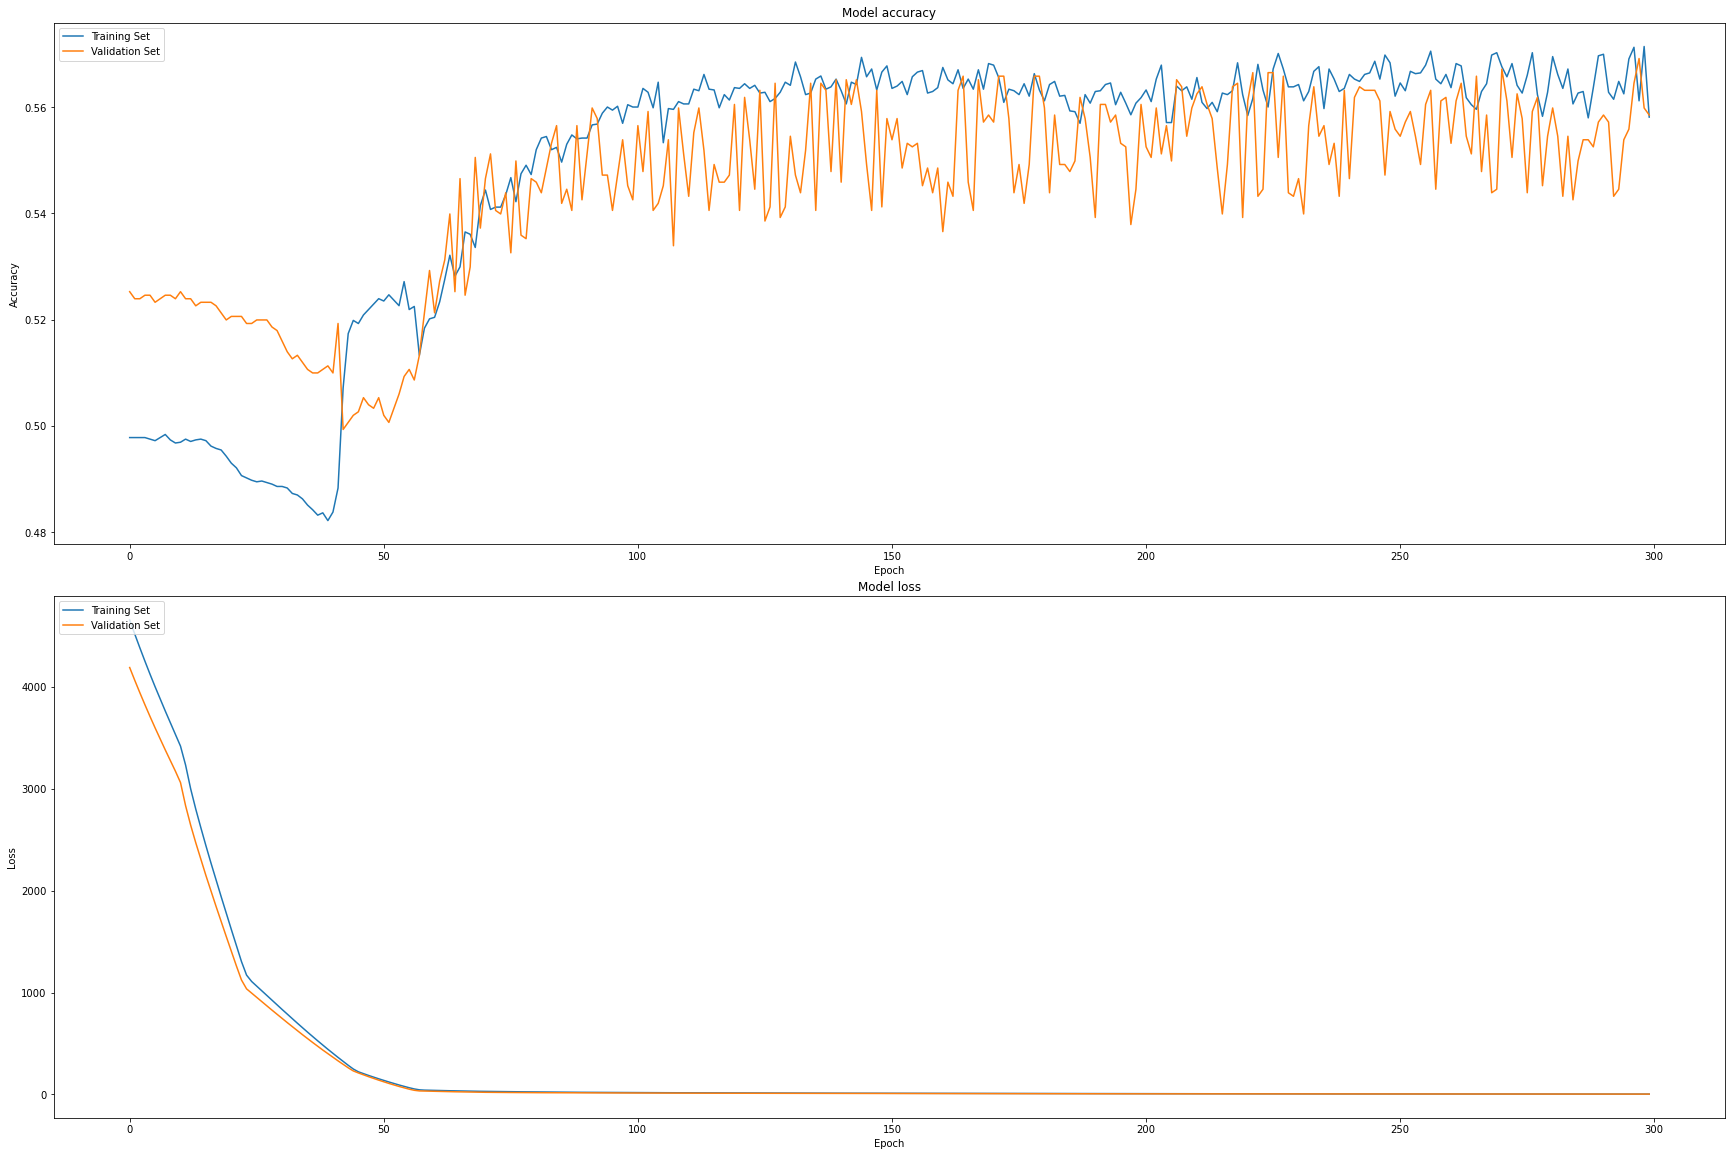

In [13]:
plot_history(history5)

In [3]:
model5 = tf.keras.models.load_model('model_checkpoints/model5/ckpt_300')

In [4]:
y_pred_probs5 = model5.predict(X_test)
print(y_pred_probs5)

49/49 [==============================] - 0s 1ms/step
[[1.5154109e-02 9.8484588e-01]
 [9.2481254e-33 1.0000000e+00]
 [4.3136984e-01 5.6863022e-01]
 ...
 [6.8838588e-09 1.0000000e+00]
 [1.0000000e+00 0.0000000e+00]
 [3.7024933e-01 6.2975067e-01]]


In [8]:
y_predict5 = np.round(y_pred_probs5)# Convert probabilities to binary predictions using a threshold of 0.5

binary_preds5 = np.argmax(y_predict5, axis=1)

precision5 = precision_score(y_test, binary_preds5)
recall5 = recall_score(y_test, binary_preds5)
f1_5 = f1_score(y_test, binary_preds5)

print( "precision: ", precision5)
print( "recall: ", recall5)
print("f1 score: ", f1_5)

precision:  0.5537525354969574
recall:  0.6973180076628352
f1 score:  0.6172979084228377


[[343 440]
 [237 546]]


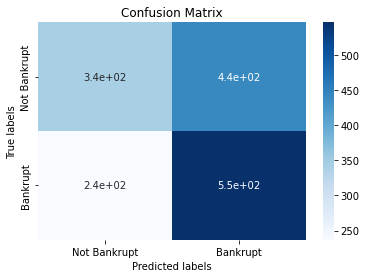

In [16]:
conf_mat = confusion_matrix(y_test, binary_preds5)
print(conf_mat)
plot_cm(conf_mat)